In [5]:
from datetime import datetime, date, timedelta
import functools
from types import MappingProxyType

import numpy as np
import pandas as pd
import json
from scipy import interpolate
import seaborn as sns; sns.set()
import pathlib
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from scipy.interpolate import InterpolatedUnivariateSpline
from sklearn.linear_model import RANSACRegressor
from shapely.ops import nearest_points
from abc import ABC, abstractmethod, abstractproperty
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt

plt.ioff()

pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.float_format", "{:,.6f}".format)

# List files name contains bus info
list_bus_info_file_names = [
    "stops.json", "paths.json",
    "vars.json", "trips.json", "timetables.json",
    "routes.json"
]

PREDICTION_PATH = r"/data/ebms/feed/prediction"
PREDICTION_COLUMN_HEADERS = (
    "REQUESTTIME", "STOPID", "ROUTEID", 
    "ROUTEVARID", "BUSID", "LOCTIMESTAMP", 
    "DISTANCE", "SPEED",
    "TIMETOSTOP", "UNAMED",
)
BUSINFO_PATH = r"/data/ebms/feed/businfo"
DATE_TO_LOAD = "20200316"  # Date to analysis

In [6]:
!ls /data/ebms/feed/prediction

2020_03_10.csv	2020_06_07.csv	2020_09_04.csv	2020_12_04.csv	2021_03_03.csv
2020_03_11.csv	2020_06_08.csv	2020_09_05.csv	2020_12_05.csv	2021_03_04.csv
2020_03_12.csv	2020_06_09.csv	2020_09_06.csv	2020_12_06.csv	2021_03_05.csv
2020_03_13.csv	2020_06_10.csv	2020_09_07.csv	2020_12_07.csv	2021_03_06.csv
2020_03_14.csv	2020_06_11.csv	2020_09_08.csv	2020_12_08.csv	2021_03_07.csv
2020_03_15.csv	2020_06_12.csv	2020_09_09.csv	2020_12_09.csv	2021_03_08.csv
2020_03_16.csv	2020_06_13.csv	2020_09_10.csv	2020_12_10.csv	2021_03_09.csv
2020_03_17.csv	2020_06_14.csv	2020_09_11.csv	2020_12_11.csv	2021_03_10.csv
2020_03_18.csv	2020_06_15.csv	2020_09_12.csv	2020_12_12.csv	2021_03_11.csv
2020_03_19.csv	2020_06_16.csv	2020_09_13.csv	2020_12_13.csv	2021_03_12.csv
2020_03_20.csv	2020_06_17.csv	2020_09_14.csv	2020_12_14.csv	2021_03_13.csv
2020_03_21.csv	2020_06_18.csv	2020_09_15.csv	2020_12_15.csv	2021_03_14.csv
2020_03_22.csv	2020_06_19.csv	2020_09_16.csv	2020_12_16.csv	2021_03_15.csv
2020_03_23.csv	2020_06_20

In [7]:
def get_date_from_str(str_date):
    return datetime.strptime(str_date, "%Y%m%d")


def get_bus_info_path(date, list_info_files):
    
    def date_to_path(date):
        return date.strftime("/%Y/%m/%d")
    
    path = pathlib.Path(BUSINFO_PATH + date_to_path(date))
    
    file_path = {
        p.name: str(p)
        for p 
        in path.iterdir()
        if p.name in list_info_files
    }
    
    for l in list_info_files:
        if not file_path[l]:
            file_path[l] = None
    
    return file_path


def get_prediction_path(date):
    def date_to_file_name(date):
        return date.strftime("/%Y_%m_%d.csv")
    
    path = pathlib.Path(PREDICTION_PATH + date_to_file_name(date))
    
    return str(path) if path.exists() else None


def read_dim_data(path, is_list_json=True):
    if is_list_json:
        vars_data = pd.read_json(path, lines=True).stack().reset_index(drop=True)

        vars_df = pd.io.json.json_normalize(vars_data[~vars_data.isna()])
    else:
        vars_df = pd.read_json(path, lines=True)
    
    return vars_df


def expand_column(stops_df, column):
    stops_df = stops_df.reset_index()

    stops_stag = pd.concat(
        [pd.DataFrame(d)
         for d 
         in stops_df[column]], 
        keys=stops_df["index"]
    ).reset_index(level=1, drop=True)

    stops_df = (
        stops_df.drop(["index"], axis=1)
            .join(stops_stag)
            .reset_index(drop=True)
    )
    
    return stops_df


def read_paths(path):
    paths_df = (
        read_dim_data(path, False)
            .set_index(["RouteId", "RouteVarId"])
            .apply(pd.Series.explode)
            .reset_index()
    )
    
    paths_df.loc[:, ["lat", "lng"]] = paths_df[["lat", "lng"]].astype(float)
    
    return paths_df


def read_stops(path):
    stops_df = expand_column(
        read_dim_data(path, False),
        "Stops"  # Column contains Stop data
    )
    
    return stops_df


def copy_data(data):
    
    return {key: value.copy() for key, value in data.items()}


def upper_columns_names(data):
    for k, v in data.items():
        v.columns = v.columns.str.upper()


def load_predictions(path, column_headers):
    print(path)
    return pd.read_csv(
        path,
        dtype="str",
        names=column_headers
    ).drop("UNAMED", axis=1)


def preprocessing_prediction(predic):
    predic_df = predic.copy()
    
    int_columns = ["STOPID", "ROUTEVARID", "ROUTEID"]
    float_columns = ["DISTANCE", "SPEED", "TIMETOSTOP"]
    
    predic_df[int_columns] = predic_df.loc[:, int_columns].astype("float").astype("int")
    predic_df[float_columns] = predic_df.loc[:, float_columns].astype("float")
    
    return predic_df


def get_stops_full_data(all_data):
    vars_pre = all_data["vars.json"].merge(
        all_data["routes.json"][["ROUTEID", "ROUTENAME"]],
        on="ROUTEID",
        how="left",
        suffixes=("", "_y")
    )
    
    all_data["full_vars"] = vars_pre
    
    stop_pre = all_data["stops.json"].merge(
        vars_pre,
        on=["ROUTEID", "ROUTEVARID"],
        how="left",
    ).drop("STOPS", axis=1).drop_duplicates()
    
    all_data["full_stops"] = stop_pre
    

def get_full_prediction_data(predic, stop_data):
    example = predic.copy()
    example_full = example.merge(
        stop_data,
        on=["STOPID", "ROUTEID", "ROUTEVARID"],
        how="left",
        suffixes=("", "_DIM")
    )
    
    return example_full

In [8]:
# List of functions to load data
BUS_INFO_FUNC = MappingProxyType({
    "timetables.json": functools.partial(read_dim_data, is_list_json=True),
    "routes.json": functools.partial(read_dim_data, is_list_json=True),
    "vars.json": functools.partial(read_dim_data, is_list_json=True),
    "trips.json": functools.partial(read_dim_data, is_list_json=True),
    "stops.json": functools.partial(
        read_stops
    ),
    "paths.json": functools.partial(
        read_paths
    ),
})

def get_all_bus_info(date, list_info_files):
    bus_data = {}
    
    bus_info_path = get_bus_info_path(date, list_info_files)
    
    for key, value in bus_info_path.items():
        print(f"Get data from {value}")
        bus_data[key] = BUS_INFO_FUNC[key](path=value)
        
    return bus_data

In [9]:
def remove_missing_records_on_column(data, cols):
    missing_rec_mask = data[cols].isna().any(axis=1)
    
    return data[~missing_rec_mask].copy()

def get_linestring_all_path(path, serialize=True):
    paths_df = path.dropna().copy()

    paths_df["POINT"] = paths_df.apply(lambda x: Point(x["LNG"], x["LAT"]), axis=1)

    lines_df = (
        paths_df.groupby(["ROUTEID", "ROUTEVARID"])
            .POINT.apply(list)
            .apply(LineString)
            .to_frame("LINESTRING")
            .reset_index()
    )
    
    return lines_df

def get_distance_ratio_each_route(stops_ddf):
    stops_distance = stops_ddf.copy()

    stops_distance = stops_distance.merge(
        stops_distance.groupby(["ROUTEID", "ROUTEVARID"]).RANK.max().to_frame("MAXRANK"),
        on=["ROUTEID", "ROUTEVARID"],
        how="left",
    )

    # For First Point
    pri_keys = ["ROUTEID", "ROUTEVARID"]
    value_cols = ["SPOINT"]
    first_stops = stops_distance.loc[stops_distance.RANK==1, pri_keys + value_cols].copy()
    stops_distance = stops_distance.merge(
        first_stops,
        on=pri_keys,
        how="left",
        suffixes=("", "FSPOINT")
    )

    # For Last Point
    pri_keys = ["ROUTEID", "ROUTEVARID"]
    value_cols = ["SPOINT"]
    first_stops = stops_distance.loc[stops_distance.RANK==stops_distance.MAXRANK, pri_keys + value_cols].copy()
    stops_distance = stops_distance.merge(
        first_stops,
        on=pri_keys,
        how="left",
        suffixes=("", "LSPOINT")
    )

    def _change_slice(rec):
        new_linestr = list(rec["LINESTRING"].coords)
        new_linestr[0] = rec["SPOINTFSPOINT"].coords[0]
        new_linestr[-1] = rec["SPOINTLSPOINT"].coords[0]

        return LineString(new_linestr)

    _ = stops_distance.apply(lambda x: _change_slice(x), axis=1)
    stops_distance["STOPS_LINESTRING"] = _
    stops_distance["STOPSDISTANCE"] = stops_distance.apply(lambda x: x["STOPS_LINESTRING"].project(x["SPOINT"]), axis=1)
    stops_distance["ALLSTOPSDISTANCE"] = stops_distance.apply(lambda x: x["STOPS_LINESTRING"].project(x["SPOINTLSPOINT"]), axis=1)
    stops_distance["RATIOSTOPSDISTANCE"] = stops_distance.eval("STOPSDISTANCE / ALLSTOPSDISTANCE")
    
    return stops_distance

In [10]:
def get_log_distance_ratio_predict(predic_df):
    # Convert to integer for easier to predict
    predic_df["TIMESTAMP"] = pd.to_datetime(predic_df["LOCTIMESTAMP"]).astype("int64") // 10**9

    # preprocessing some columns in predic data
    predic_df["BUSIDSTR"] = predic_df["BUSID"].str.strip()  #remove space
    predic_df["LOCTIMESTAMP"] = pd.to_datetime(predic_df["LOCTIMESTAMP"])  #convert to datetime
    predic_df["STOPIDSTR"] = predic_df["STOPID"].astype("str")  #convert to string
    predic_df["DISTANCERATIO"] = predic_df.eval("DISTANCE / DISTANCE_DIM")

    return predic_df

def remove_outlier_whole_trips(df, plot=False):
    center_data = df[df.FIRSTHALF==99].copy()
    
    data_half = {
        "first": df[df.FIRSTHALF==1].copy(),
        "center": center_data,
        "second": df[df.FIRSTHALF==2].copy(),
    }
    
    def _mark_outlier(data, is_reverse):
        outlier = mark_all_velocity_outlier(data["DISTANCE"], data["TIMESTAMP"], is_reverse=is_reverse, threshold=1)

        # Show detected outliers
        data["VREMOVE"] = outlier

        if plot:
            fig, ax = plt.subplots(figsize=(10, 8))
            _draw_time_distance(data, hue="VREMOVE", alpha=0.8)
            plt.show()

            # data after remove outliers
            fig, ax = plt.subplots(figsize=(10, 8))
            _draw_time_distance(data[data.VREMOVE==0], alpha=0.8)
            plt.show()
    
        return data[data.VREMOVE==0].copy()
    
    dt = []
    for i, v in data_half.items():
        if i == "center":
            dt.append(v)
        else:
            is_rv = True if i == "first" else False
            dt.append(_mark_outlier(v, is_rv))
            
    df = pd.concat(dt, axis=0, sort=False)
        
    return df

def remove_outliers_whole_route(df, plot=False):
    trips = df.TRIPS.unique()
    print("There are {} trips: {}".format(trips.shape[0], ", ".join(trips)))
    
    rs = []
    for t in trips:
        print(f"Remove outliers for trips: {t}")
        dt = df[df.TRIPS==t].copy()
        rs.append(remove_outlier_whole_trips(dt, plot))
        
    return pd.concat(rs, sort=False)

def remove_distance_not_increase(ds, n_iters=500):
    ds = ds.copy()
    msk = pd.Series(False, index=ds.index)
    
    for i in range(n_iters):
        delta_d = ds.shift() - ds
        invalid = delta_d <= 0
        if invalid.sum() <= 0:
            print("There is no decrease distance")
            break
        msk |= invalid
        ds = ds[~msk].copy()
    
    return msk.copy()

def interpolate_time(predic_df, stops_df, plot=False):
    msk = remove_distance_not_increase(predic_df.DISTANCE.copy())
    
    predic_df = predic_df[~msk].copy()
    x = 1 - predic_df["DISTANCERATIO"]
    y = predic_df["TIMESTAMP"].astype("int")
    y = y[y.index.isin(x.index)].copy()
    spl = InterpolatedUnivariateSpline(x, y, k=1)
    xs = stops_df["RATIOSTOPSDISTANCE"]
    if plot:
        fig, ax = plt.subplots(figsize=(10, 8))
        plt.plot(xs, spl(xs), 'gv')
        plt.plot(x, y, 'ro', ms=5, alpha=0.2, linewidth=6)
        plt.show()
    
    return spl(xs)

def predic_whole_route(route_data, stops, plot, cols=None, pref="ARRIVETIMETRIPS"):
    trips = route_data.TRIPS.unique()
    stops = stops.copy()
    
    ipl = []
    for t in trips:
        print(f"Predict for trips {t}")
        dta = route_data[route_data.TRIPS==t].copy()
        ipl.append(interpolate_time(dta, stops, plot))
        col_names = []
        
    for i, v in enumerate(ipl):
        cn = pref + "{:02d}".format(int(i))
        col_names.append(cn)
        stops[cn] = v
    
    col_pre = stops.columns[stops.columns.str.contains(pref)].tolist()
    for c in col_pre:
        print(f"Convert column name {c}")
        stops[c] = convert_timezone(stops[c])
            
    if cols:
        dt_rt = stops[cols + col_pre].copy()
    else:
        dt_rt = stops.copy()
    
    return dt_rt

In [11]:
def mark_first_half(df, rate=(0.1, 0.9)):
    df["FIRSTHALF"] = np.nan
    df.loc[df.DISTANCE < (df.DISTANCE_DIM.max() * rate[0]), "FIRSTHALF"] = 2
    df.loc[df.DISTANCE > (df.DISTANCE_DIM.max() * rate[1]), "FIRSTHALF"] = 1
    df.loc[df.FIRSTHALF.isna(), "FIRSTHALF"] = 99


def preprocessing_route_bus(df, ratio_distance_peak=0.8):
    df = df.drop_duplicates(["TIMESTAMP"], keep="first").copy()
    df = df.sort_values(["TIMESTAMP"]).copy()
    df["IS_PEAK"] = mark_peak_point(df, df.DISTANCE.max(), ratio_distance_peak)
    df["TRIPS"] = split_trips(df, xffix=("TRIPS", ""))
    df = df.dropna(subset=["TRIPS"]).copy()
    mark_first_half(df)
    
    return df

def mark_peak_point(df, distance, ratio=1):
    dis = df["DISTANCE"].copy()
    
    shifted_dis = dis - dis.shift()
    msk_peak = shifted_dis > (distance * ratio)
    
    return msk_peak


# Tách các trips
def split_trips(df, cols="IS_PEAK", xffix=("", "")):
    trips = df[cols].cumsum().copy().astype("int").to_frame("PEAK")
    
    mean_log = trips.groupby("PEAK").size().mean() * 0.5
    drop_peak = trips.groupby("PEAK").size()
    drop_peak = drop_peak[drop_peak < mean_log]
    trips = trips[~trips.PEAK.isin(drop_peak.index.tolist())].copy()
    trips.PEAK = (trips.PEAK.rank(method="dense") - 1).astype("int").astype("str")
    trips = trips.PEAK
    
    trips = xffix[0] + trips.str.zfill(2) + xffix[1]
    
    return trips

In [12]:
def get_velocity(dfd, dft, is_reverse=False):
    if is_reverse:
        d = dfd[::-1].copy()
        t = dft[::-1].copy()
        dd = d - d.shift()
    else:
        d = dfd.copy()
        t = dft.copy()
        dd = d.shift() - d
    

    tt = (t - t.shift()).abs()
    
    return (dd / tt)[::-1] if is_reverse else (dd / tt)


def mark_velocity_outlier(v_col, threshold=1.5):
    msk_vel = v_col < threshold
    msk_rm = pd.Series(False, index=v_col.index)
    msk_rm[msk_vel] = True
    
    return msk_rm.copy()


def mark_all_velocity_outlier(dfd, dft, threshold=1, is_reverse=False, n_iters=5):
    index = dfd.index.copy()
    msk_vel = pd.Series(False, index=index)
    
    print(f"Starting to remove outlier with velocity threshold {threshold} "
          f"and max number of iterates is {n_iters} times")
    for i in range(n_iters):
        velocity = get_velocity(dfd[~msk_vel], dft[~msk_vel], is_reverse)
        start_msk_vel = mark_velocity_outlier(velocity, threshold)
        num_outlier = start_msk_vel.sum()
        print(f"Detected {num_outlier} outlier.")
        
        if num_outlier <= 0:  # exit loop if there is no outlier
            print("There is no outliers remain!")
            break
            
        dfd = dfd[~start_msk_vel].copy()
        dft = dft[~start_msk_vel].copy()
        
        msk_vel |= start_msk_vel

    return msk_vel


def _draw_time_distance(df, cols=("TIMESTAMP", "DISTANCE"), hue=None, alpha=0.2, size=None):
    # Plot example
    sns.scatterplot(data=df, x=cols[0], y=cols[1], hue=hue, alpha=alpha)
    

def convert_timezone(sr):
    return pd.to_datetime(
            sr, 
            unit="s"
        ).dt.tz_localize(
            "UTC"
        ).dt.tz_convert("Asia/Ho_Chi_Minh").dt.tz_localize(None)

In [13]:
def load_data(date):
    # Load data của các chuyến xe bus.
    print("Get bus info.")
    all_data_cp = get_all_bus_info(
        date, 
        list_info_files=list_bus_info_file_names
    )
    # Upper all column names
    upper_columns_names(all_data_cp)
    # Lấy thông tin (merge thông tin) từ nhiều file
    get_stops_full_data(all_data_cp)
    
    # read predictions file
    print("Get log data.")
    prediction_df = load_predictions(
        get_prediction_path(date),
        PREDICTION_COLUMN_HEADERS
    )
    # convert some columns from str to int, float or datetime
    prediction_df = preprocessing_prediction(prediction_df)
    # Lấy thông tin của Stops vào Prediction
    full_predic = get_full_prediction_data(prediction_df, all_data_cp["full_stops"])
    full_predic = remove_missing_records_on_column(full_predic, ["CODE"])
    full_predic = get_log_distance_ratio_predict(full_predic)
    
    return all_data_cp, full_predic

In [14]:
def get_data_processed(date):
    # Load data của các chuyến xe bus.
    print("Get bus info.")
    all_data_cp = get_all_bus_info(
        date, 
        list_info_files=list_bus_info_file_names
    )
    # Upper all column names
    upper_columns_names(all_data_cp)
    # Lấy thông tin (merge thông tin) từ nhiều file
    get_stops_full_data(all_data_cp)
    
    # read predictions file
    print("Get log data.")
    prediction_df = load_predictions(
        get_prediction_path(date),
        PREDICTION_COLUMN_HEADERS
    )
    # convert some columns from str to int, float or datetime
    prediction_df = preprocessing_prediction(prediction_df)
    # Lấy thông tin của Stops vào Prediction
    full_predic = get_full_prediction_data(prediction_df, all_data_cp["full_stops"])
    full_predic = remove_missing_records_on_column(full_predic, ["CODE"])
    full_predic = get_log_distance_ratio_predict(full_predic)
    
    # Rank data stops for each route
    print("Ranking stops sequences.")
    line_string = get_linestring_all_path(all_data_cp["paths.json"])
    stops_ddf = all_data_cp["full_stops"].copy()
    stops_ddf = stops_ddf.dropna(subset=["LNG", "LAT"]).copy()
    stops_ddf = stops_ddf.merge(
        line_string,
        on=["ROUTEID", "ROUTEVARID"],
        how="inner",
        suffixes=("", "LINEINFO")
    )

    stops_ddf["SPOINT"] = stops_ddf.apply(lambda x: Point(x["LNG"], x["LAT"]), axis=1)
    stops_ddf["DISTANCE"] = stops_ddf.apply(lambda x: x["LINESTRING"].project(x["SPOINT"]), axis=1)
    stops_ddf["RANK"] = stops_ddf.groupby(["ROUTEID", "ROUTEVARID"]).DISTANCE.rank(method="first")

    # final data with ranking of stops id and distance ratio
    stops_ddf = stops_ddf.sort_values(["ROUTEID", "ROUTEVARID", "RANK"])
    print("Get Ratio distance for each stops.")
    print(stops_ddf.columns)
#     stops_ddf = get_distance_ratio_each_route(stops_ddf).drop("STOPS", axis=1)
    
    stops_ddf = get_distance_ratio_each_route(stops_ddf)
    
    return stops_ddf, full_predic

In [15]:
def generate_date_from_range(from_date, to_date):
    curr_date = from_date
    while curr_date <= to_date:
        yield curr_date
        curr_date = curr_date + timedelta(days=1)

        
def run_predict_all_route(pre, stop, list_route, plot=(False, False)):
    
    result = []
    for lr in list_route:
        print("Running for ROUTEID {} and ROUTEVARID {}".format(
            lr[0],
            lr[1],
        ))
        cols_to_get = ["ROUTEID", "ROUTEVARID", 
                       "STOPID", "CODE", "NAME", "STOPTYPE", 
                       "ZONE", "WARD", "ADDRESSNO", "STREET", "SUPPORTDISABILITY", 
                       "STATUS", "LNG", "LAT", 
                       "SEARCH", "ROUTES", "RANK"]
        time_tables = predict_whole_route_all_bus(
            pre, 
            stop, 
            route_id=lr[0], 
            routevar_id=lr[1], 
            plot=plot,
            cols=cols_to_get,
            ratio_distance=0.8
        )

        result.append(time_tables)
    
    try:
        rs = pd.concat(result, axis=0, sort=True, ignore_index=True)
    except:
        rs = None
    
    return rs
         

def run_pipeline_multi_date(date_list, route_id=None, route_var_id=None, plot=(False, False)):
    
    result = {}
    for d in date_list:
        date_str = d.strftime("%Y-%m-%d")
        stop, pre = get_data_processed(d)
        
        if route_id and route_var_id:
            list_route = [(route_id, route_var_id)]
        else:
            list_route = (
                pre[["ROUTEID", "ROUTEVARID"]]
                    .drop_duplicates()
                    .values.tolist()
            )
        

        print("Predict for date {}".format(date_str))
        
        time_tables = run_predict_all_route(
            pre,
            stop,
            list_route,
            plot=plot,
        )
        
        result[date_str] = time_tables
        
    return result

In [16]:
def predict_whole_route_all_bus(predic, 
                                stops, 
                                route_id, 
                                routevar_id, 
                                cols,
                                plot=(False, False),
                                ratio_distance=0.8):
    
    stops_df = stops[(stops.ROUTEID==route_id) & (stops.ROUTEVARID==routevar_id)].copy()
    predic_df = predic[(predic.ROUTEID==route_id) & (predic.ROUTEVARID==routevar_id)].copy()
    
    bus = predic_df.BUSID.unique()
    
    time_tables = []
    for b in bus:
        try:
            bus_data = predic_df[predic_df.BUSID==b].copy()
            print(f"Predic for bus {b} with shape {bus_data.shape}")
            print("Length Time Tables: " + str(len(time_tables)))
            dt_removed = preprocessing_route_bus(bus_data, ratio_distance)
            dt_removed = remove_outliers_whole_route(dt_removed, plot[0])
            print(f"Shape after preprocessing {dt_removed.shape}")

            predicted = predic_whole_route(dt_removed, stops_df, plot[1], cols=cols)
            predicted["BUSPREDIC"] = b
            
            time_tables.append(predicted.copy())
        except Exception as e:
            print("Error: " + str(e))
            continue
            
    try:
        rs = pd.concat(time_tables, axis=0, sort=True, ignore_index=True)
    except:
        rs = None
        
        
    return rs

In [523]:
pd.DataFrame([1,2,3,4]).drop_duplicates().values.tolist()

[[1], [2], [3], [4]]

Get bus info.
Get data from /data/ebms/feed/businfo/2020/03/16/routes.json
Get data from /data/ebms/feed/businfo/2020/03/16/timetables.json
Get data from /data/ebms/feed/businfo/2020/03/16/trips.json
Get data from /data/ebms/feed/businfo/2020/03/16/vars.json
Get data from /data/ebms/feed/businfo/2020/03/16/paths.json
Get data from /data/ebms/feed/businfo/2020/03/16/stops.json
Get log data.
/data/ebms/feed/prediction/2020_03_16.csv
Ranking stops sequences.
Get Ratio distance for each stops.
Predict for date 2020-03-16
Running for ROUTEID 51 and ROUTEVARID 2
Predic for bus 53N4414 with shape (2567, 35)
Length Time Tables: 0
There are 3 trips: TRIPS00, TRIPS01, TRIPS02
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


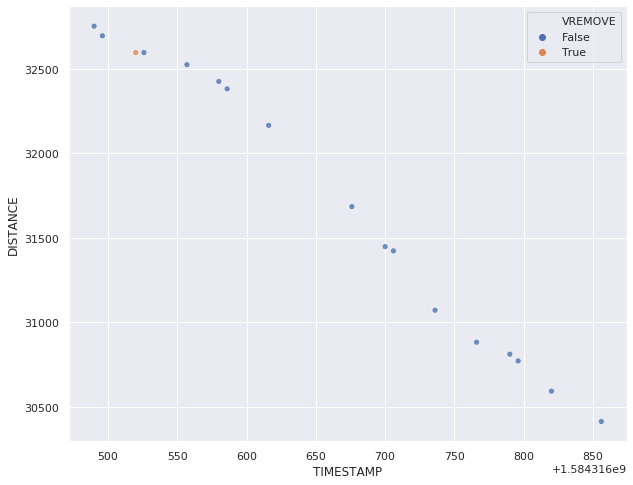

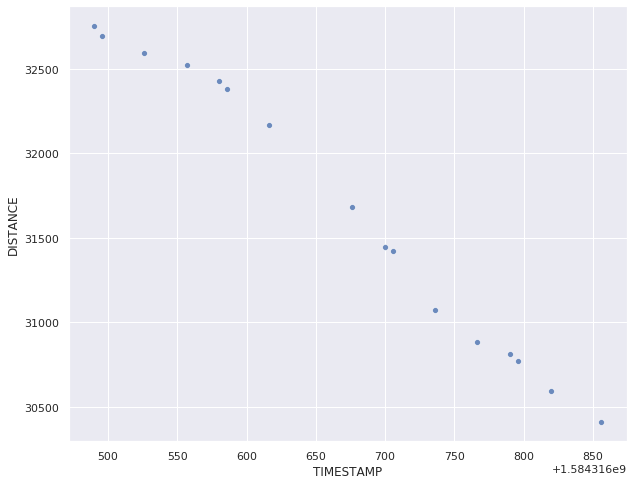

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 40 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


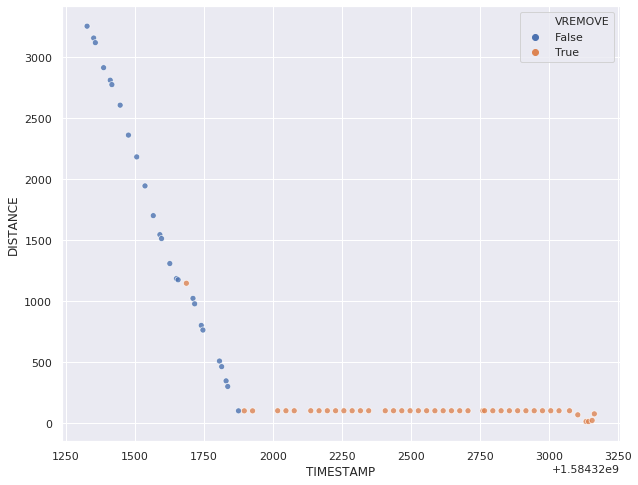

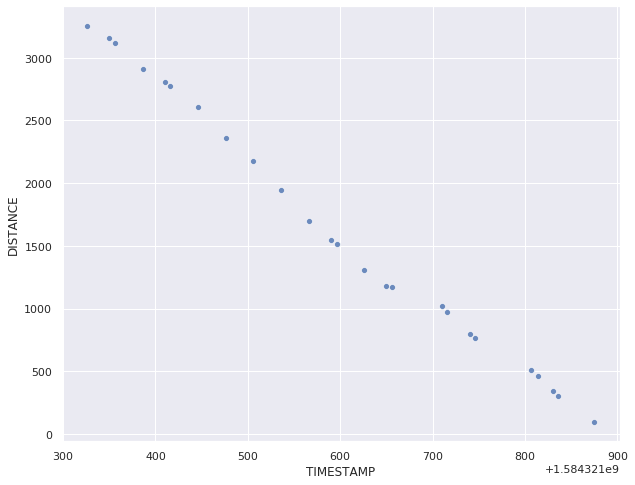

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


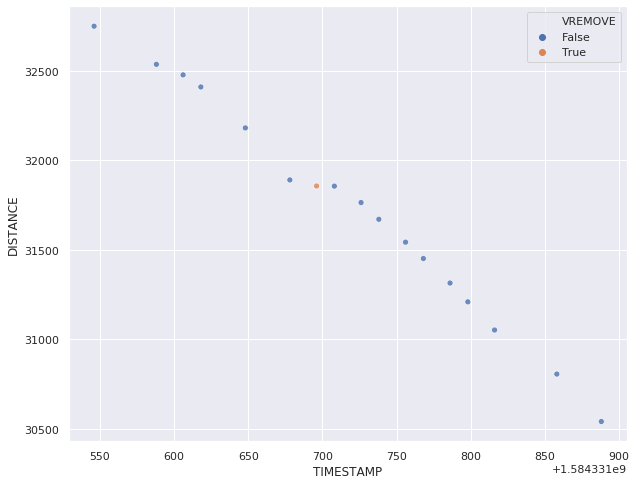

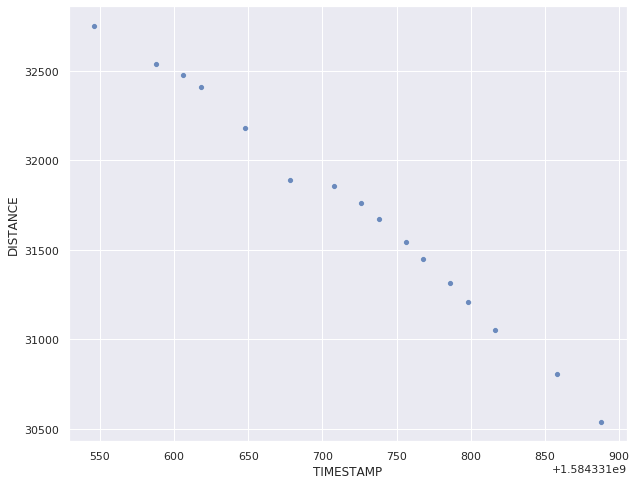

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 86 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


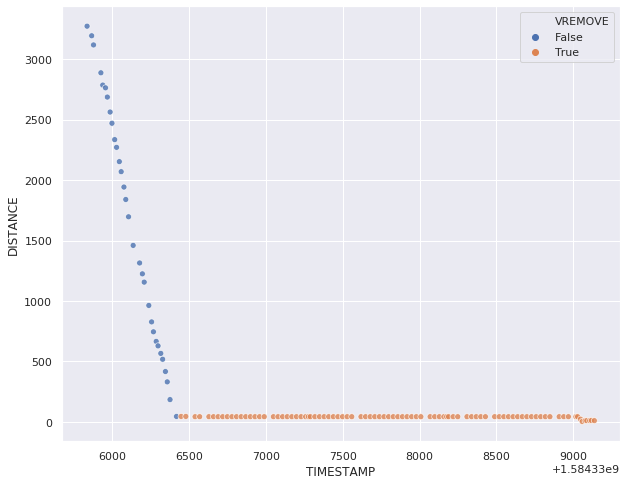

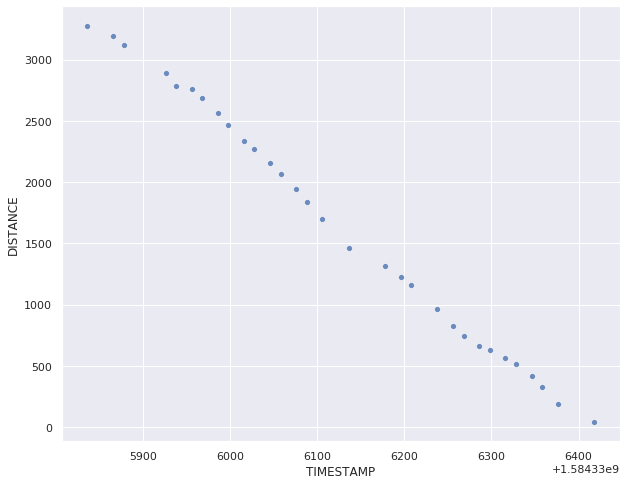

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


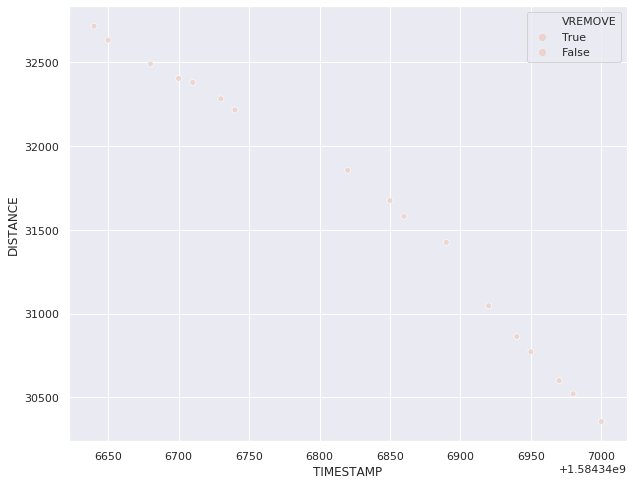

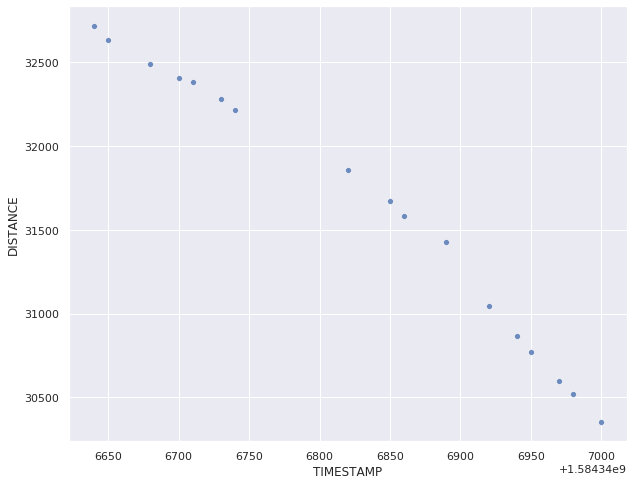

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 74 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


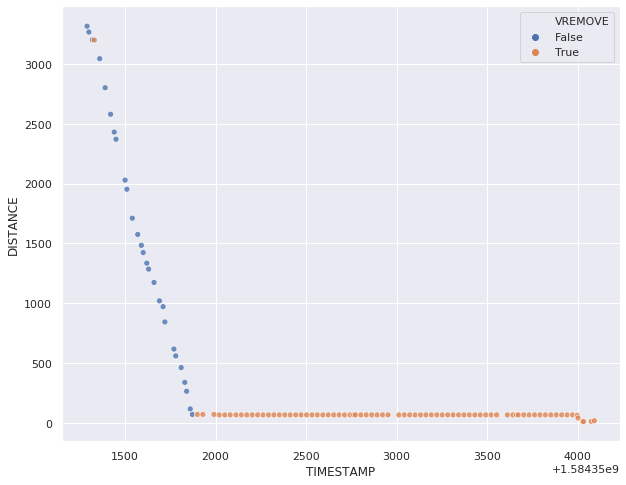

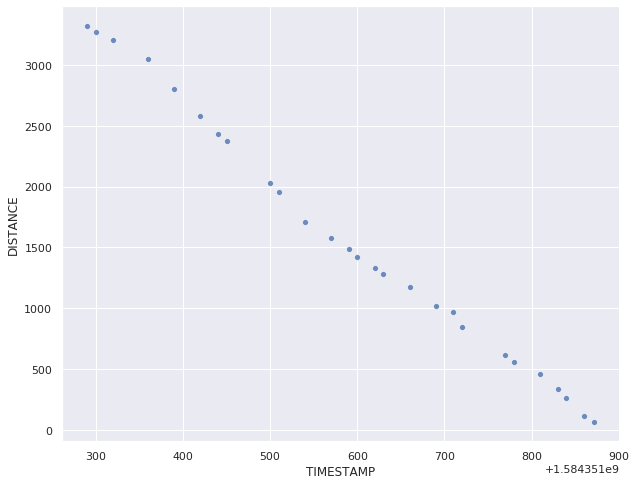

Shape after preprocessing (706, 39)
Predict for trips TRIPS00
There is no decrease distance


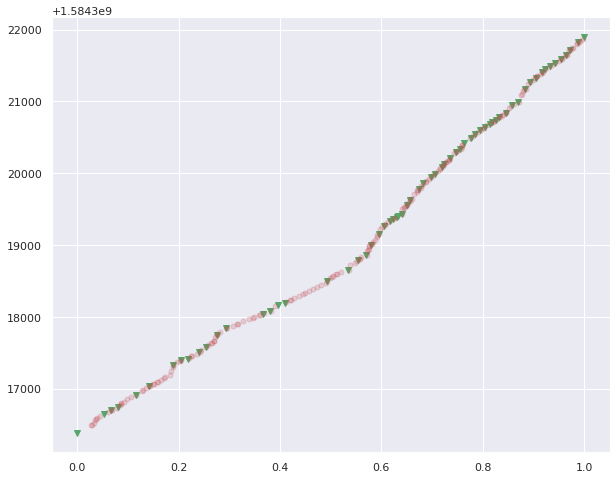

Predict for trips TRIPS01
There is no decrease distance


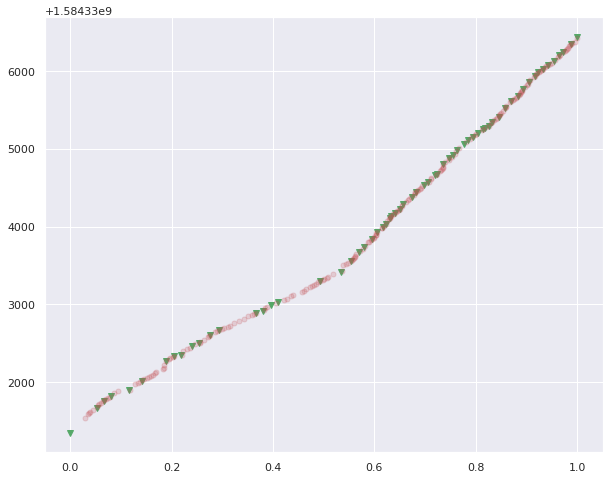

Predict for trips TRIPS02
There is no decrease distance


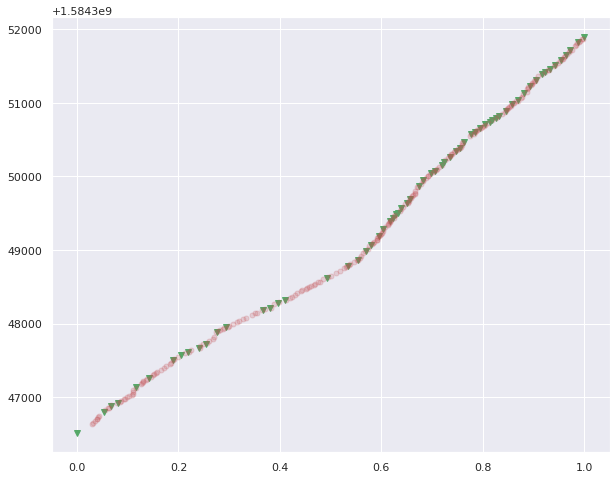

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Predic for bus 53N5002 with shape (2621, 35)
Length Time Tables: 1
There are 4 trips: TRIPS00, TRIPS01, TRIPS02, TRIPS03
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 20 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


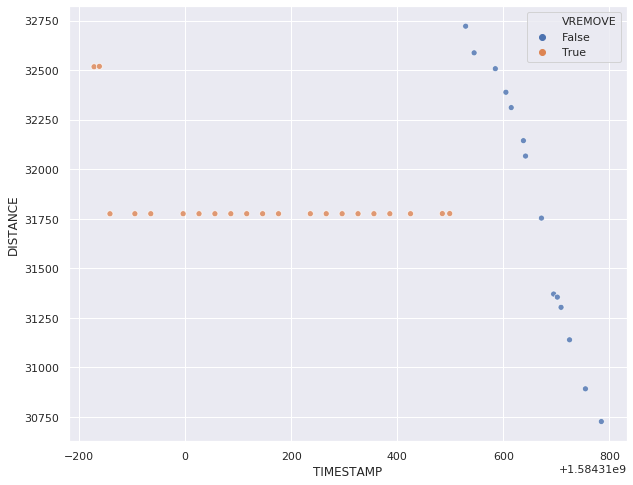

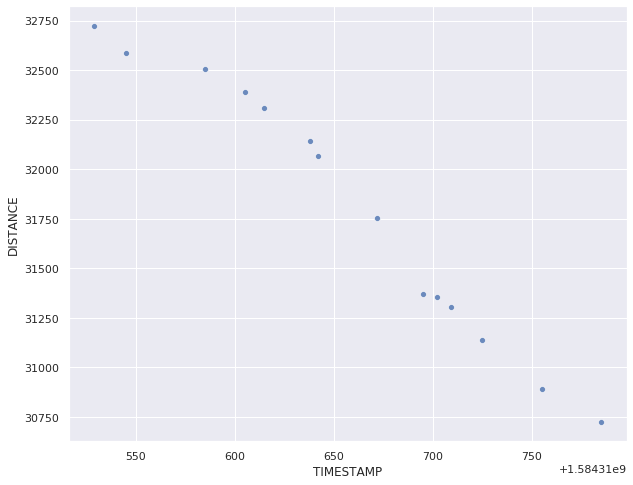

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 51 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


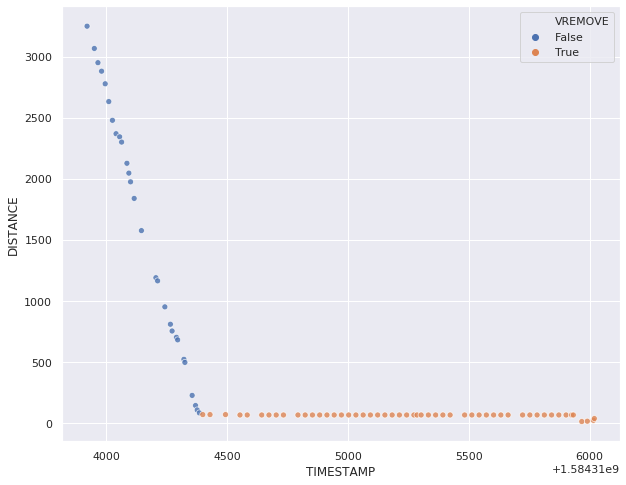

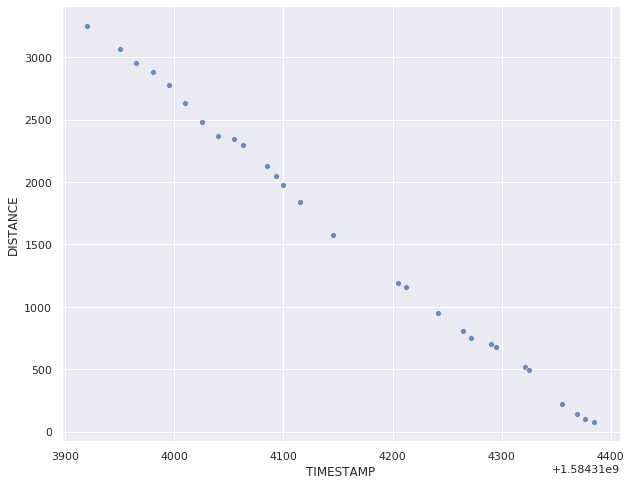

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


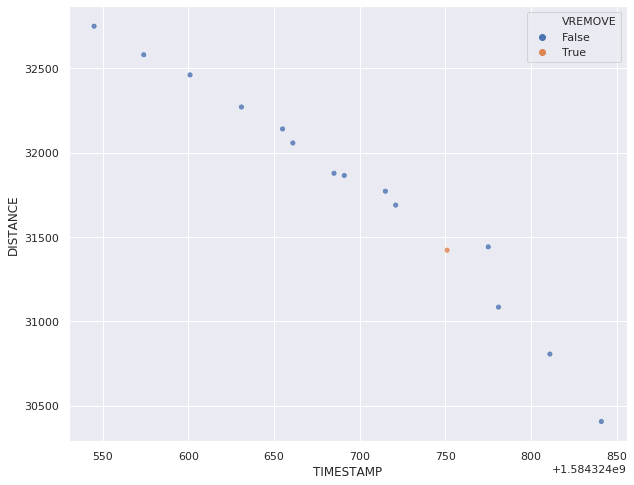

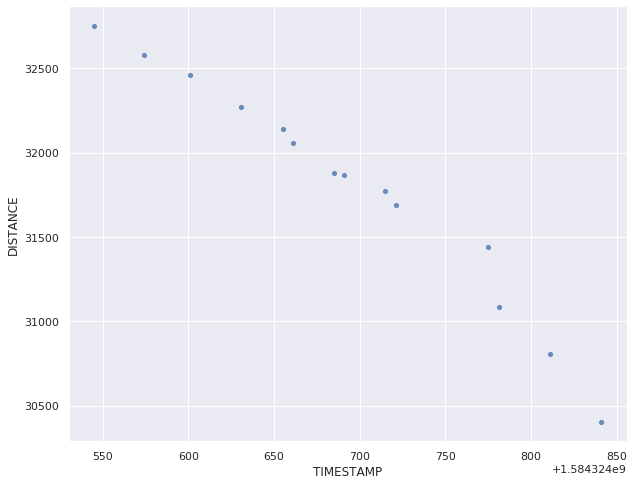

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 78 outlier.
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


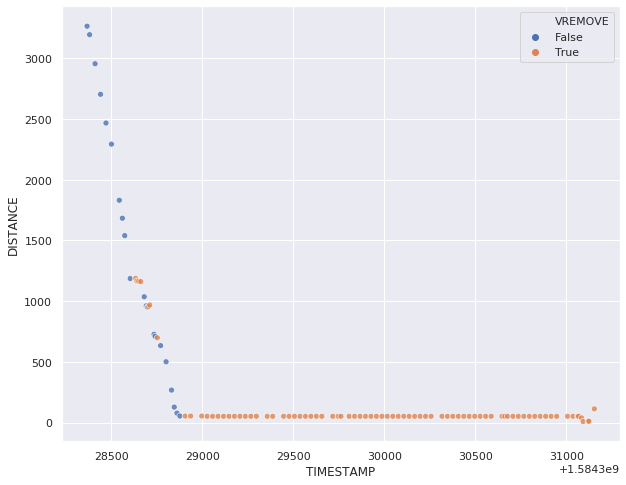

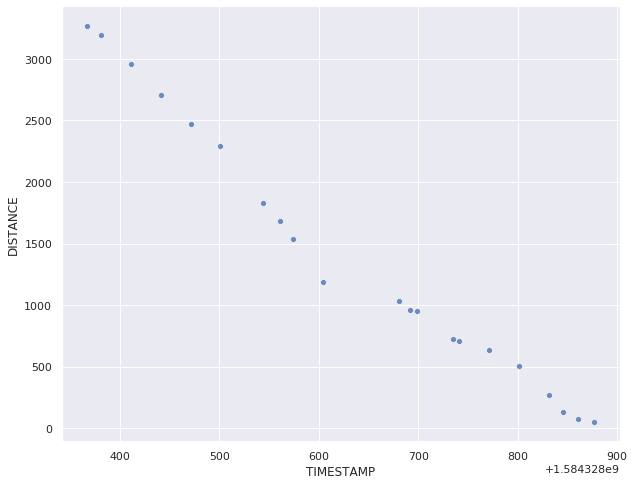

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


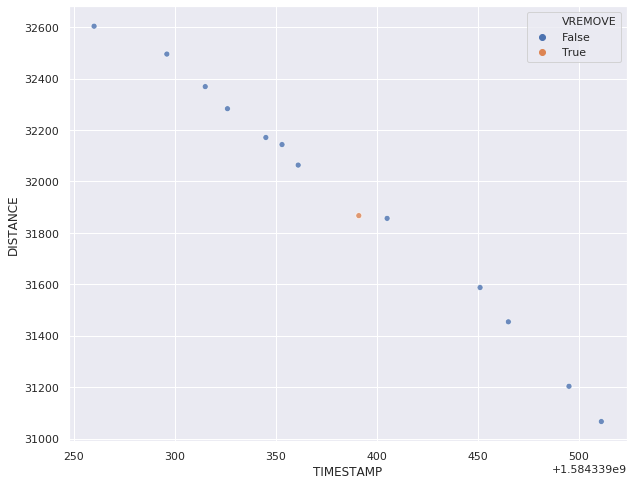

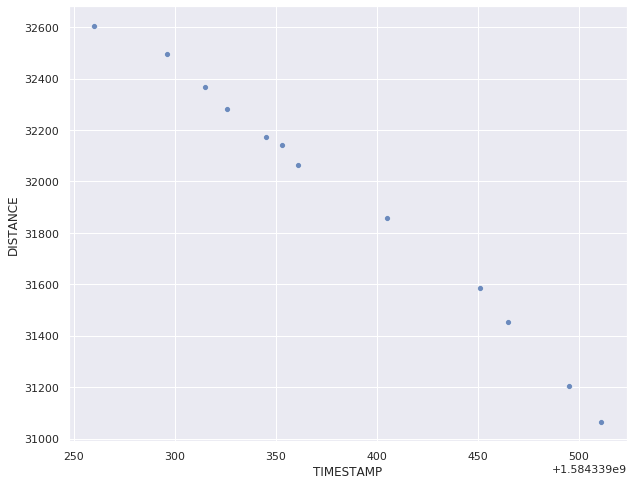

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 121 outlier.
Detected 0 outlier.
There is no outliers remain!


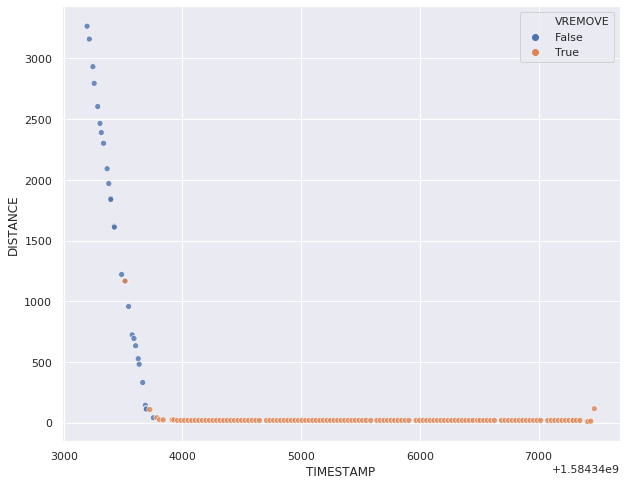

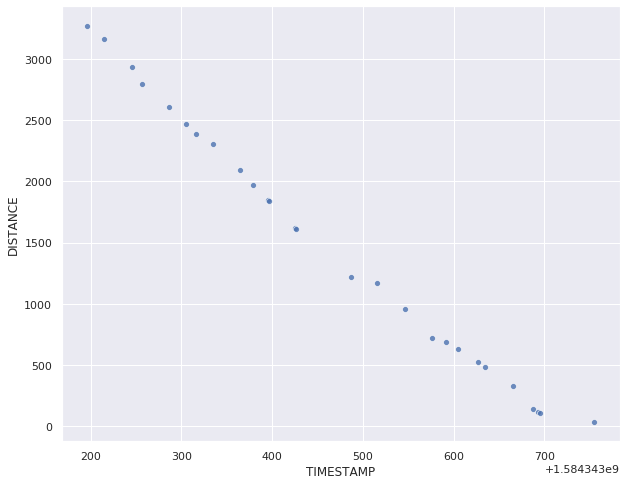

Remove outliers for trips: TRIPS03
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


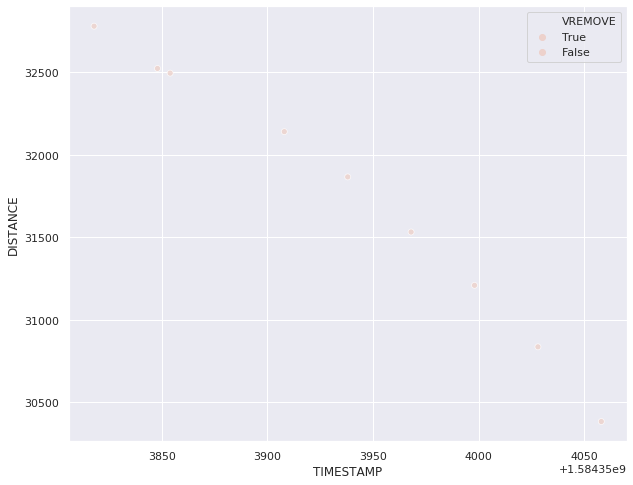

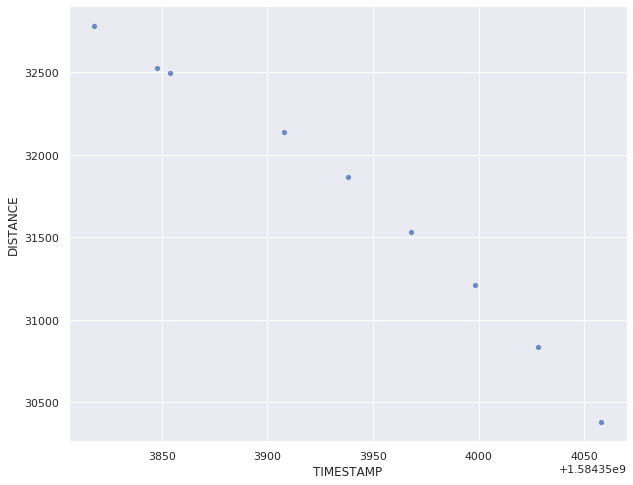

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 12 outlier.
Detected 2 outlier.
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


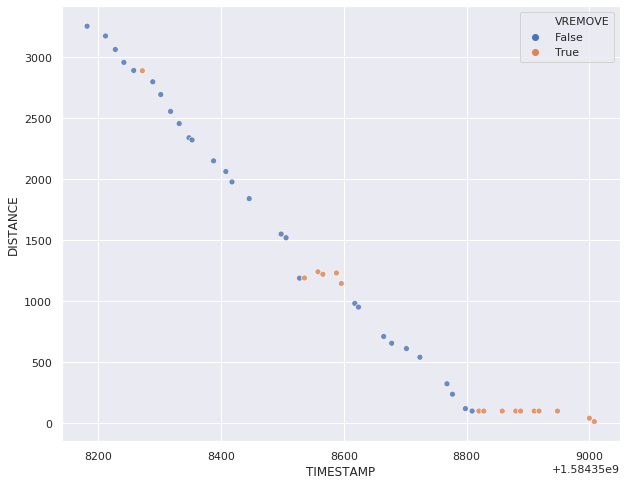

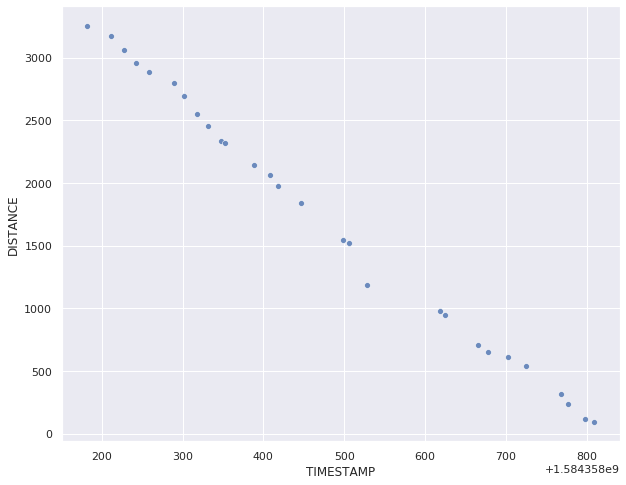

Shape after preprocessing (774, 39)
Predict for trips TRIPS00
There is no decrease distance


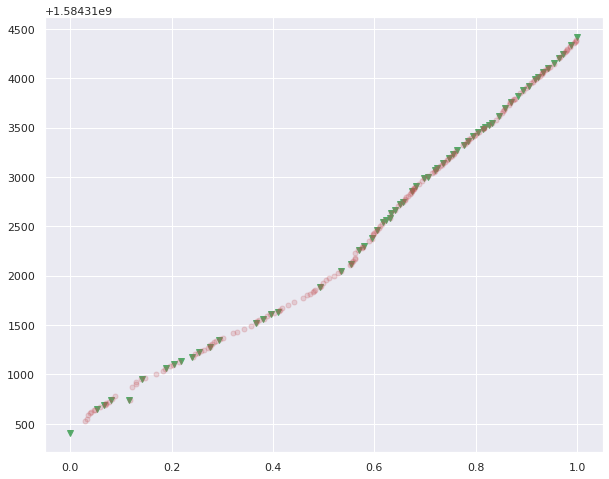

Predict for trips TRIPS01
There is no decrease distance


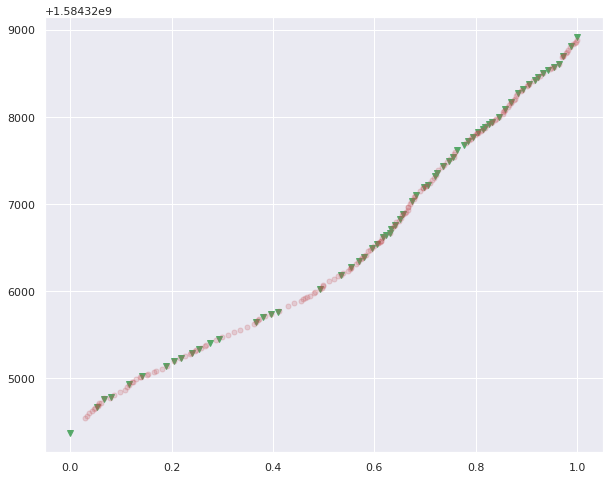

Predict for trips TRIPS02
There is no decrease distance


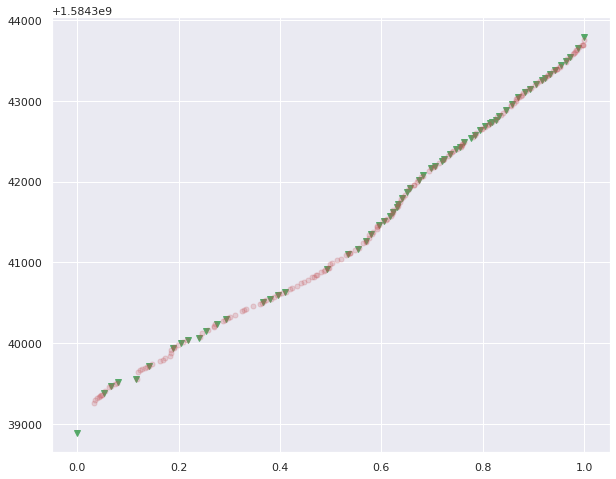

Predict for trips TRIPS03
There is no decrease distance


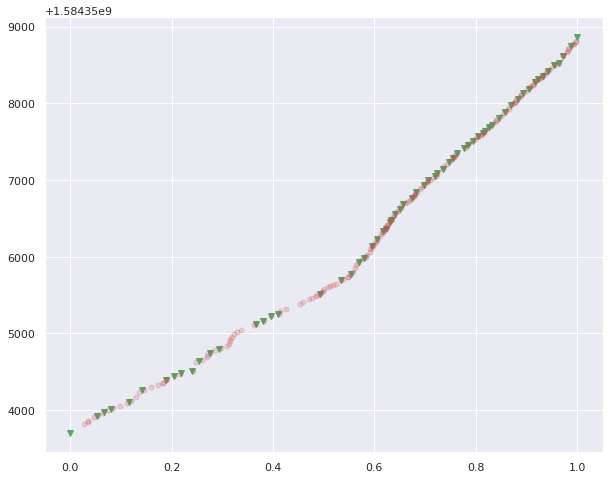

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Convert column name ARRIVETIMETRIPS03
Predic for bus 53N5040 with shape (2574, 35)
Length Time Tables: 2
There are 4 trips: TRIPS00, TRIPS01, TRIPS02, TRIPS03
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


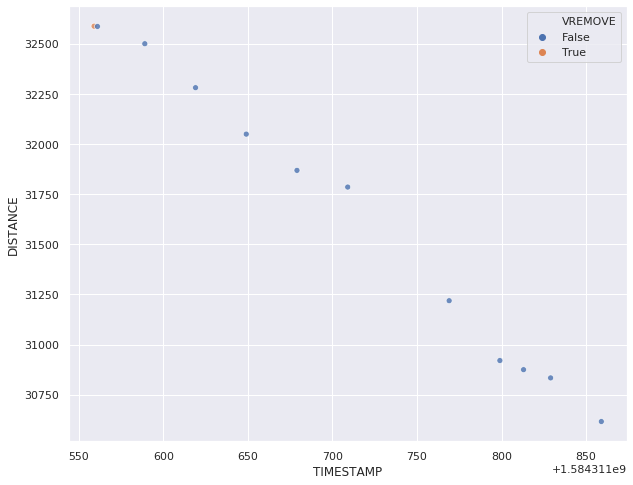

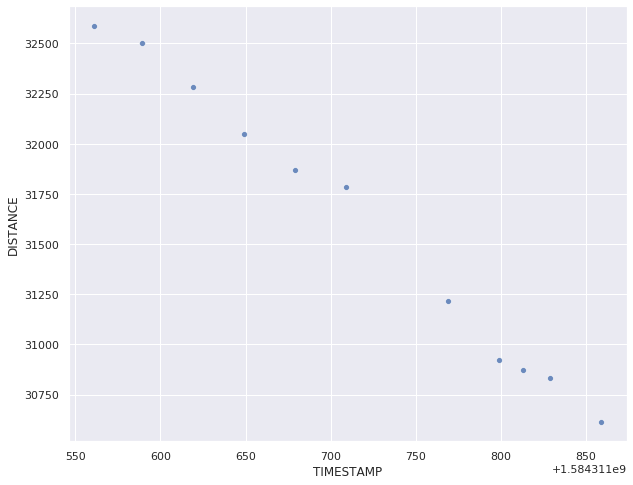

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 46 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


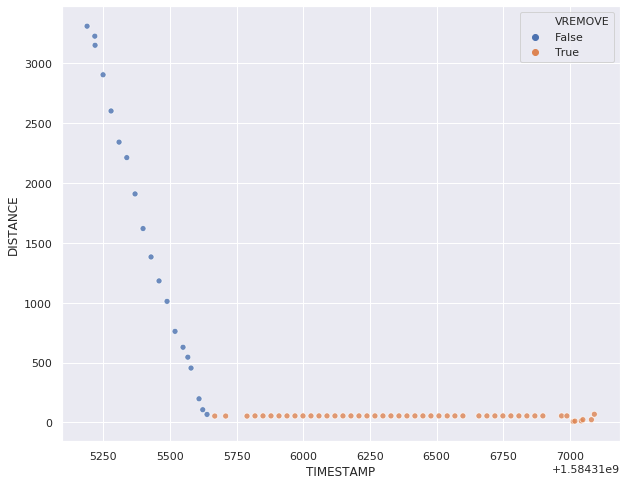

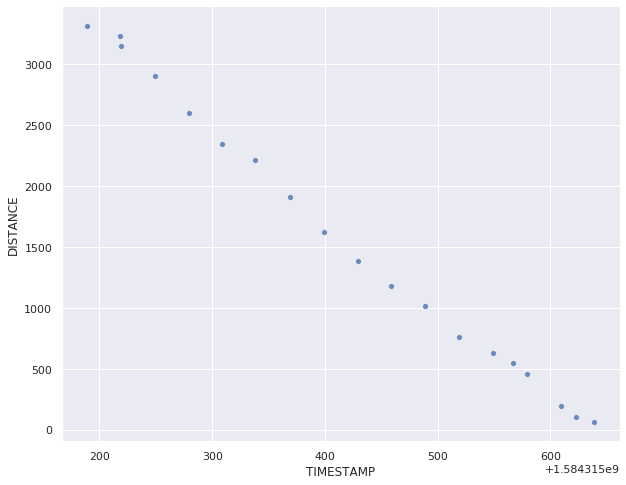

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


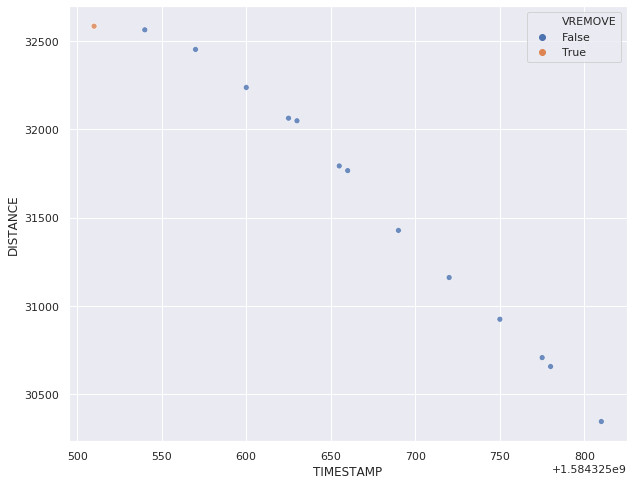

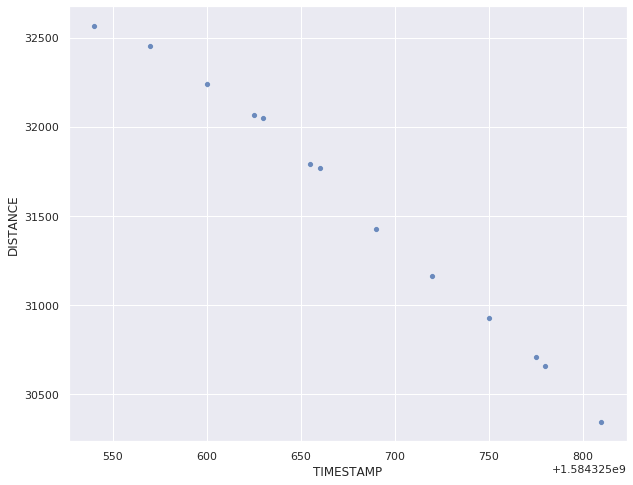

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 69 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


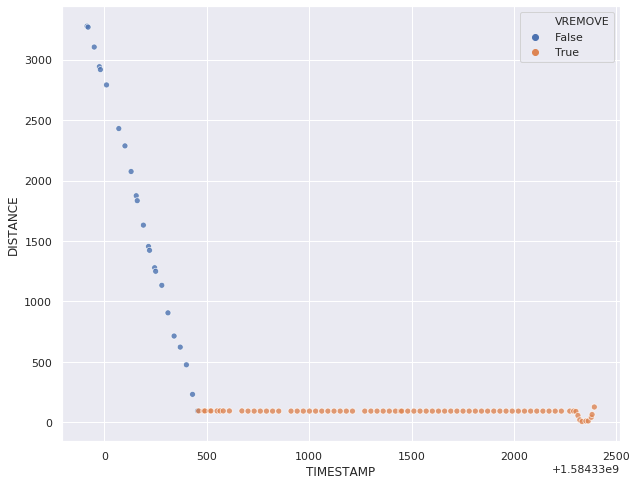

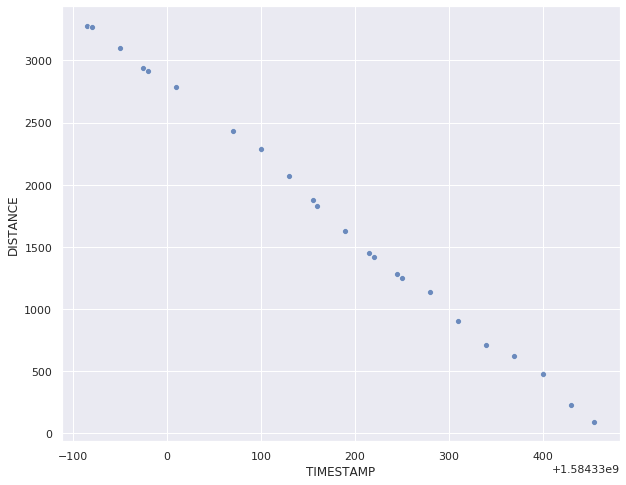

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


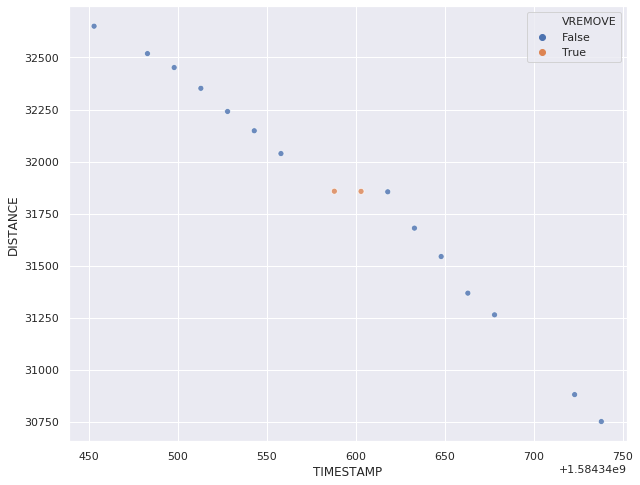

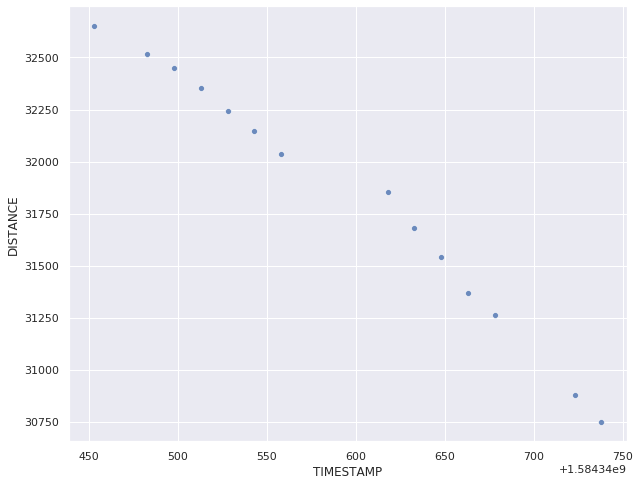

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 113 outlier.
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


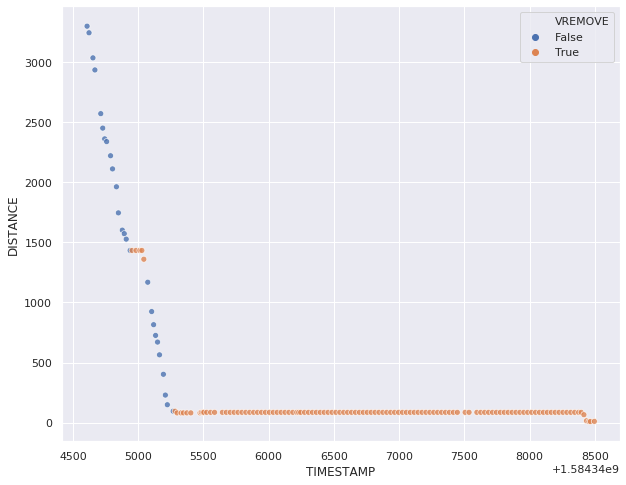

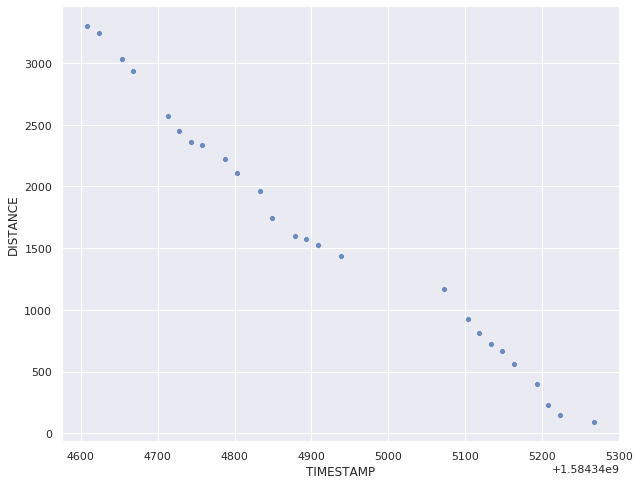

Remove outliers for trips: TRIPS03
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


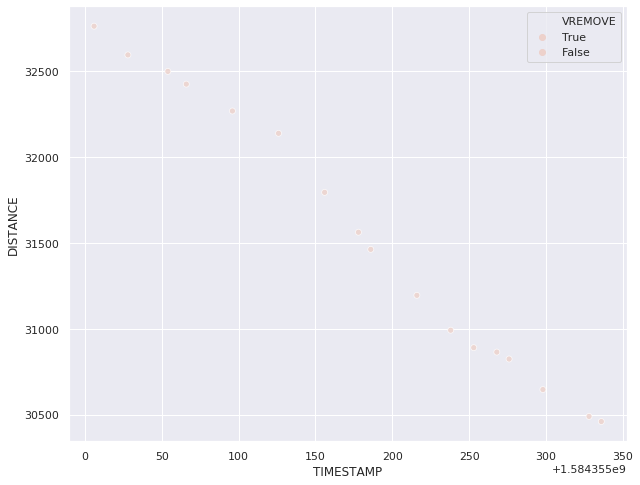

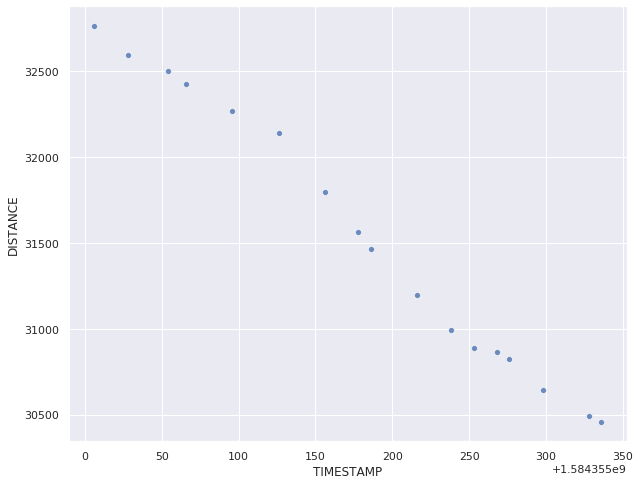

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 6 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


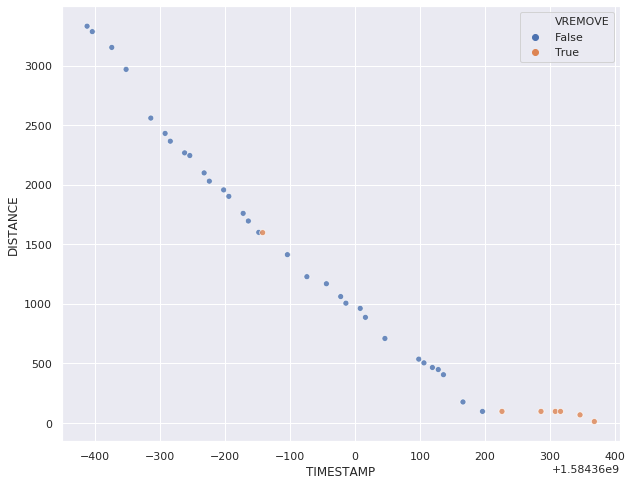

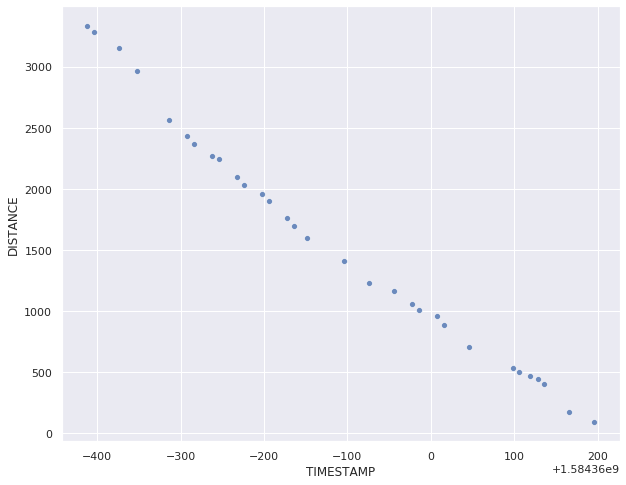

Shape after preprocessing (823, 39)
Predict for trips TRIPS00
There is no decrease distance


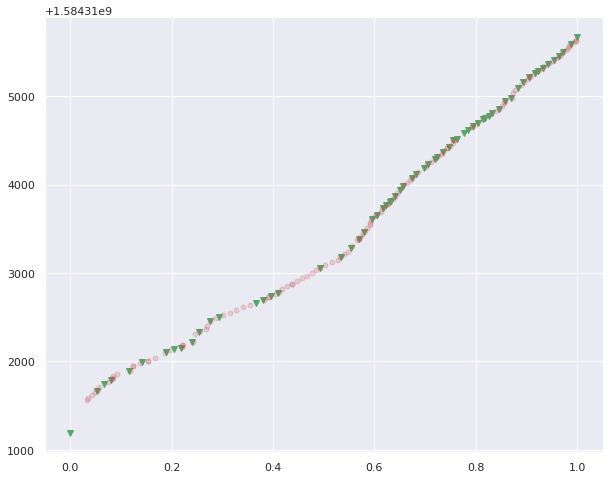

Predict for trips TRIPS01
There is no decrease distance


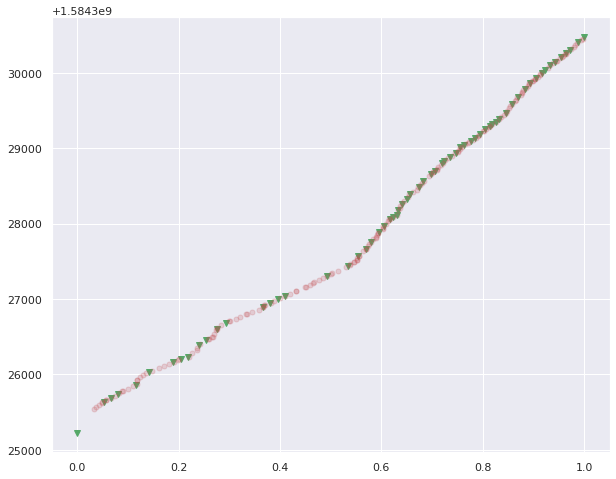

Predict for trips TRIPS02
There is no decrease distance


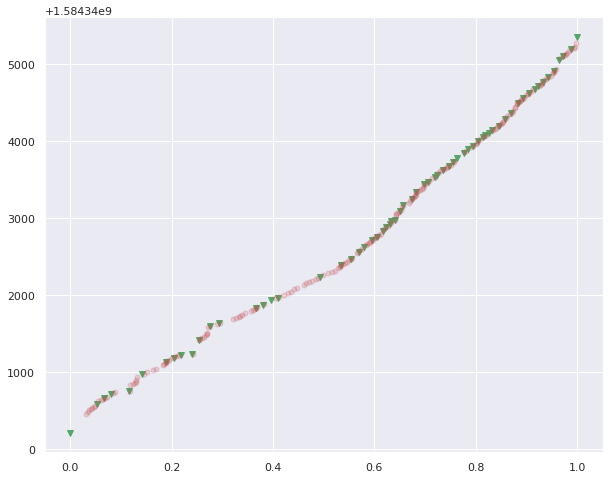

Predict for trips TRIPS03
There is no decrease distance


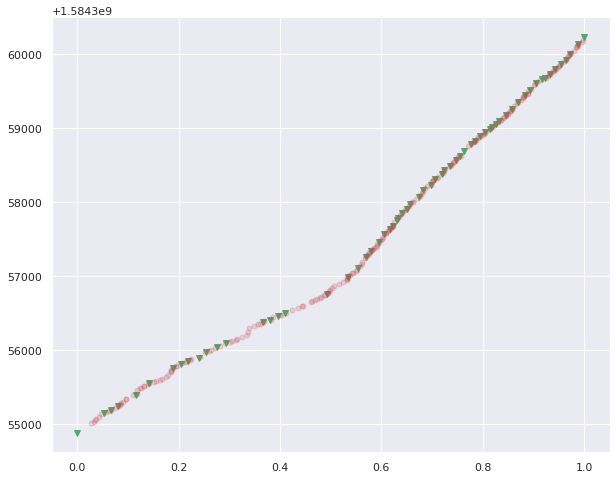

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Convert column name ARRIVETIMETRIPS03
Predic for bus 53N5053 with shape (2625, 35)
Length Time Tables: 3
There are 4 trips: TRIPS00, TRIPS01, TRIPS02, TRIPS03
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 32 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


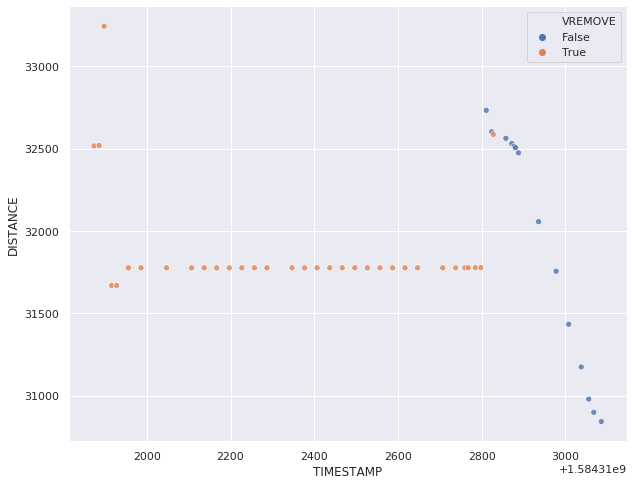

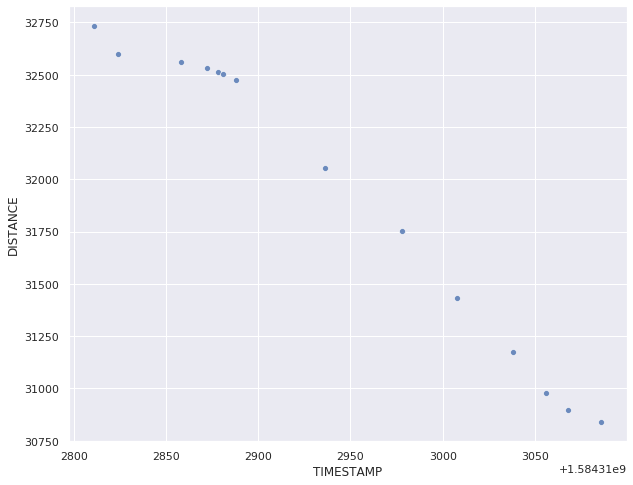

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 53 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


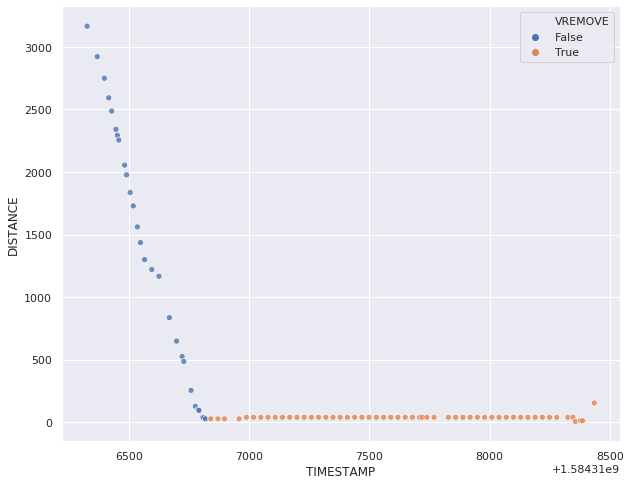

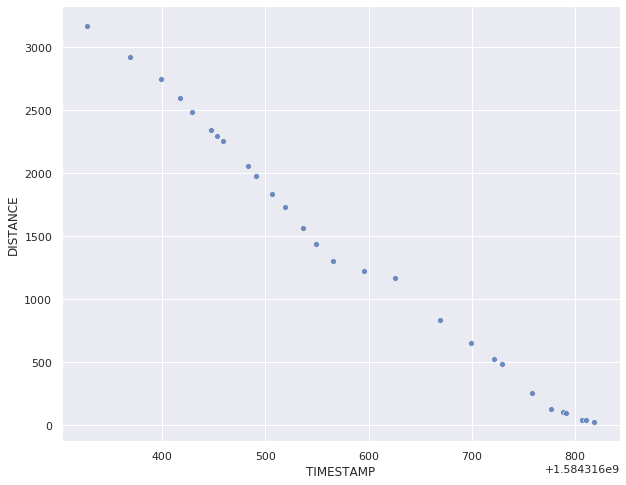

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


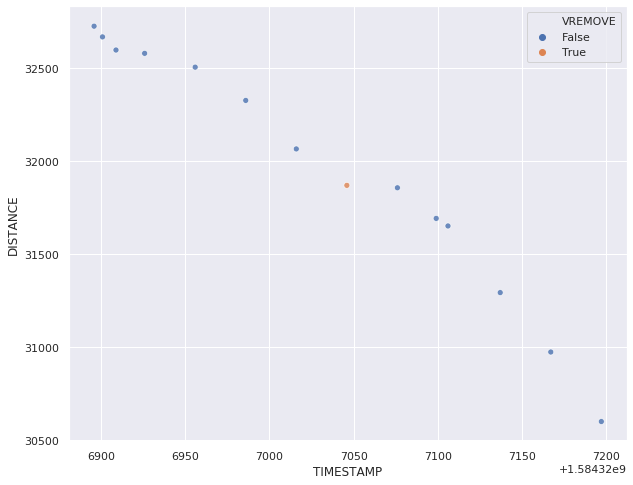

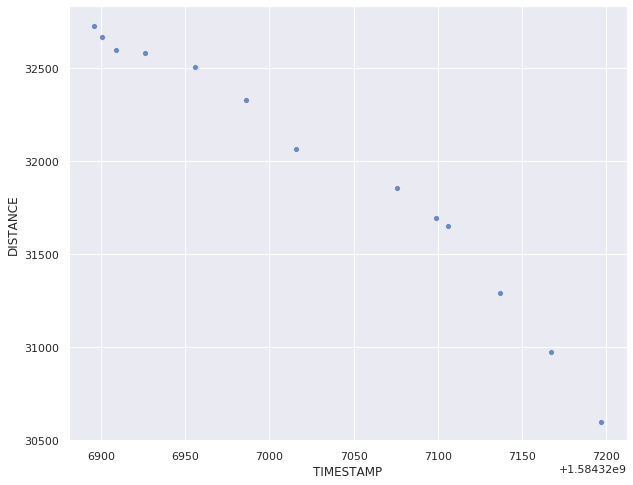

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 76 outlier.
Detected 2 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


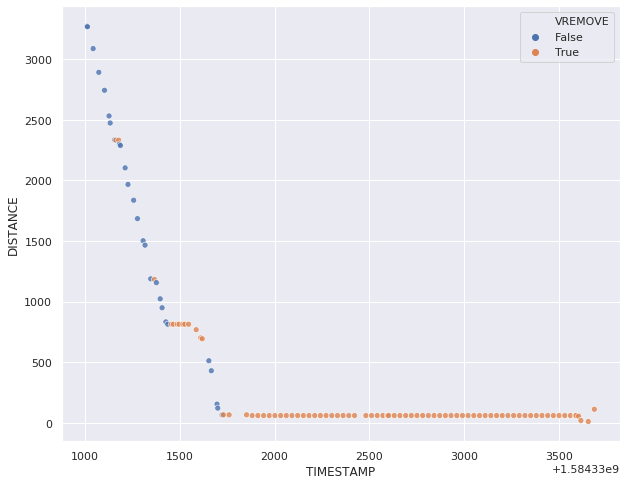

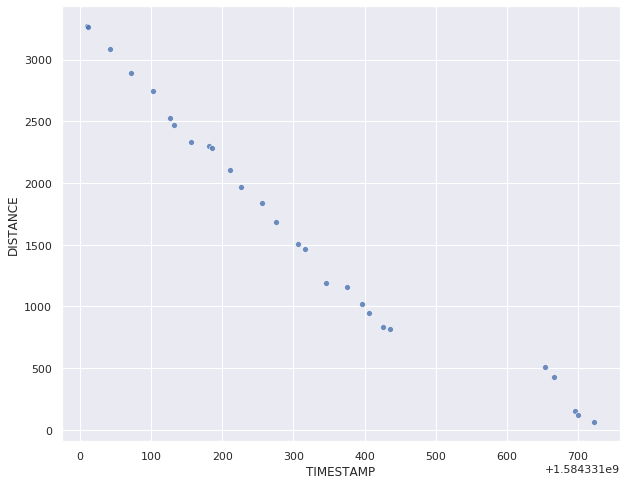

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 2 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


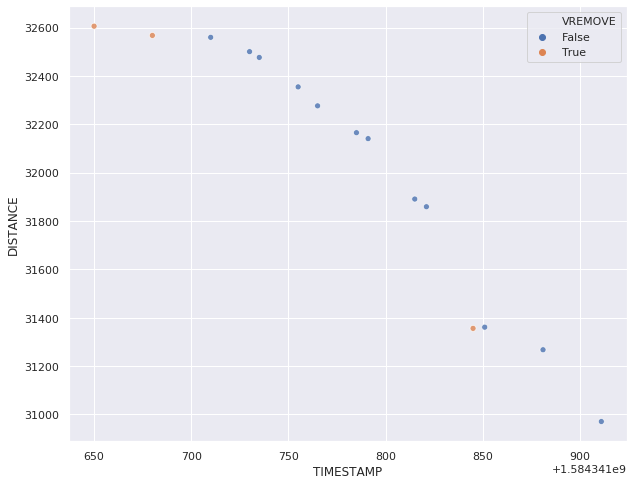

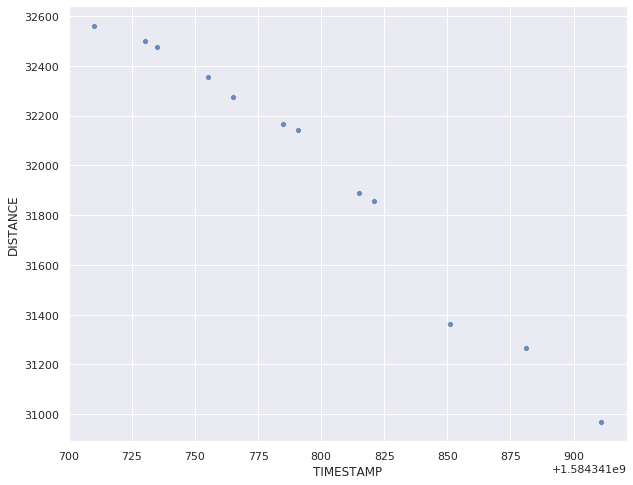

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 116 outlier.
Detected 0 outlier.
There is no outliers remain!


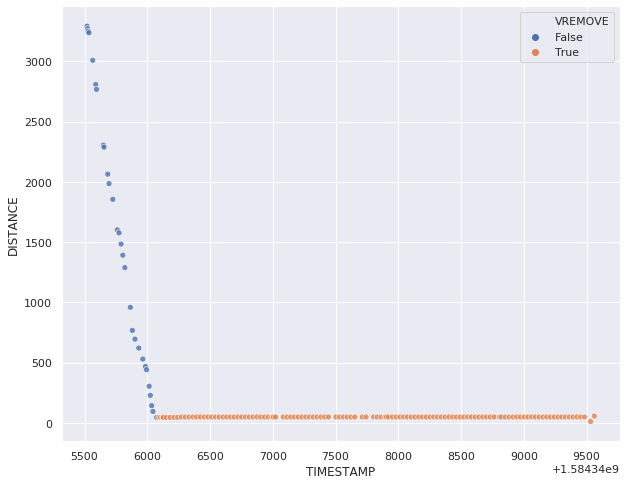

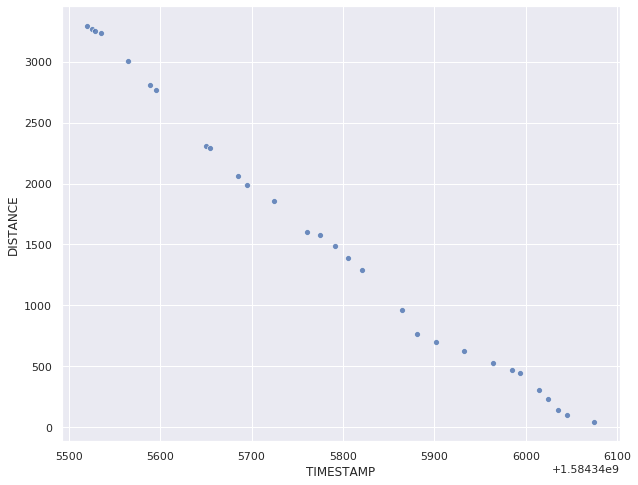

Remove outliers for trips: TRIPS03
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


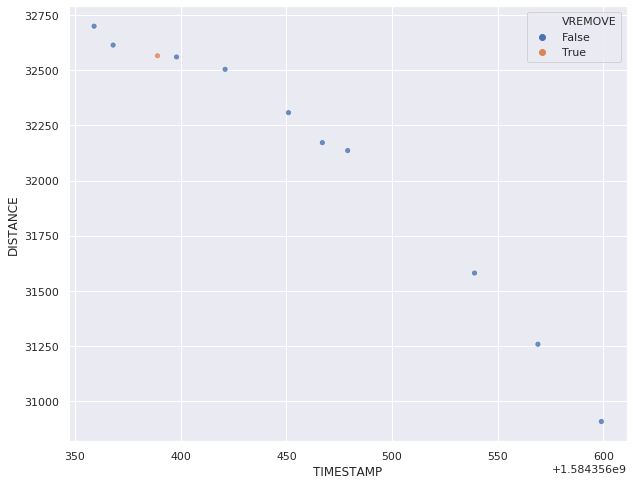

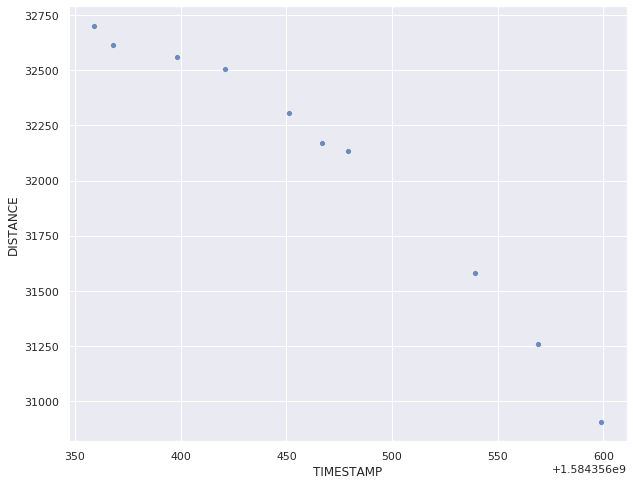

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 10 outlier.
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


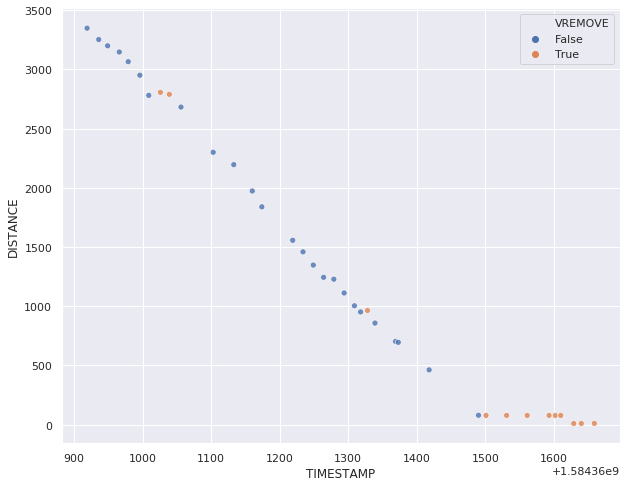

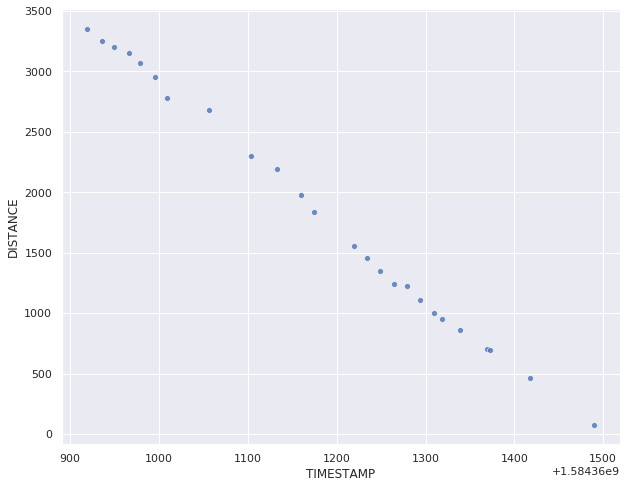

Shape after preprocessing (773, 39)
Predict for trips TRIPS00
There is no decrease distance


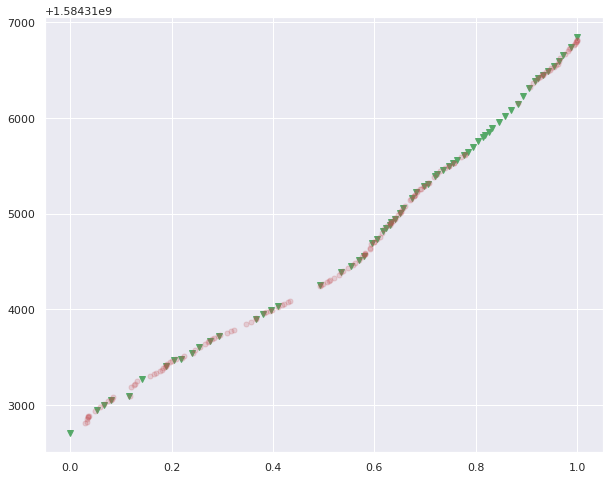

Predict for trips TRIPS01
There is no decrease distance


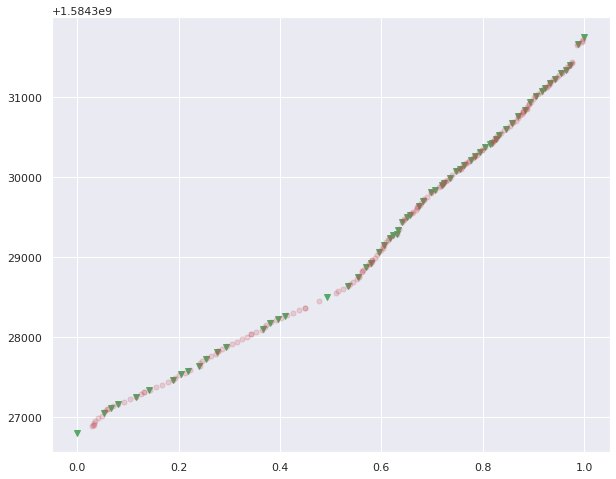

Predict for trips TRIPS02
There is no decrease distance


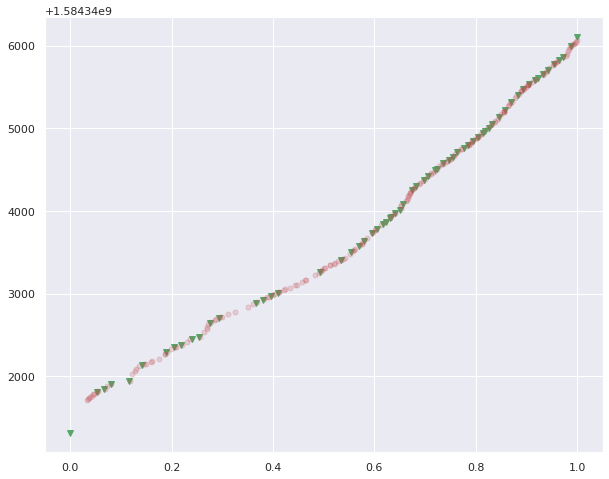

Predict for trips TRIPS03
There is no decrease distance


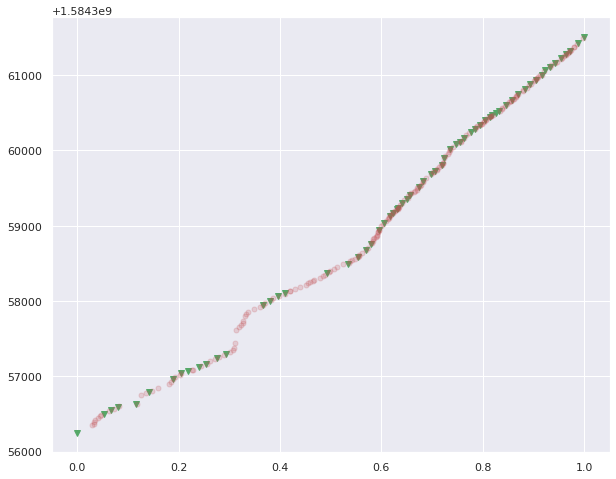

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Convert column name ARRIVETIMETRIPS03
Predic for bus 53N5013 with shape (2532, 35)
Length Time Tables: 4
There are 4 trips: TRIPS00, TRIPS01, TRIPS02, TRIPS03
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


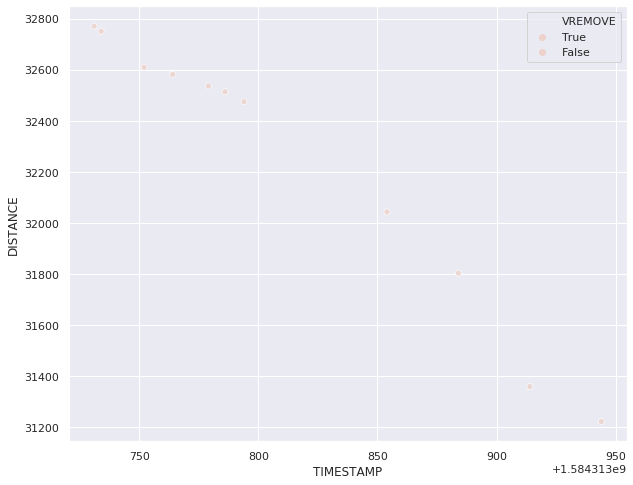

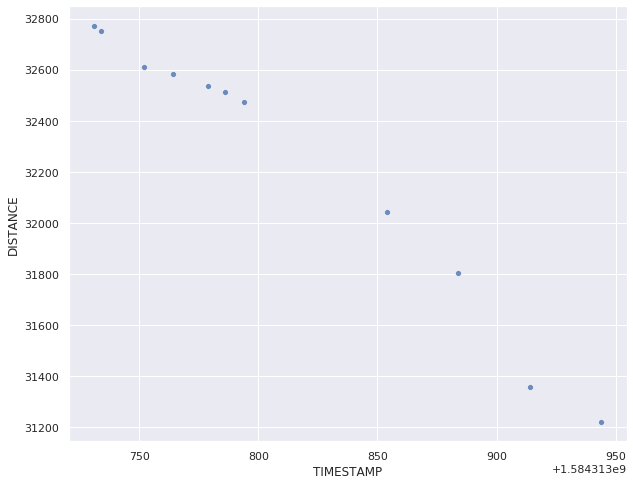

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 53 outlier.
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


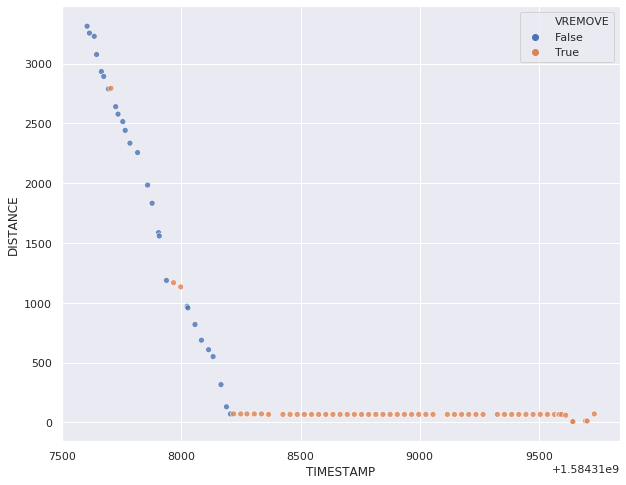

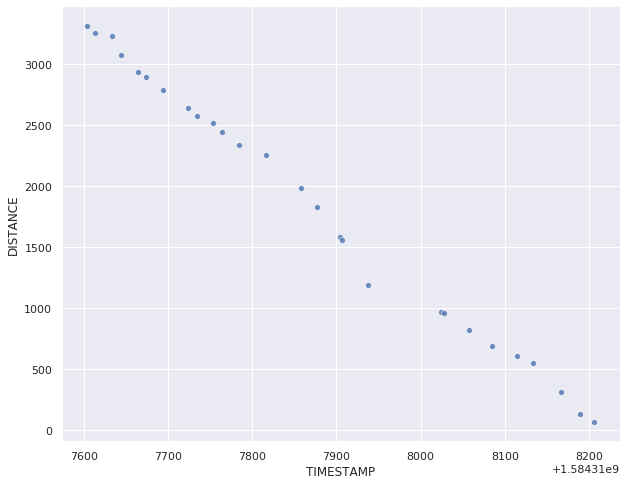

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


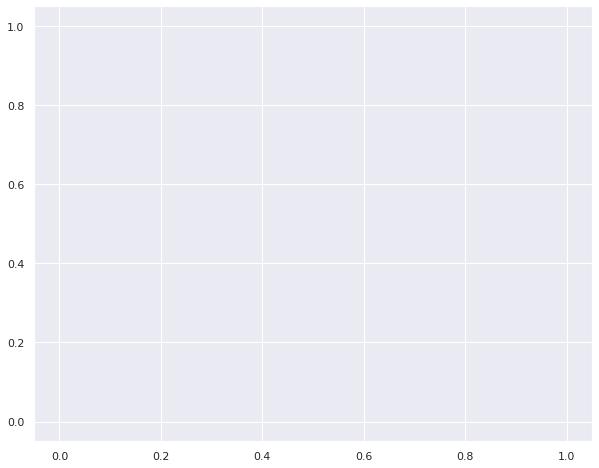

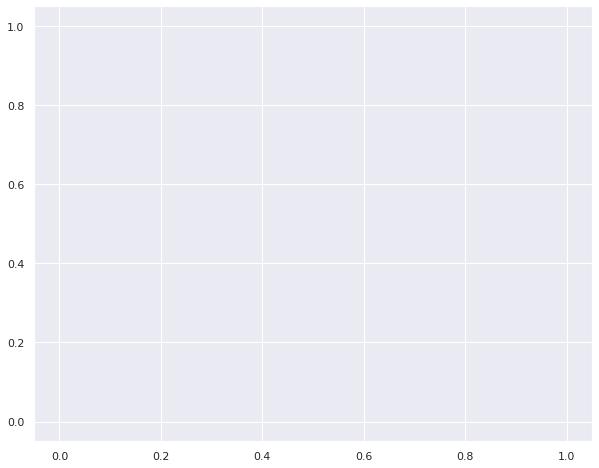

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 78 outlier.
Detected 0 outlier.
There is no outliers remain!


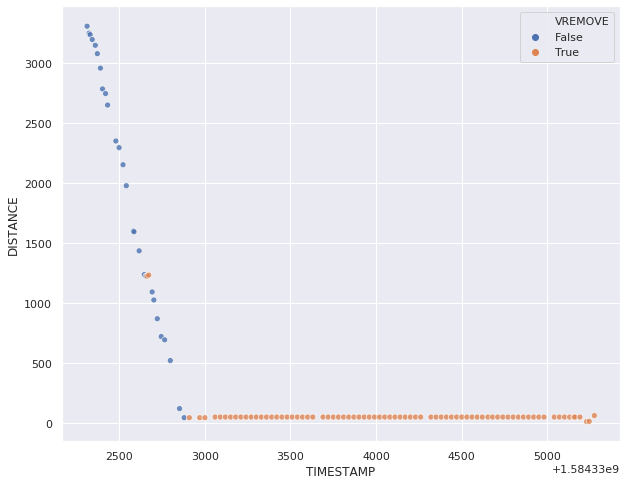

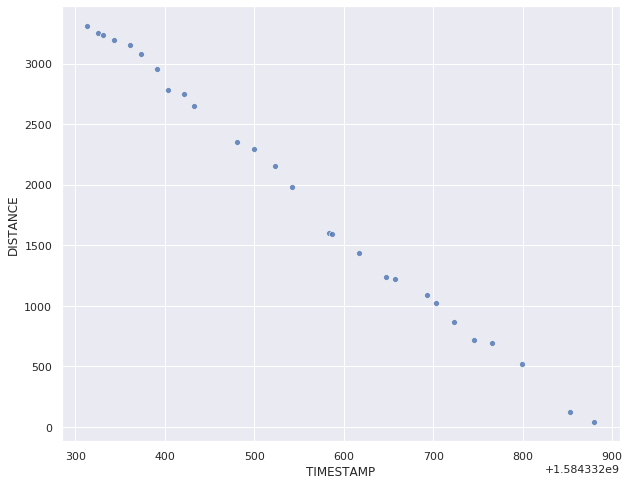

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


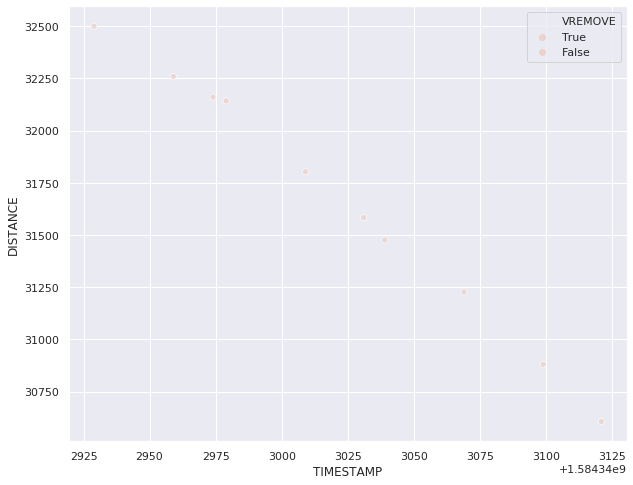

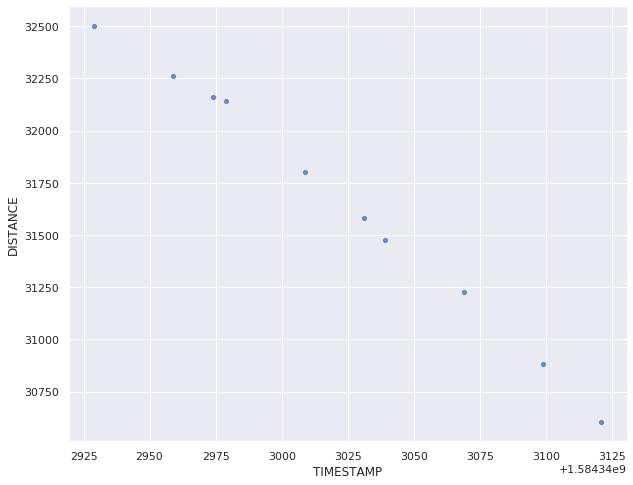

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 94 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


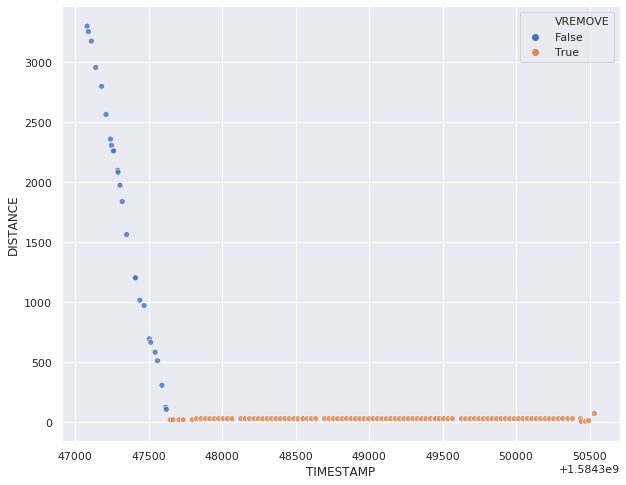

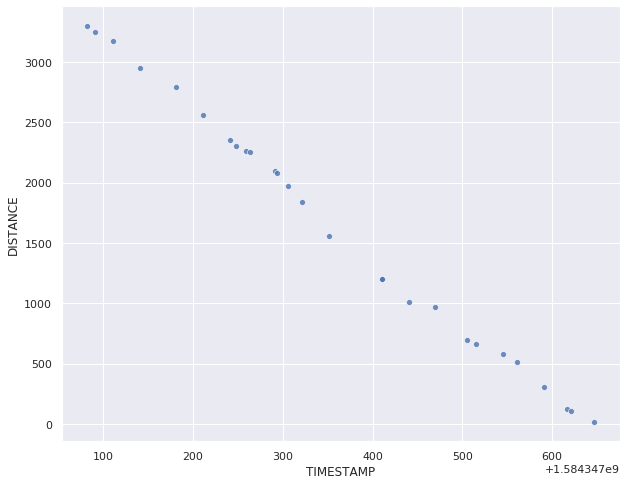

Remove outliers for trips: TRIPS03
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 4 outlier.
Detected 0 outlier.
There is no outliers remain!


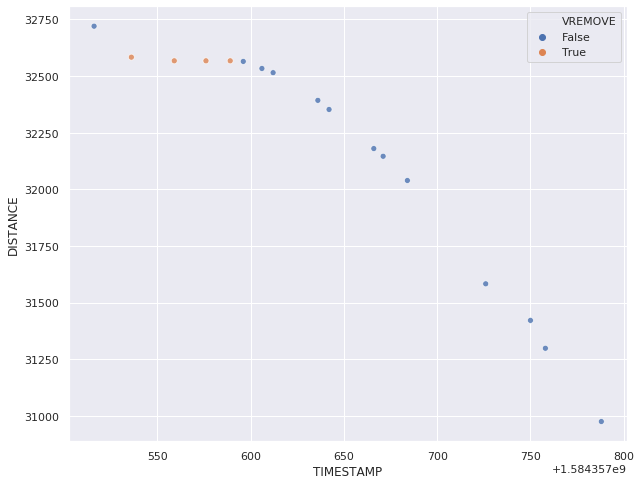

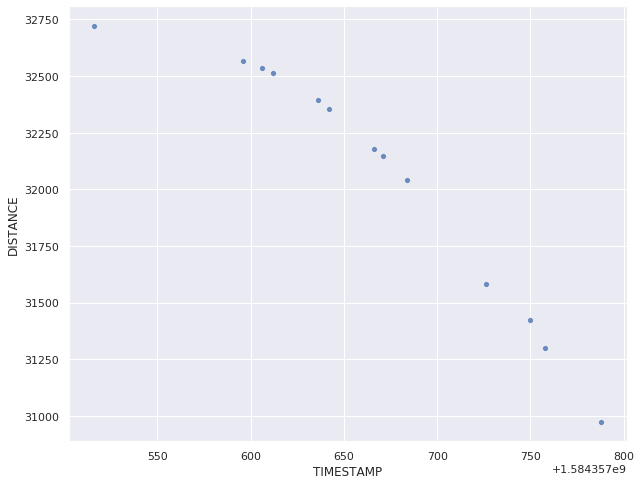

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 7 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


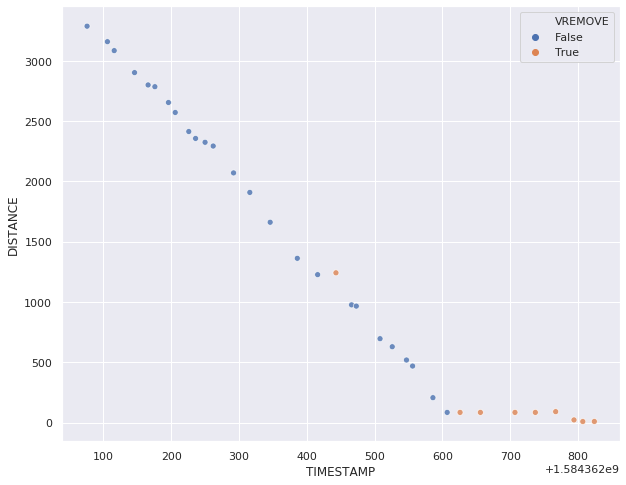

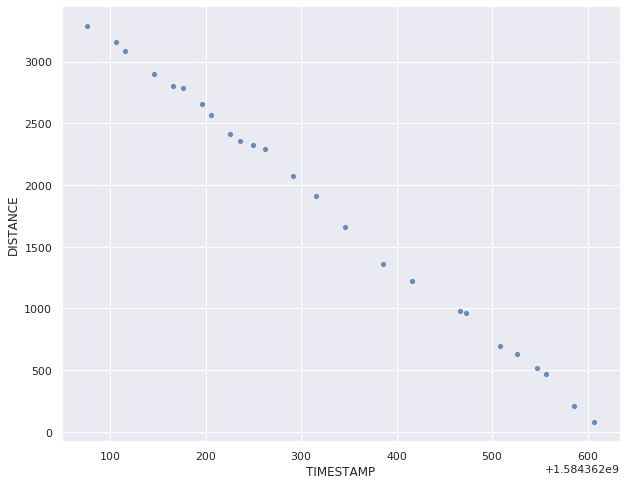

Shape after preprocessing (832, 39)
Predict for trips TRIPS00
There is no decrease distance


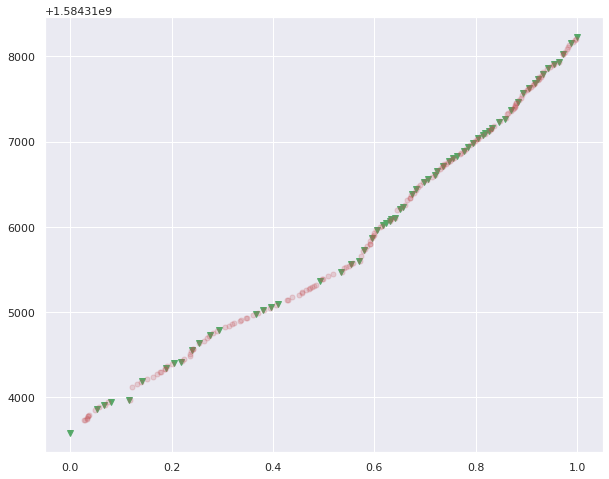

Predict for trips TRIPS01
There is no decrease distance


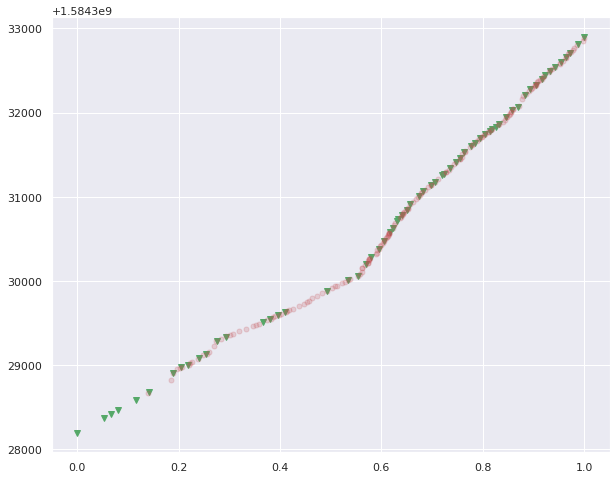

Predict for trips TRIPS02
There is no decrease distance


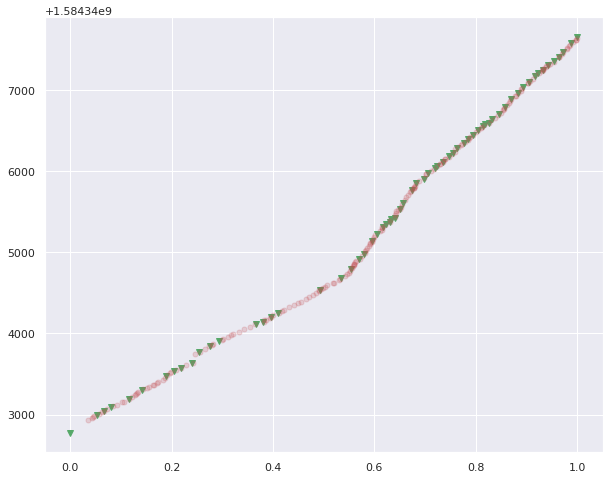

Predict for trips TRIPS03
There is no decrease distance


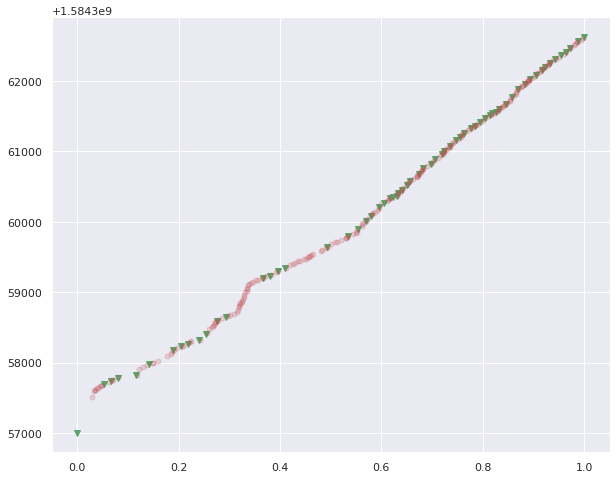

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Convert column name ARRIVETIMETRIPS03
Predic for bus 51B31288 with shape (2613, 35)
Length Time Tables: 5
There are 4 trips: TRIPS00, TRIPS01, TRIPS02, TRIPS03
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


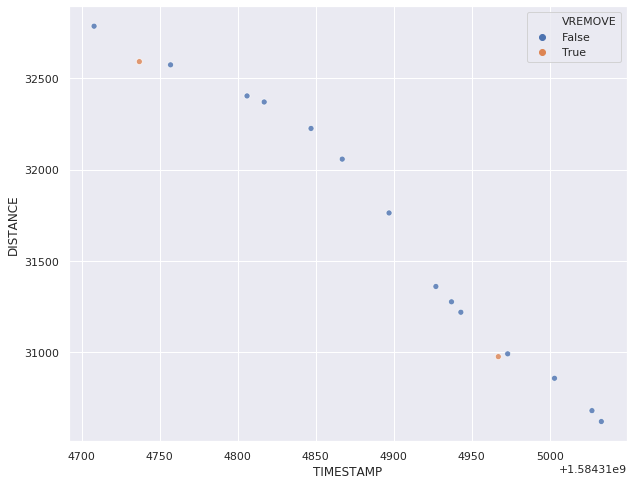

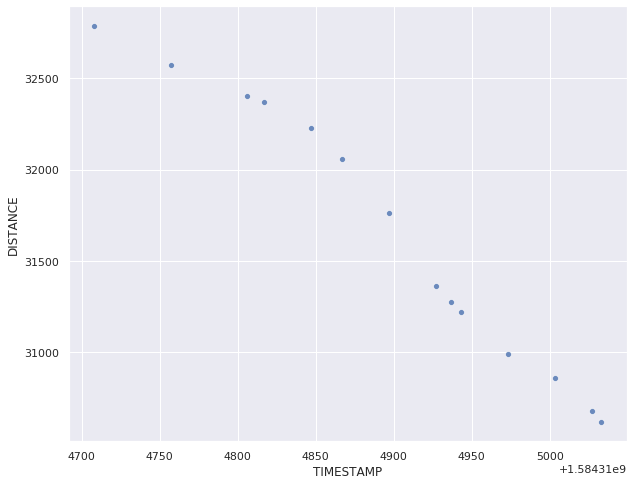

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 48 outlier.
Detected 0 outlier.
There is no outliers remain!


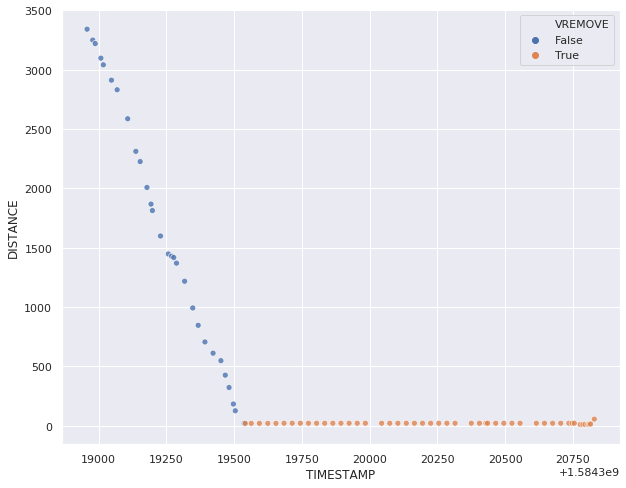

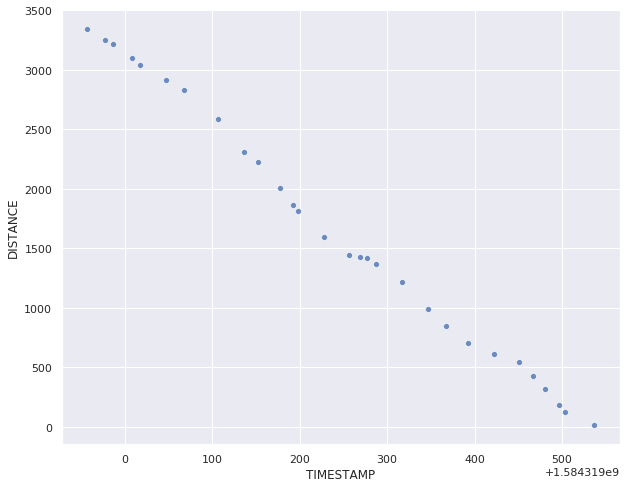

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


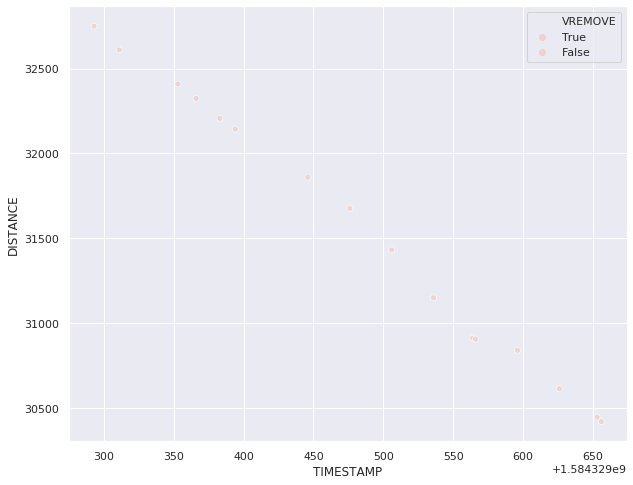

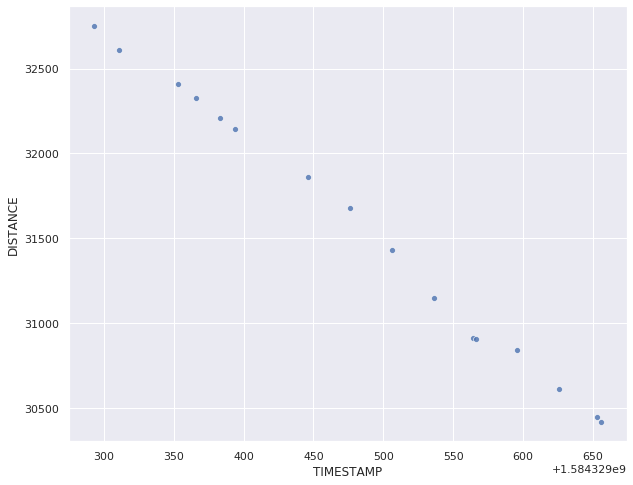

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 87 outlier.
Detected 0 outlier.
There is no outliers remain!


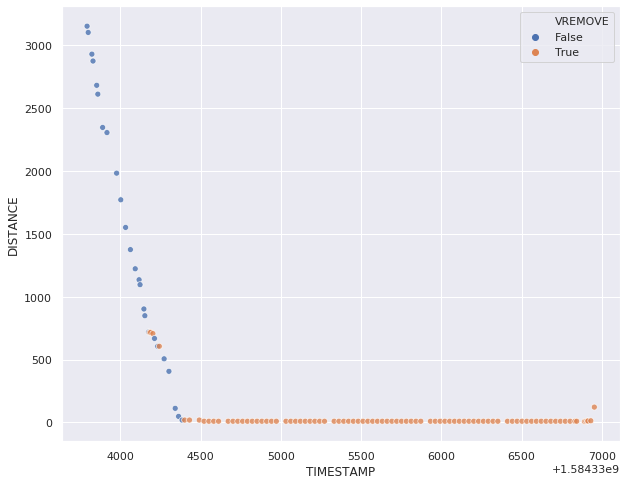

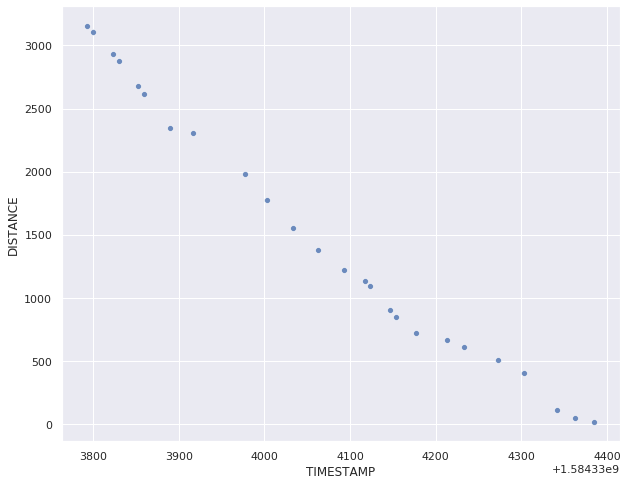

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


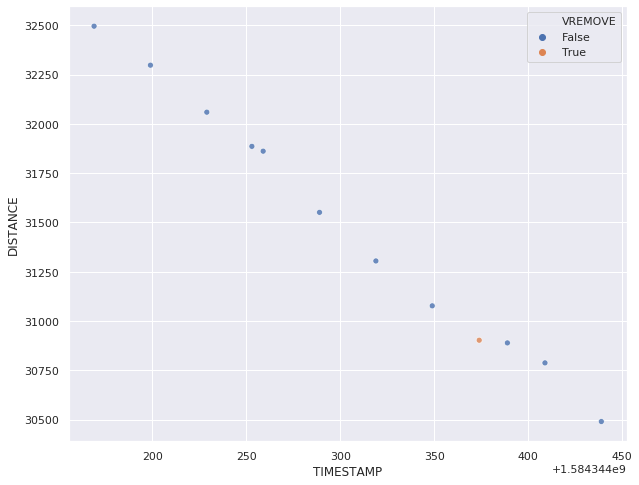

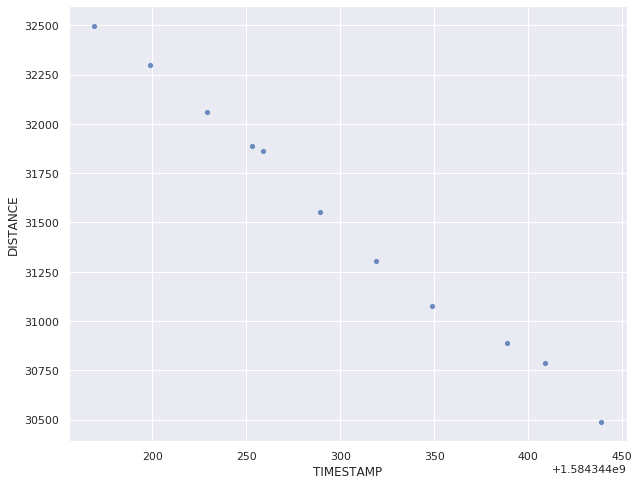

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 93 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


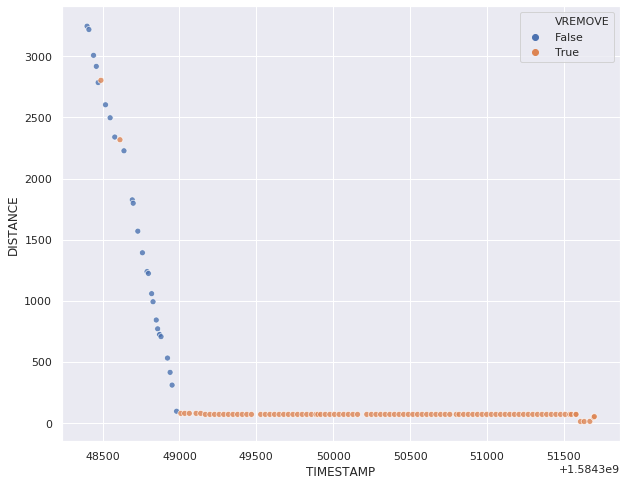

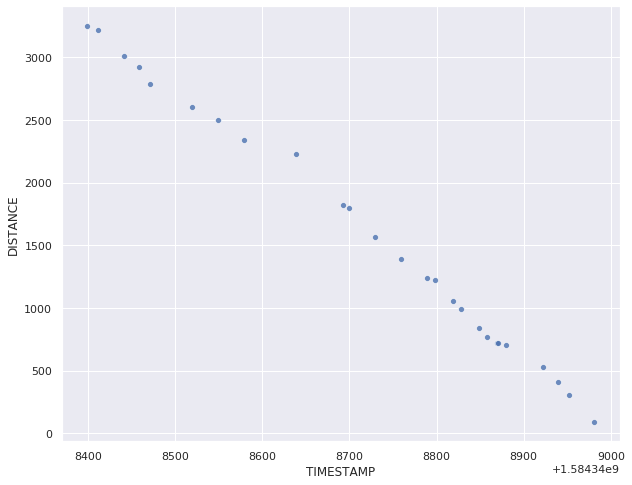

Remove outliers for trips: TRIPS03
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


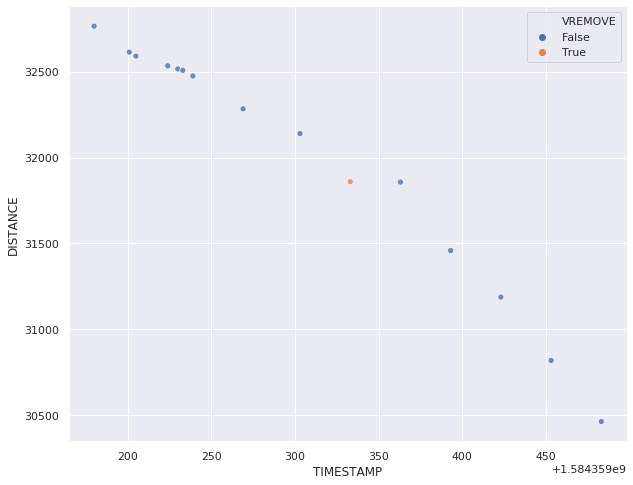

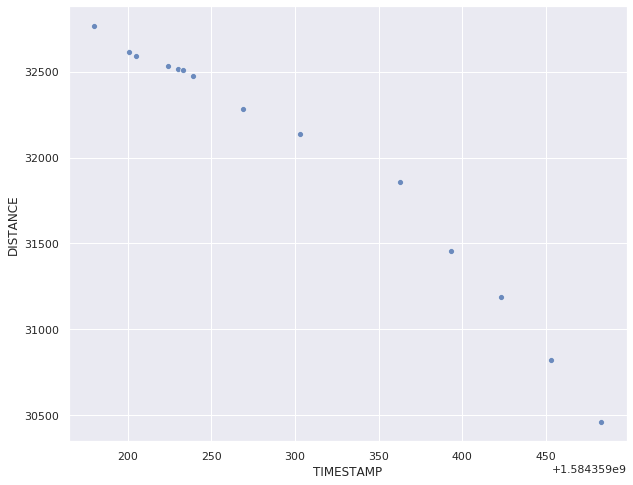

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 3 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


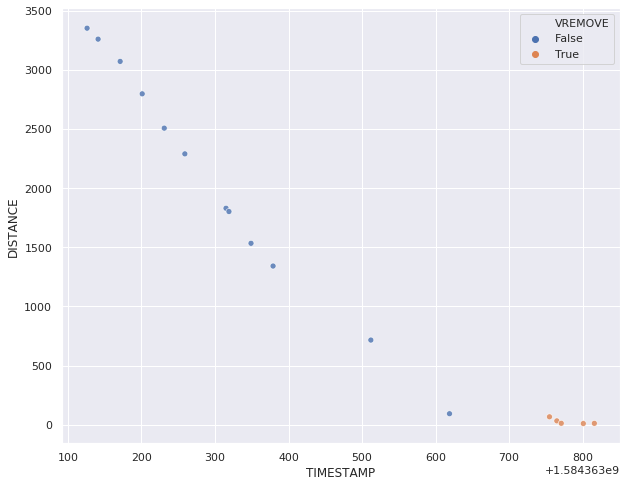

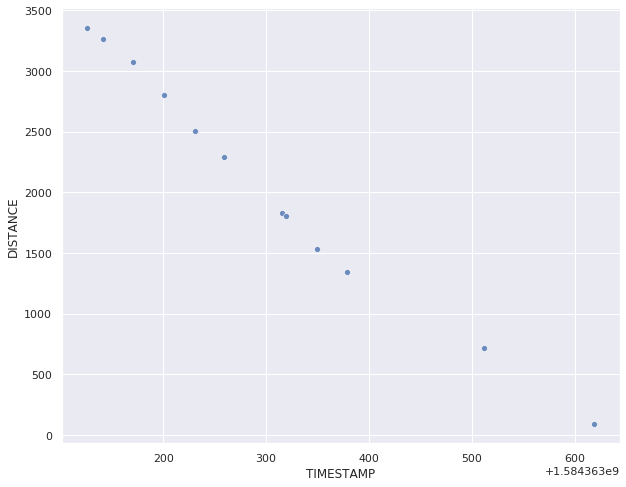

Shape after preprocessing (847, 39)
Predict for trips TRIPS00
There is no decrease distance


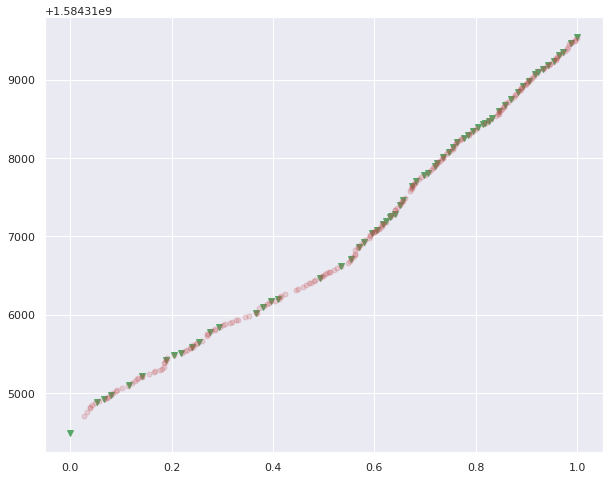

Predict for trips TRIPS01
There is no decrease distance


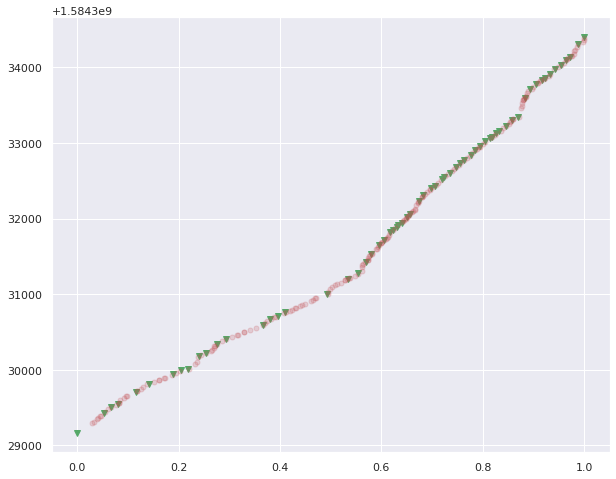

Predict for trips TRIPS02
There is no decrease distance


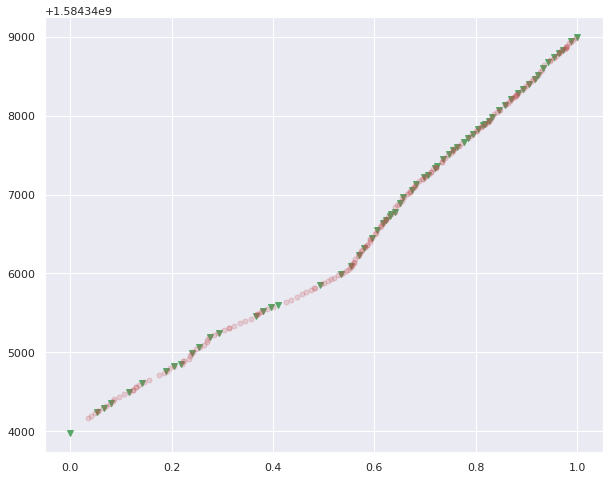

Predict for trips TRIPS03
There is no decrease distance


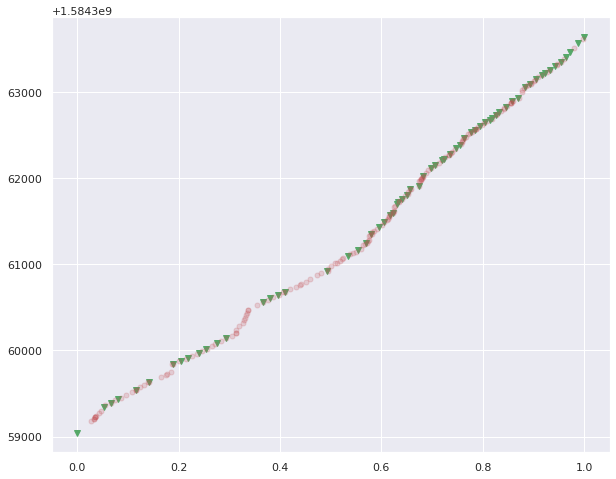

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Convert column name ARRIVETIMETRIPS03
Predic for bus 53N4917 with shape (3208, 35)
Length Time Tables: 6
There are 4 trips: TRIPS00, TRIPS01, TRIPS02, TRIPS03
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


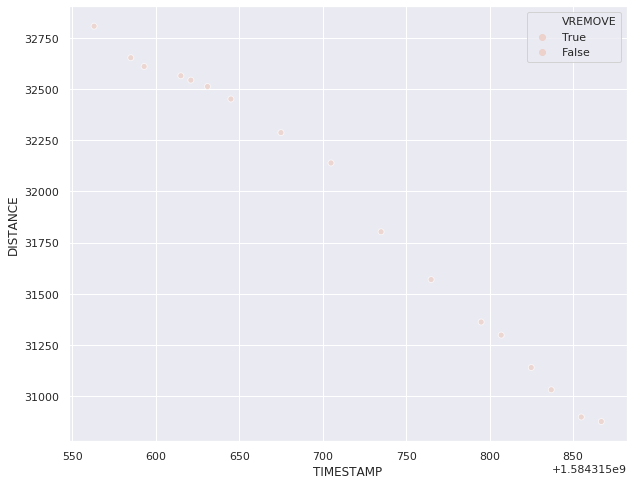

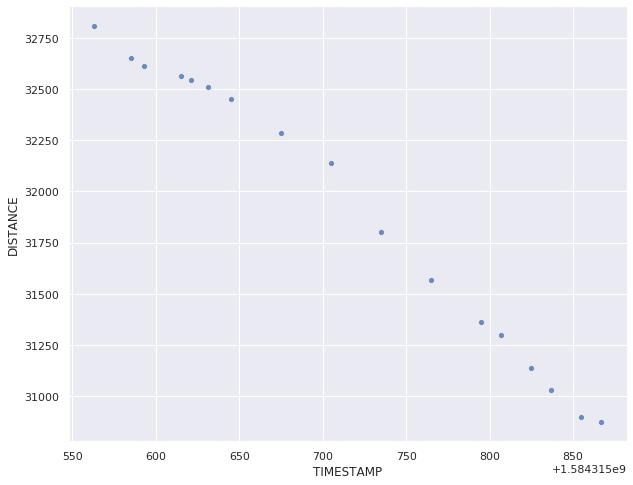

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 40 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


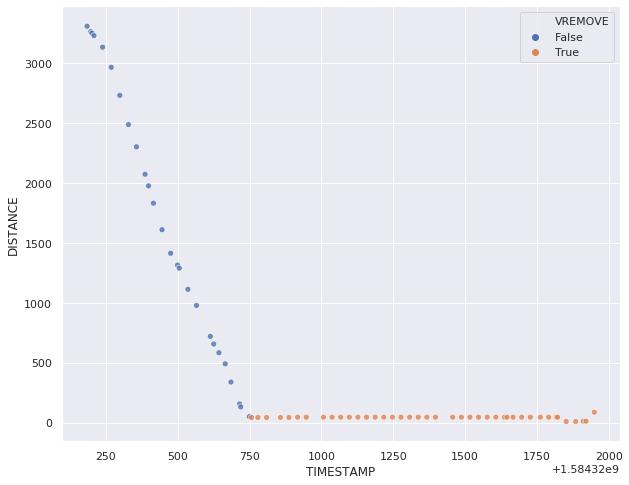

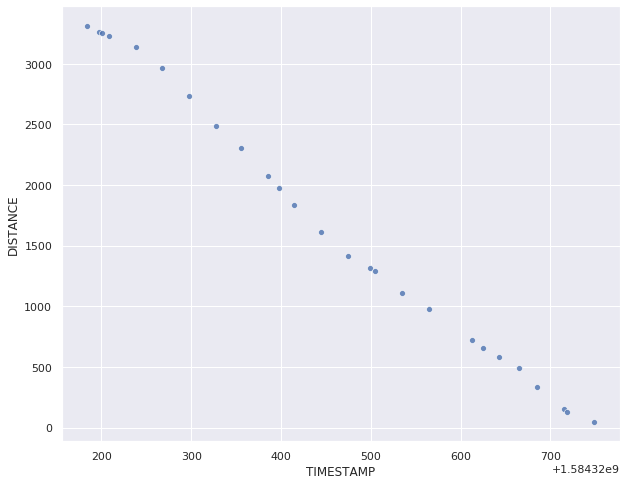

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


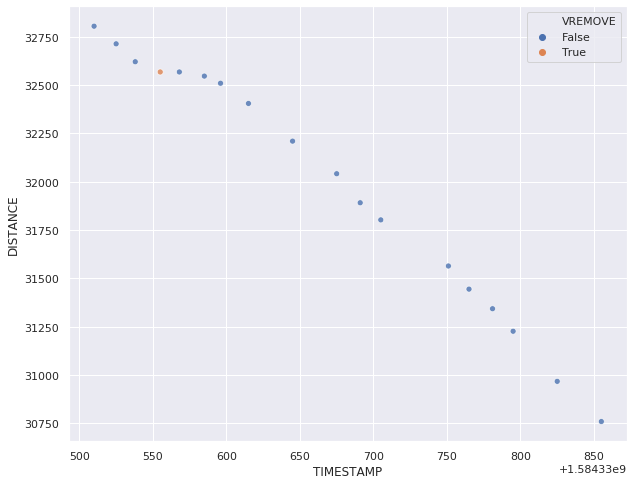

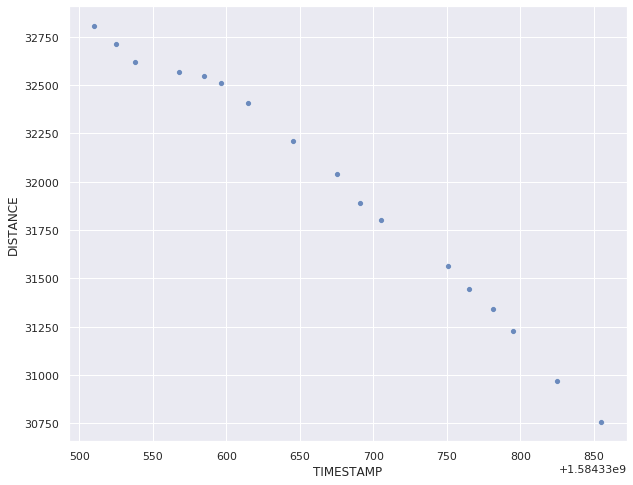

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 67 outlier.
Detected 0 outlier.
There is no outliers remain!


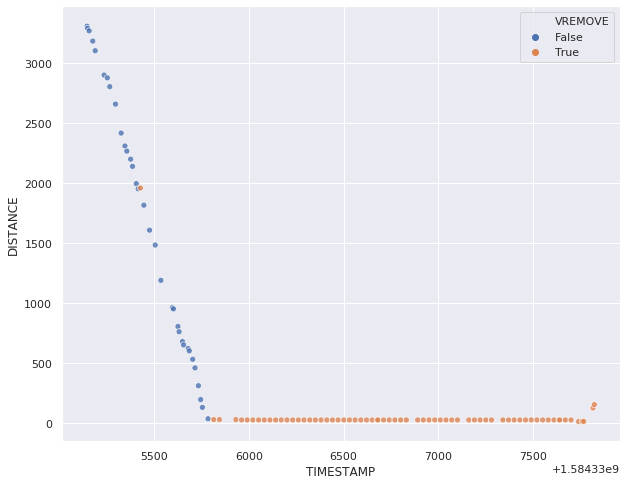

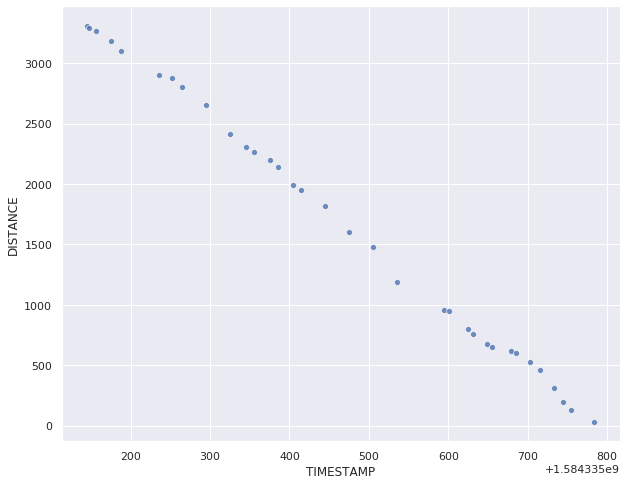

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


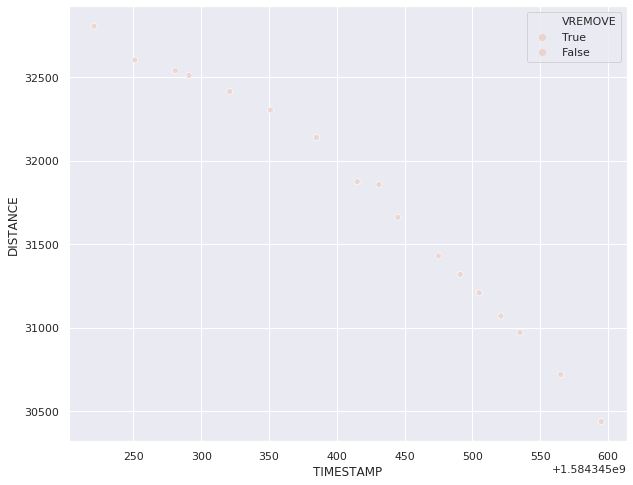

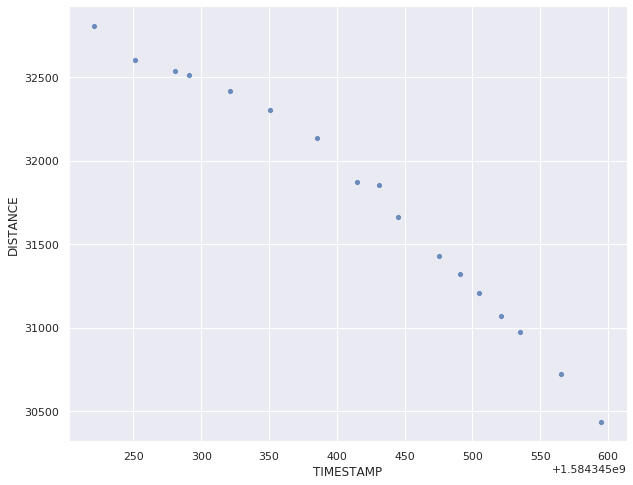

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 80 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


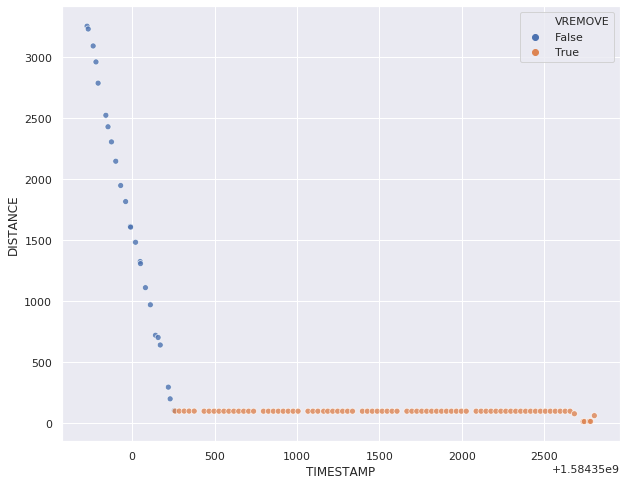

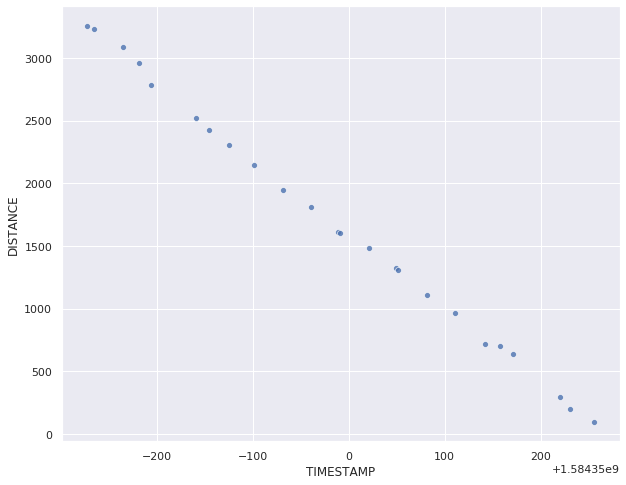

Remove outliers for trips: TRIPS03
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


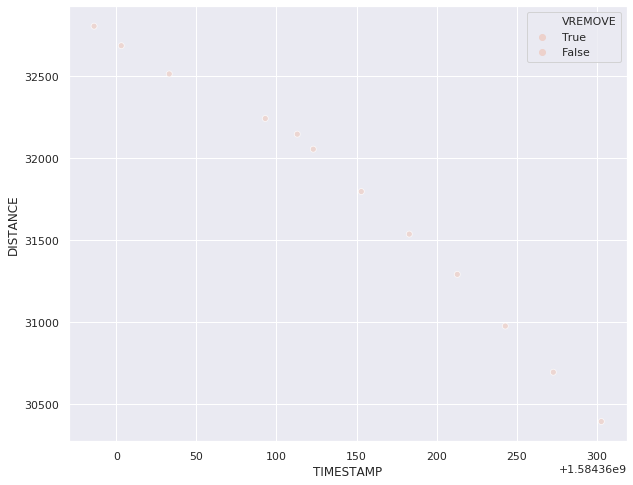

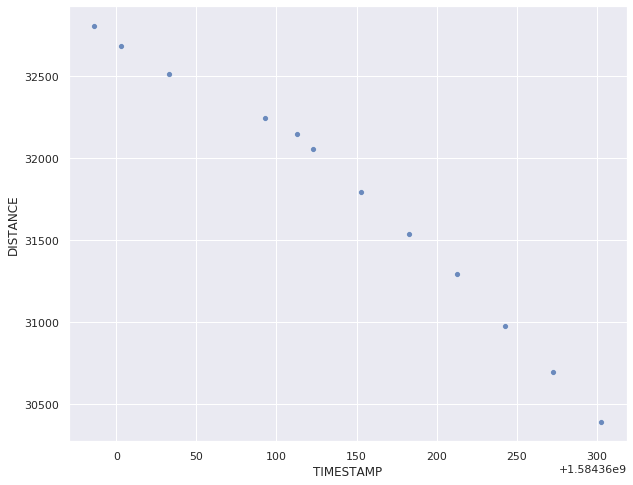

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 8 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


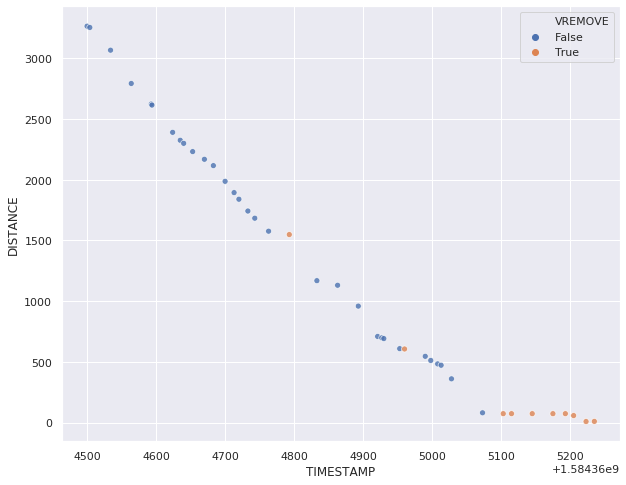

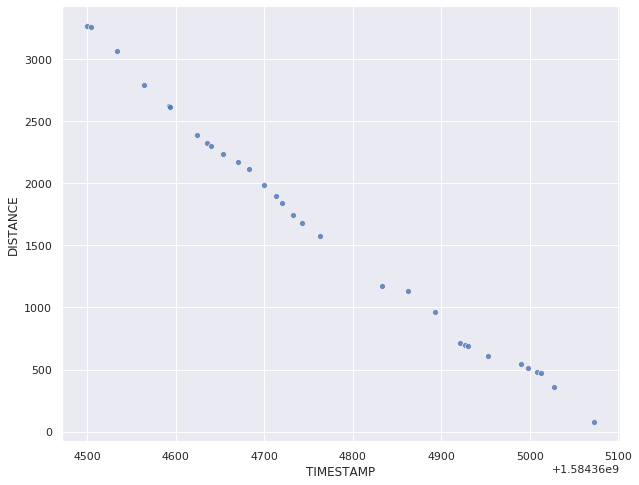

Shape after preprocessing (927, 39)
Predict for trips TRIPS00
There is no decrease distance


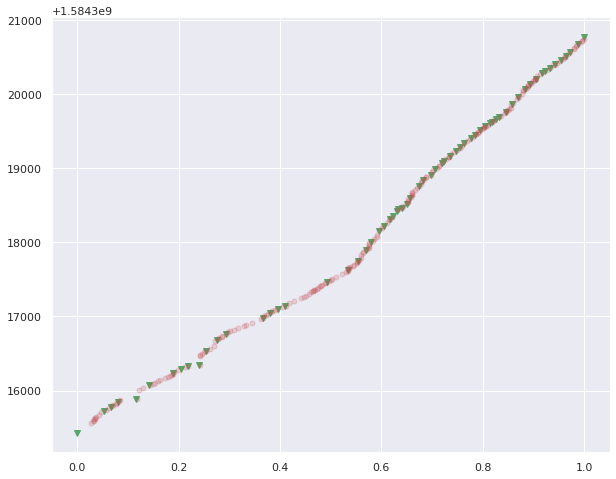

Predict for trips TRIPS01
There is no decrease distance


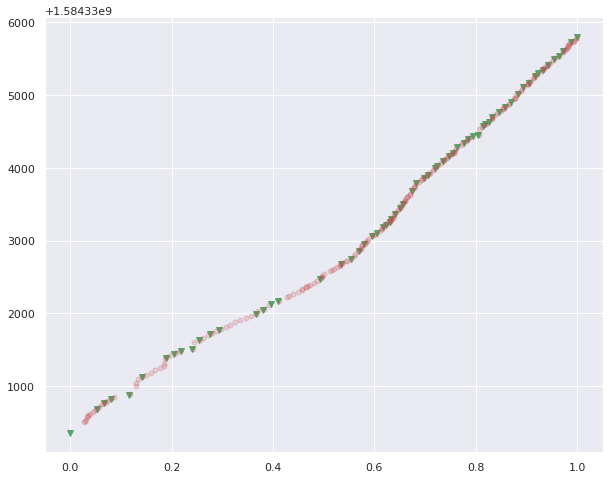

Predict for trips TRIPS02
There is no decrease distance


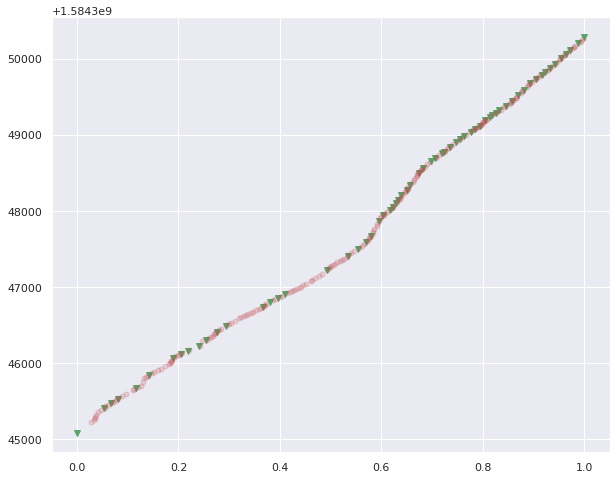

Predict for trips TRIPS03
There is no decrease distance


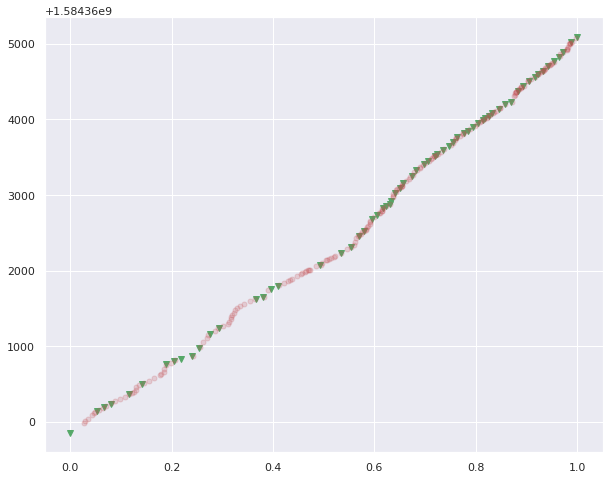

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Convert column name ARRIVETIMETRIPS03
Predic for bus 51B28892 with shape (2275, 35)
Length Time Tables: 7
There are 3 trips: TRIPS00, TRIPS01, TRIPS02
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 5 outlier.
Detected 0 outlier.
There is no outliers remain!


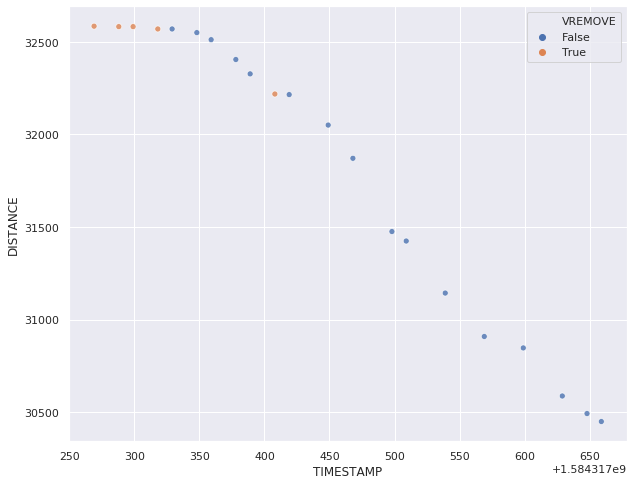

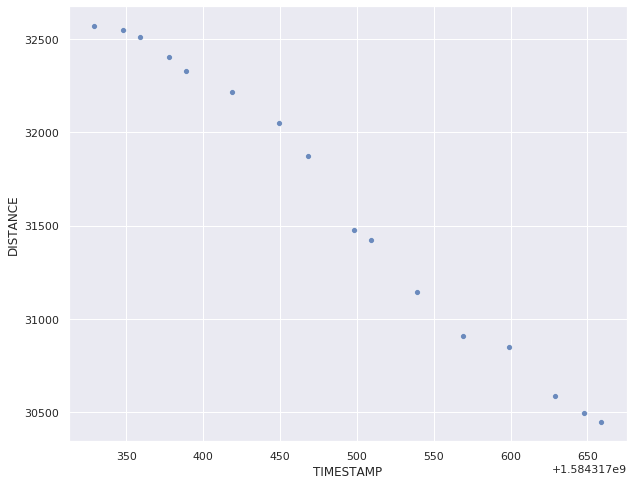

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 62 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


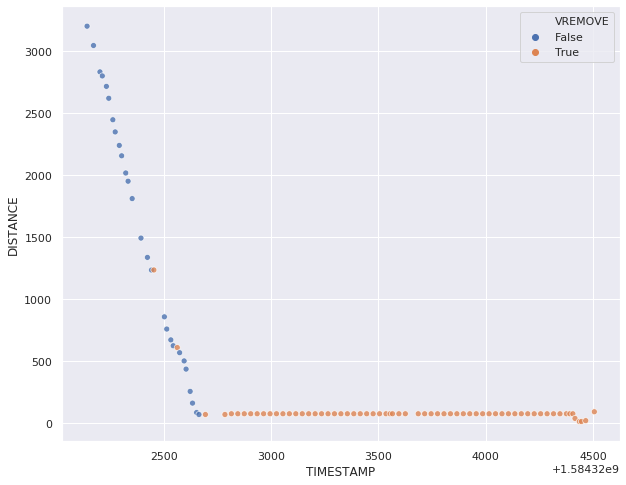

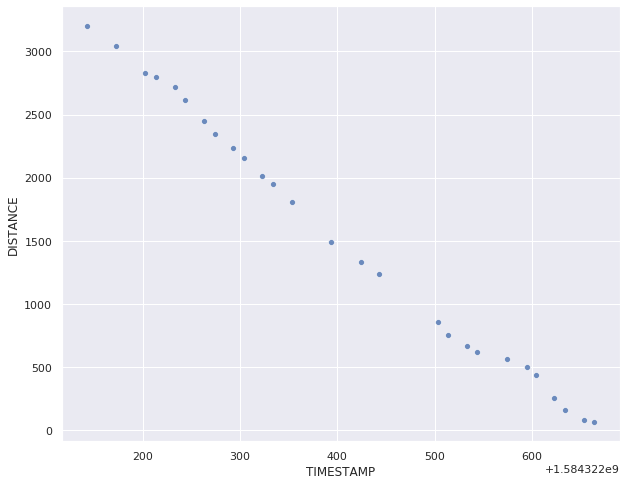

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 2 outlier.
Detected 0 outlier.
There is no outliers remain!


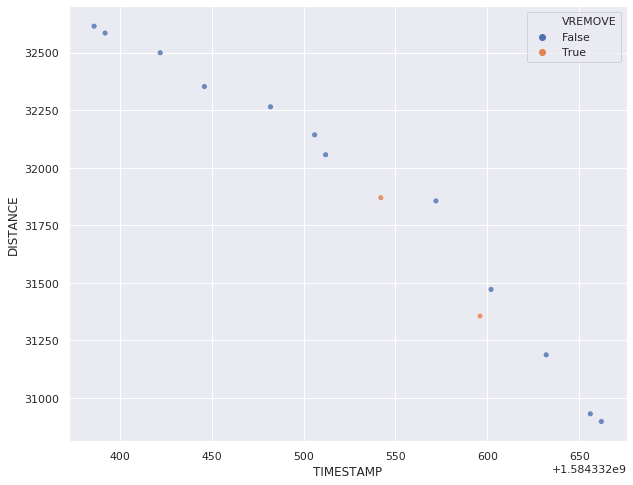

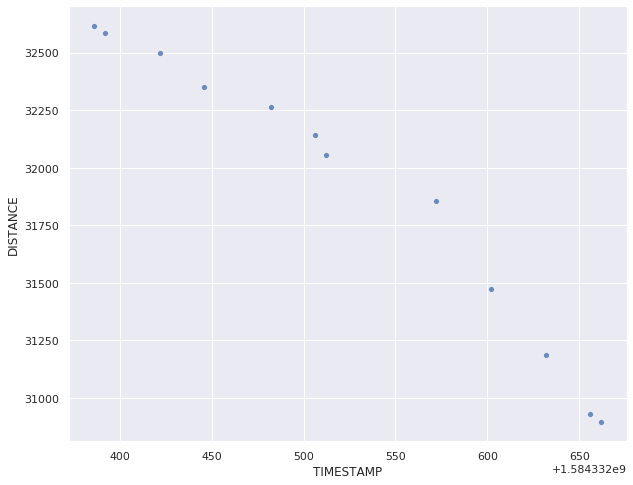

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 112 outlier.
Detected 0 outlier.
There is no outliers remain!


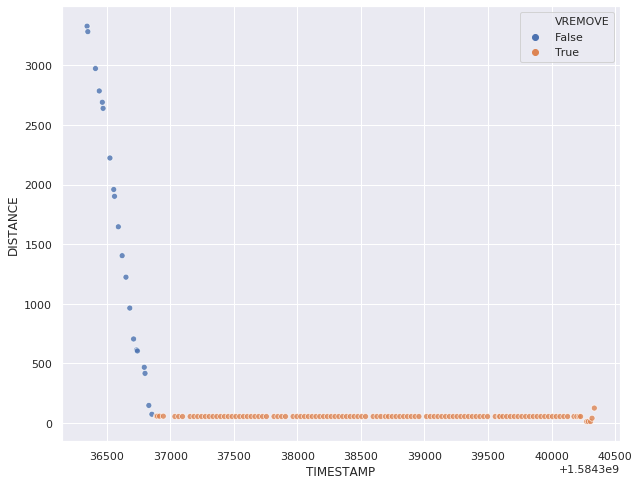

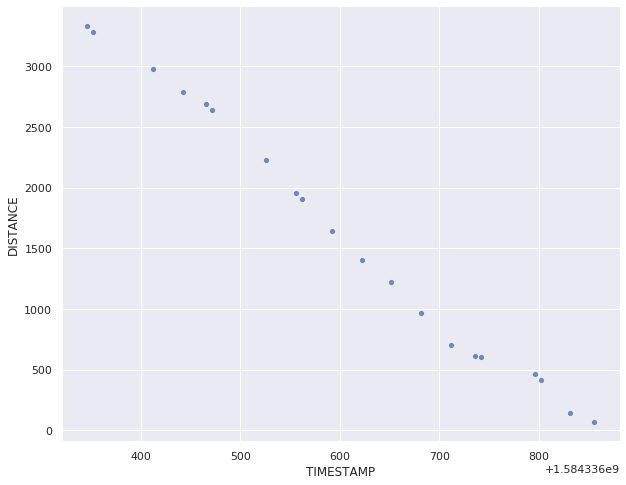

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


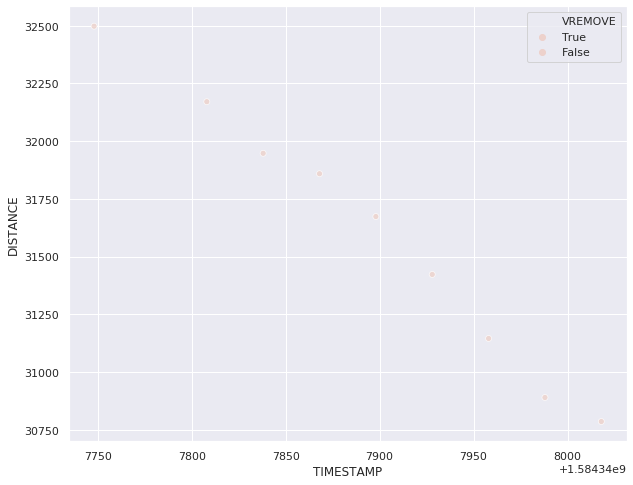

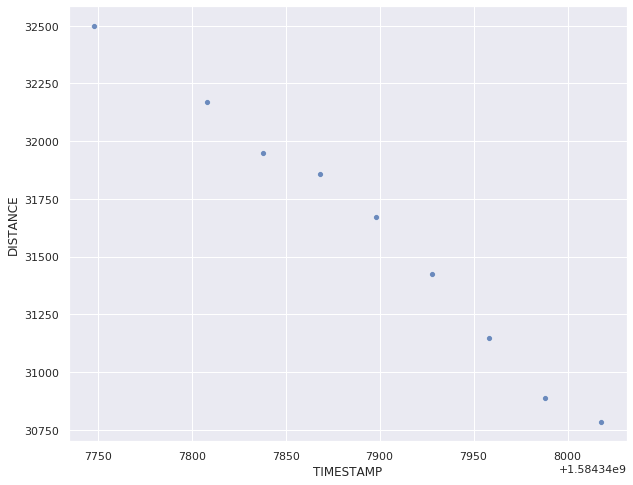

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 101 outlier.
Detected 0 outlier.
There is no outliers remain!


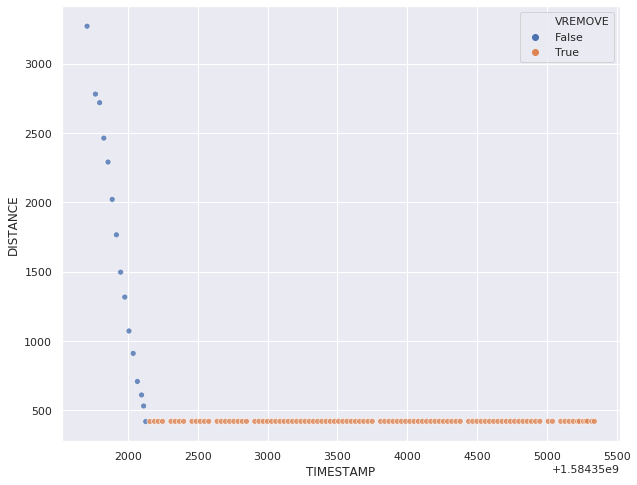

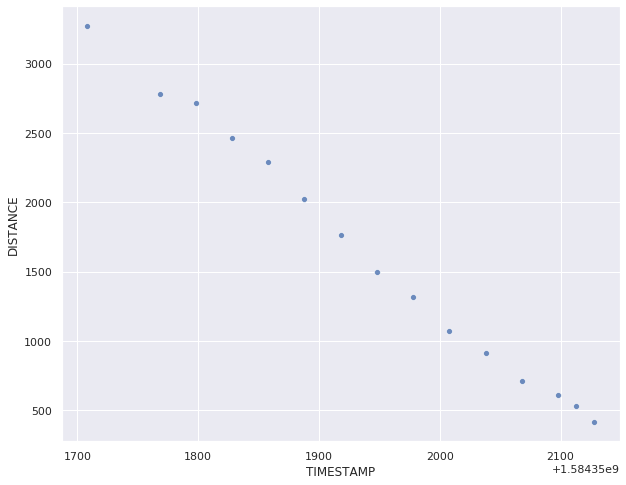

Shape after preprocessing (574, 39)
Predict for trips TRIPS00
There is no decrease distance


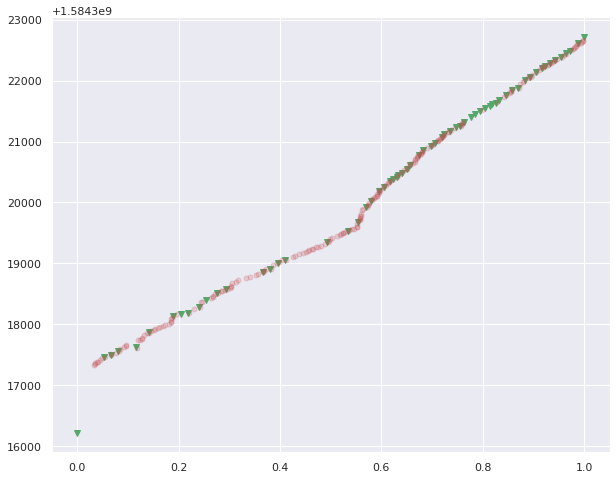

Predict for trips TRIPS01
There is no decrease distance


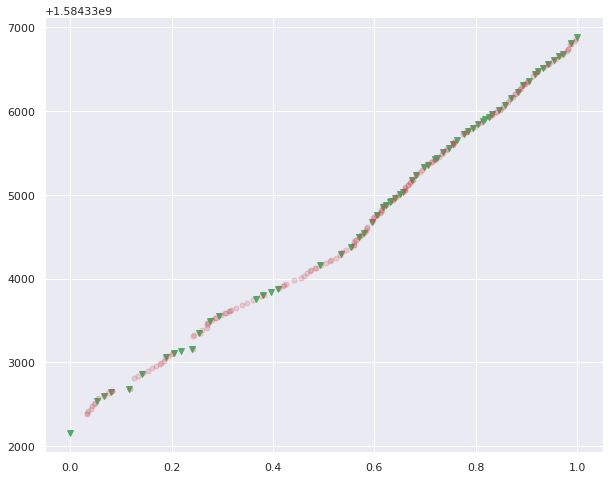

Predict for trips TRIPS02
There is no decrease distance


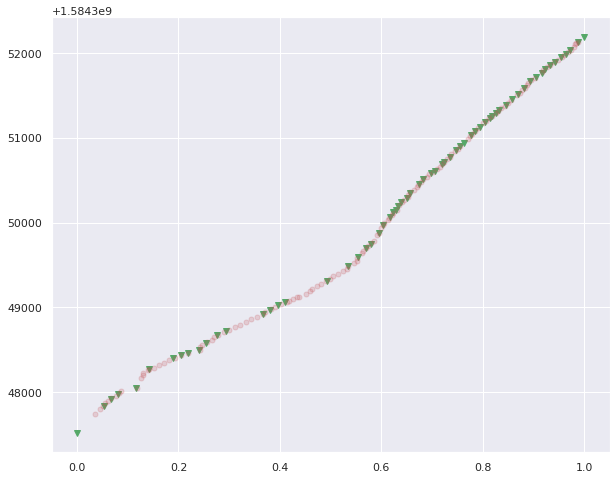

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Predic for bus 51B31233 with shape (2316, 35)
Length Time Tables: 8
There are 3 trips: TRIPS00, TRIPS01, TRIPS02
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


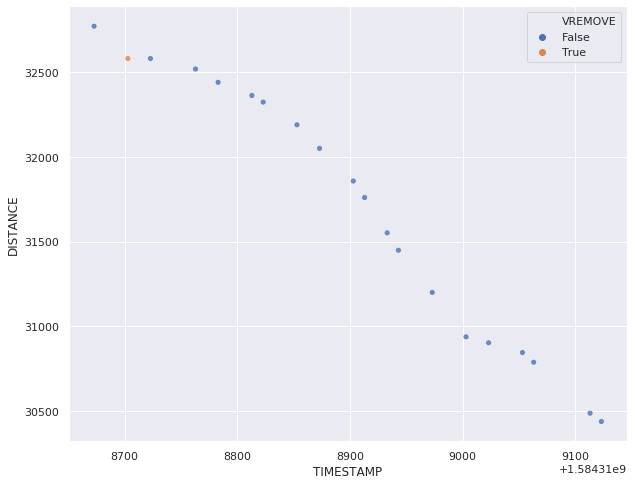

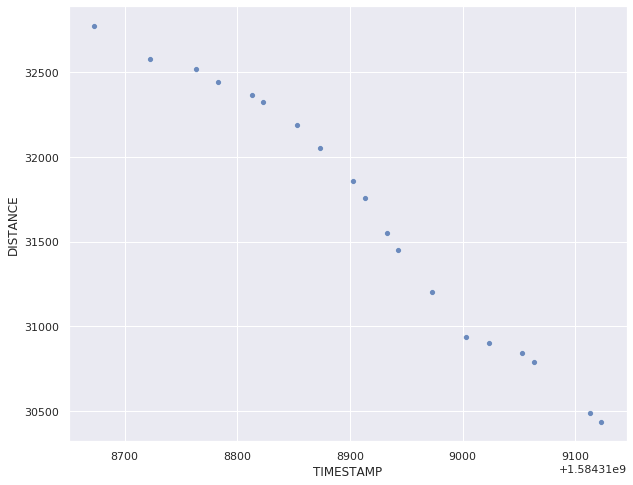

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 40 outlier.
Detected 2 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


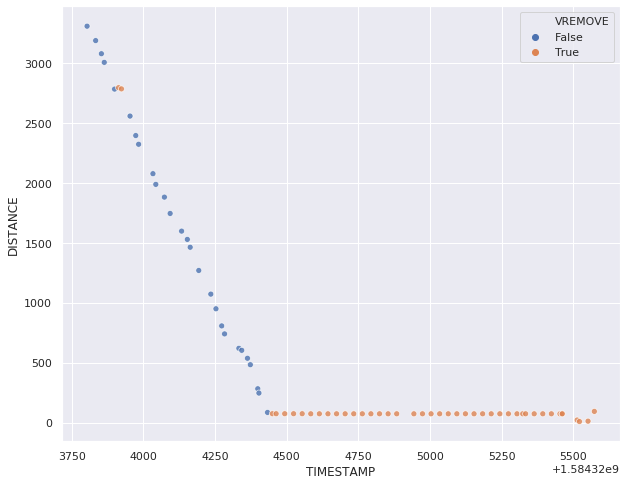

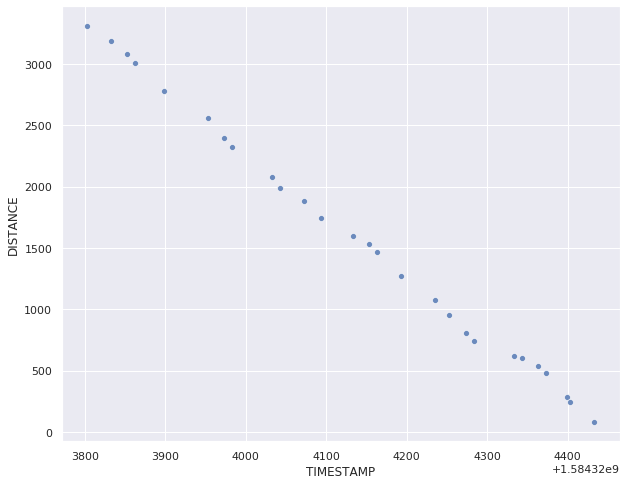

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


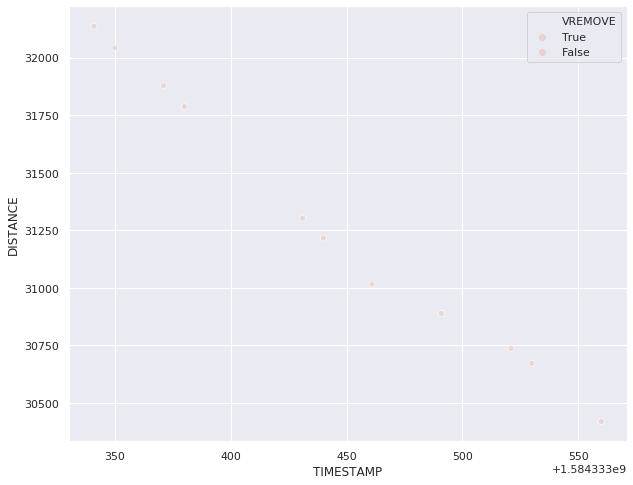

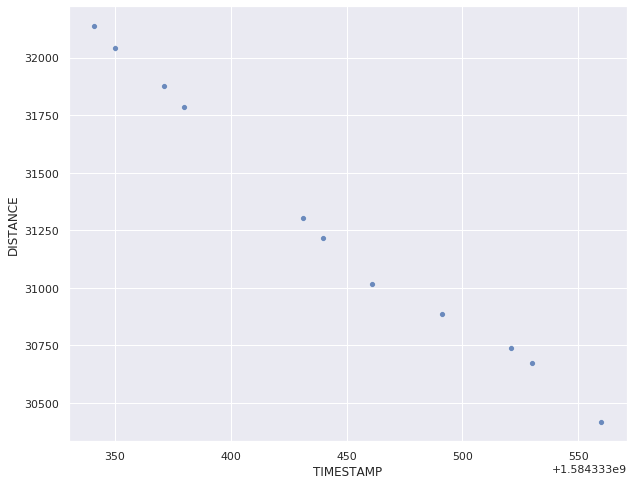

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 116 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


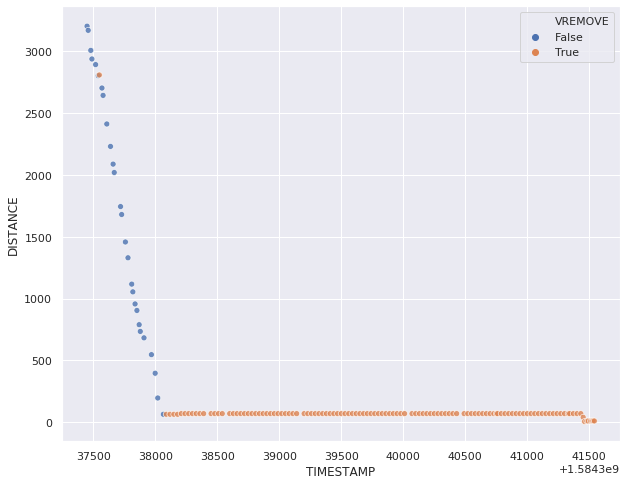

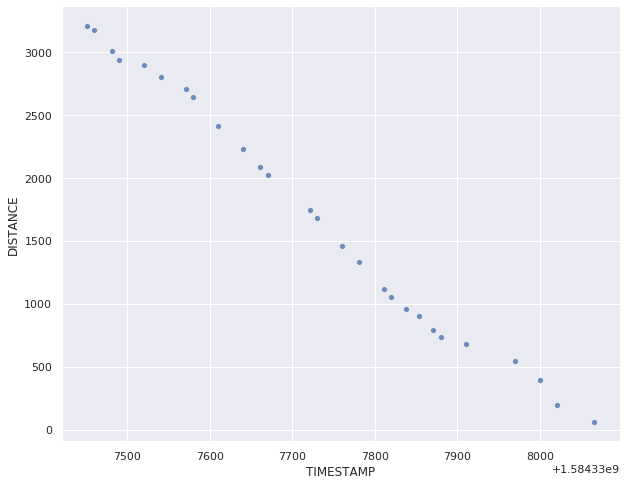

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


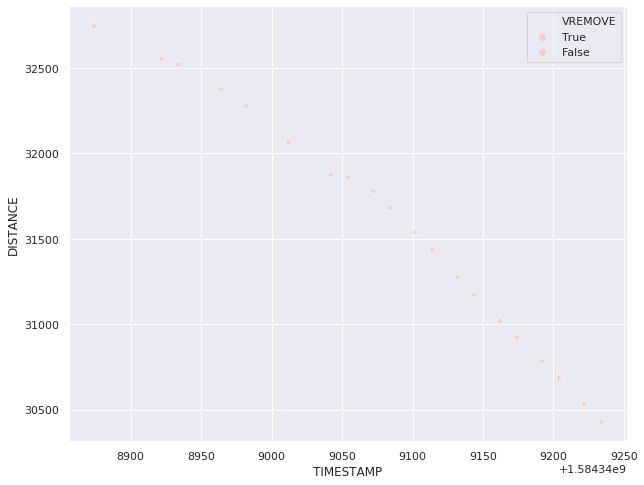

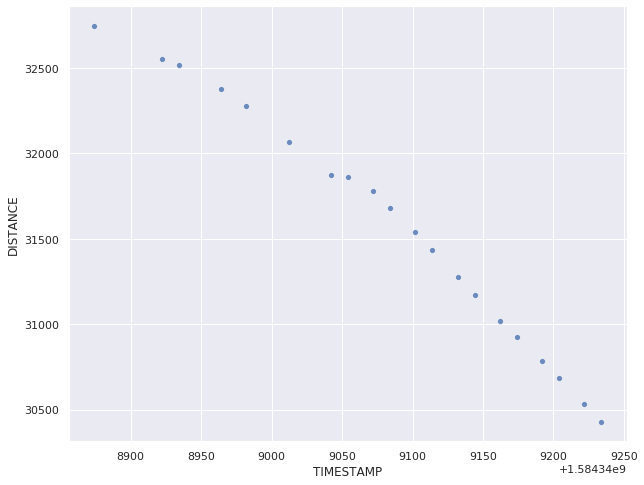

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 87 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


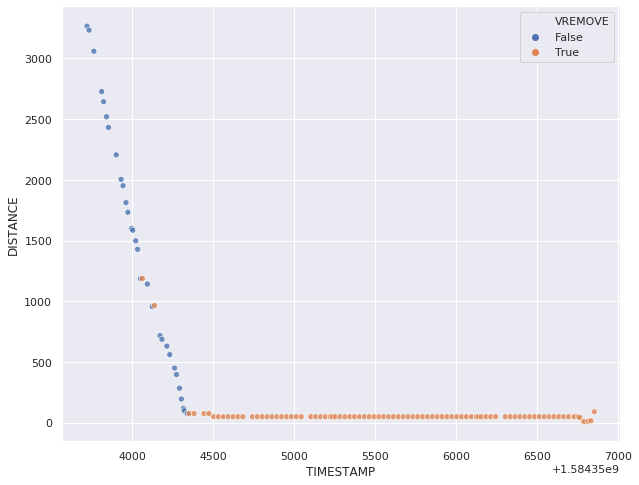

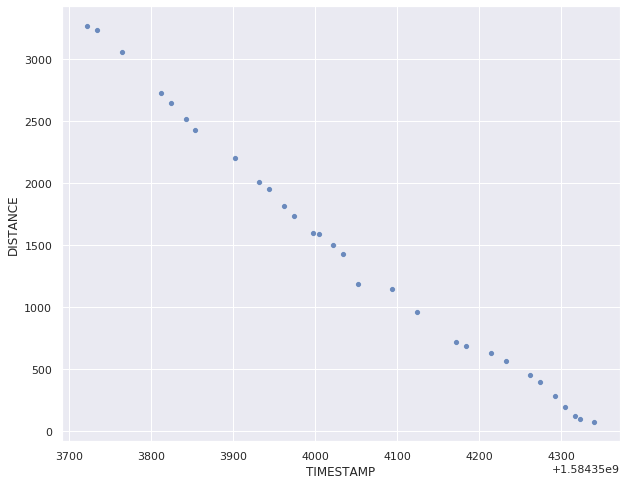

Shape after preprocessing (765, 39)
Predict for trips TRIPS00
There is no decrease distance


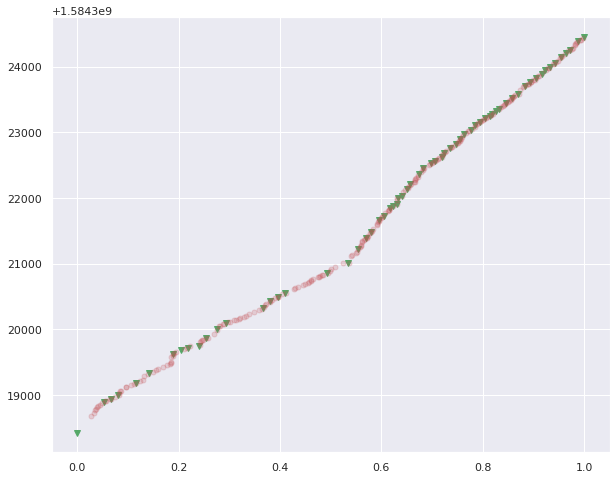

Predict for trips TRIPS01
There is no decrease distance


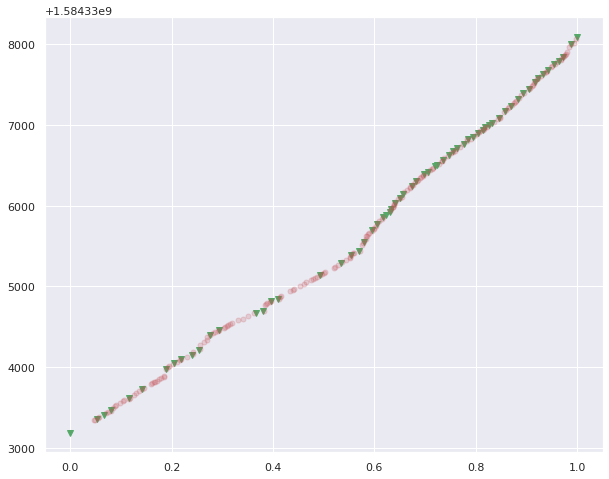

Predict for trips TRIPS02
There is no decrease distance


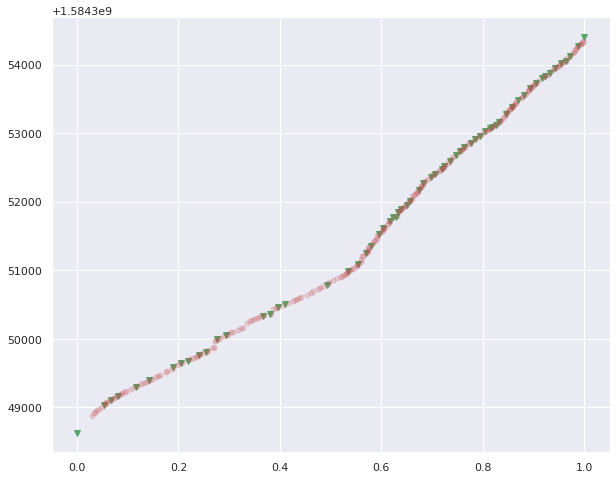

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Predic for bus 53N5049 with shape (2432, 35)
Length Time Tables: 9
There are 3 trips: TRIPS00, TRIPS01, TRIPS02
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 3 outlier.
Detected 0 outlier.
There is no outliers remain!


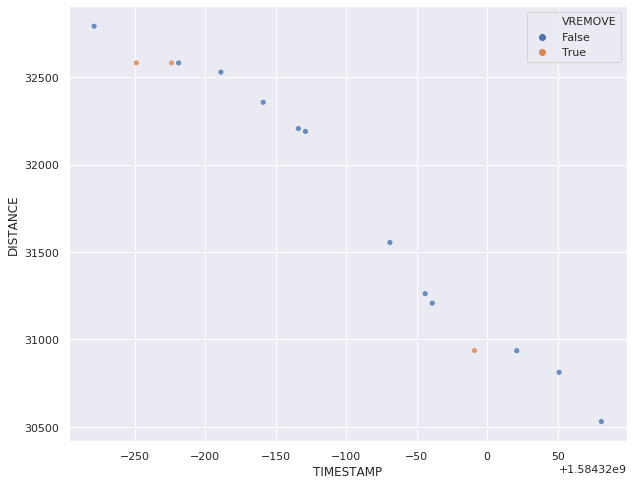

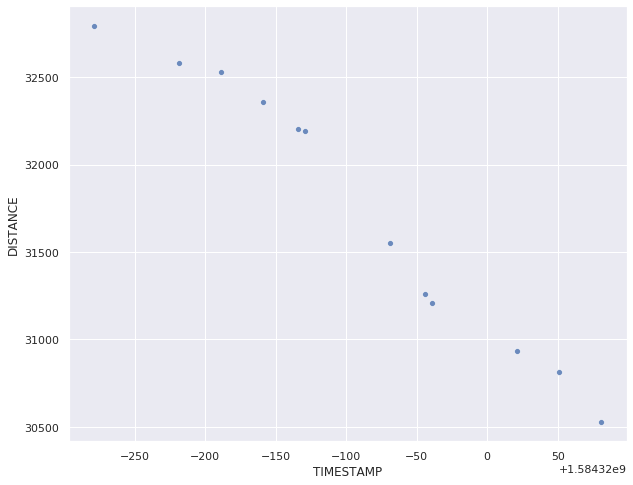

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 65 outlier.
Detected 3 outlier.
Detected 0 outlier.
There is no outliers remain!


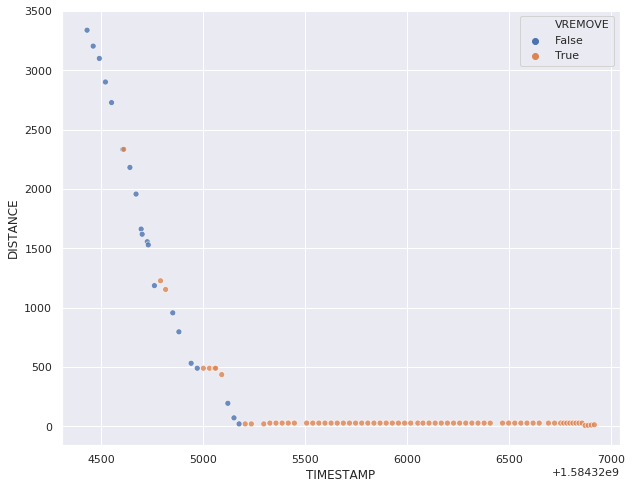

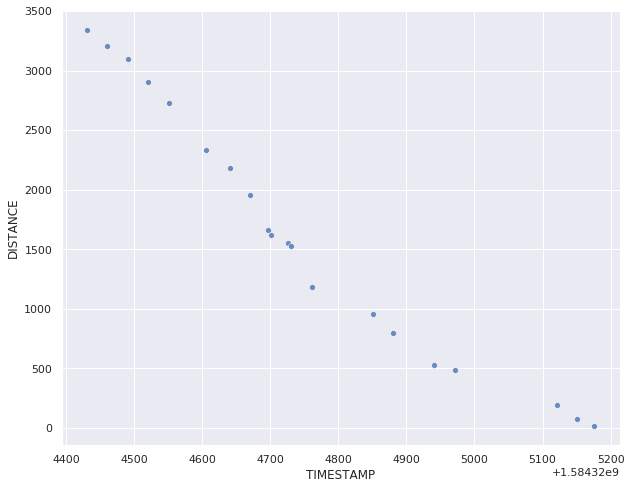

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


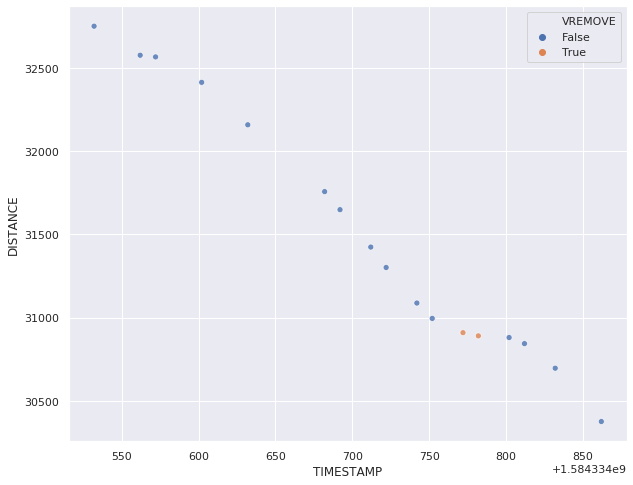

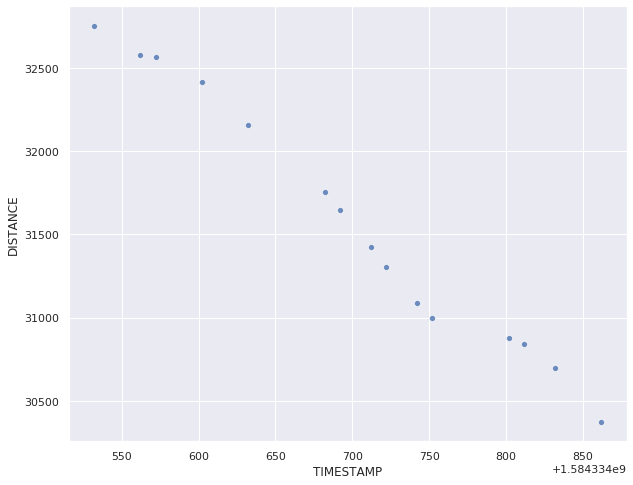

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 129 outlier.
Detected 2 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


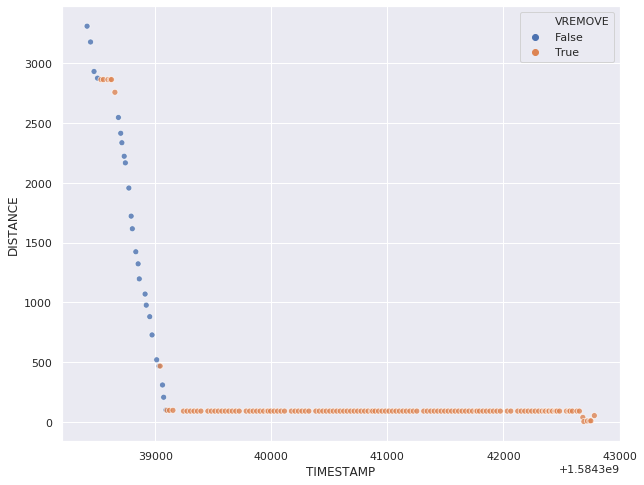

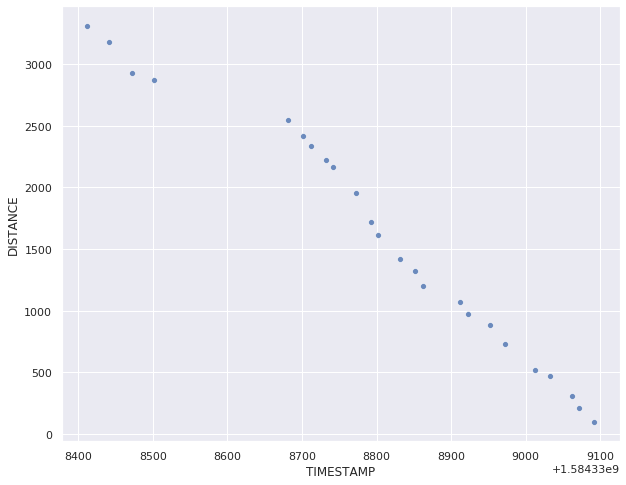

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 3 outlier.
Detected 0 outlier.
There is no outliers remain!


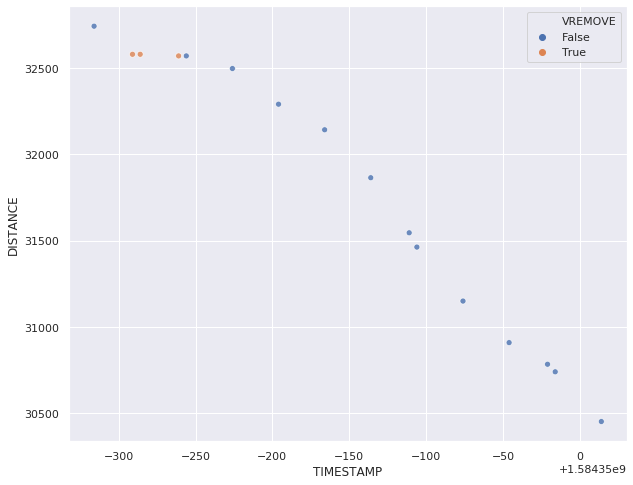

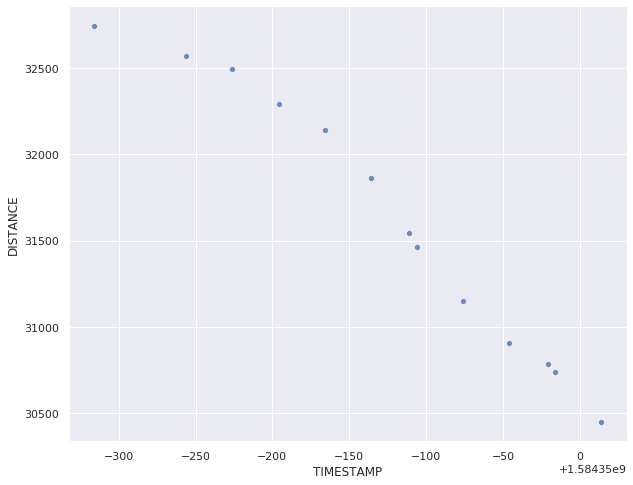

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 107 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


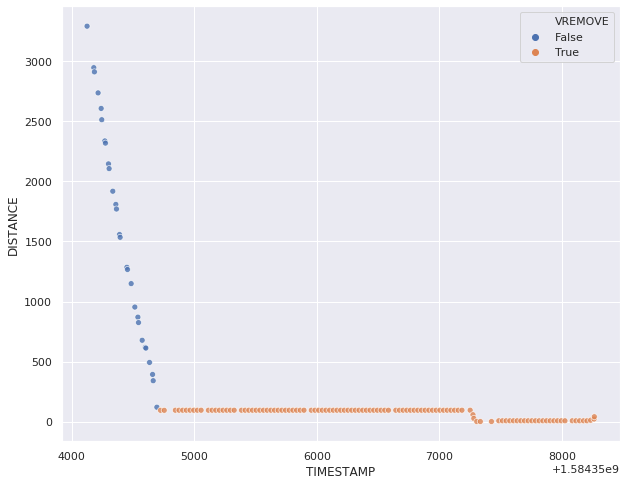

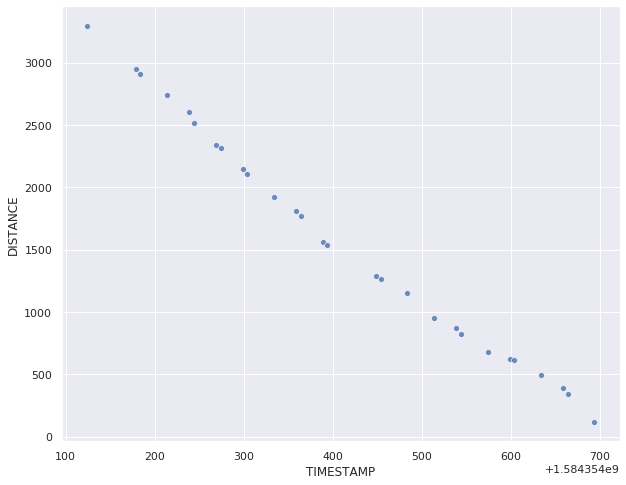

Shape after preprocessing (620, 39)
Predict for trips TRIPS00
There is no decrease distance


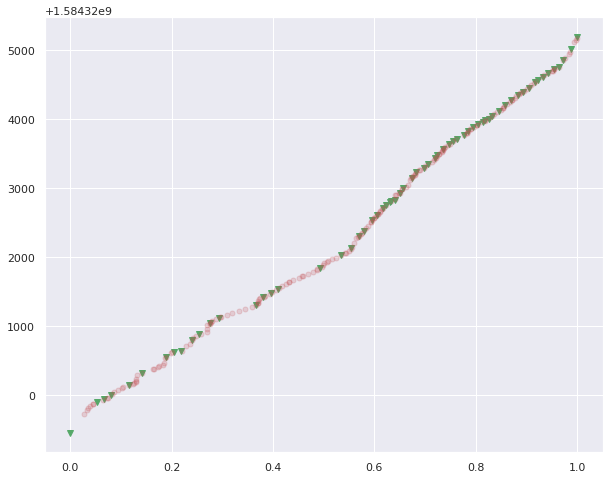

Predict for trips TRIPS01
There is no decrease distance


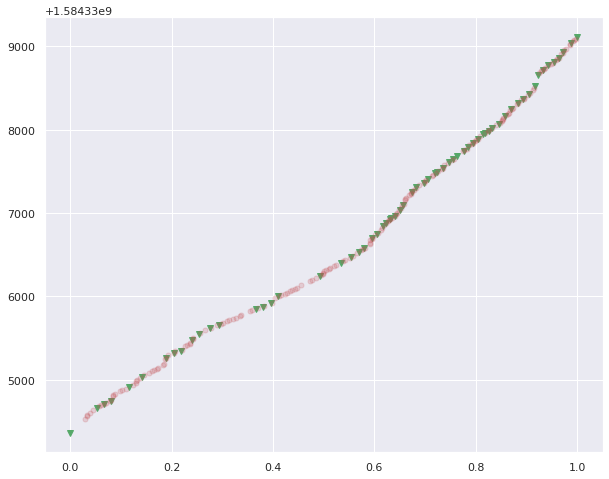

Predict for trips TRIPS02
There is no decrease distance


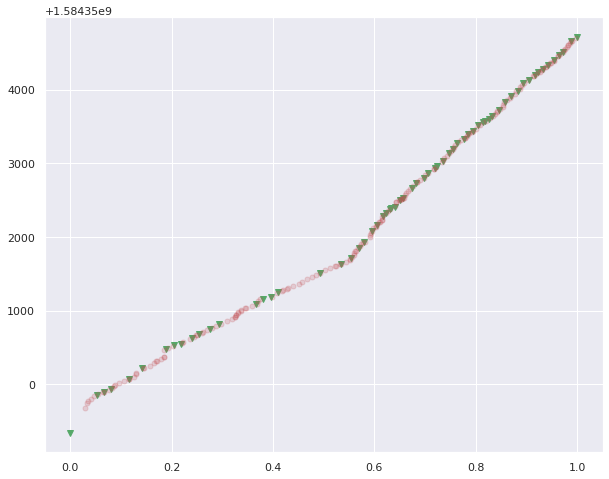

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Predic for bus 51B26267 with shape (2422, 35)
Length Time Tables: 10
There are 3 trips: TRIPS00, TRIPS01, TRIPS02
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 121 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


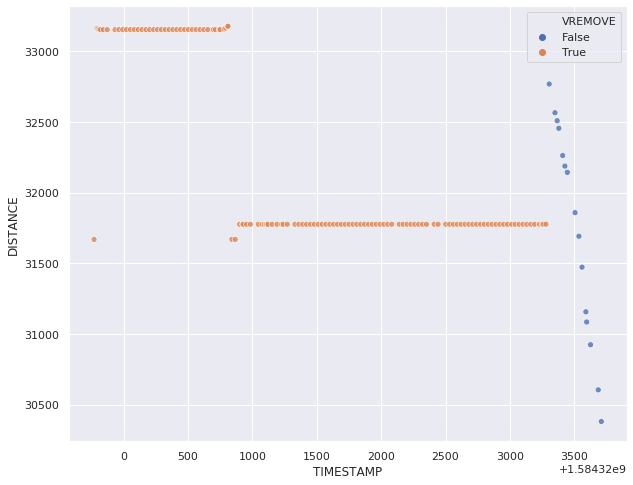

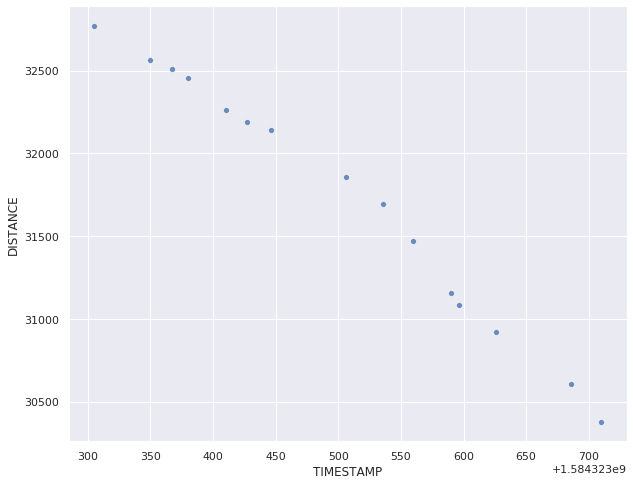

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 51 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


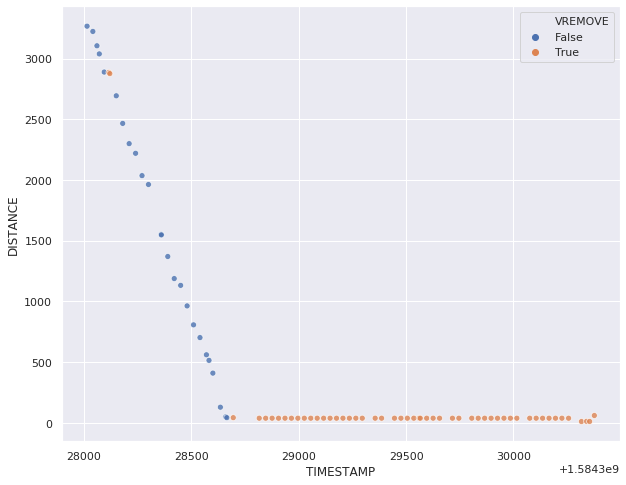

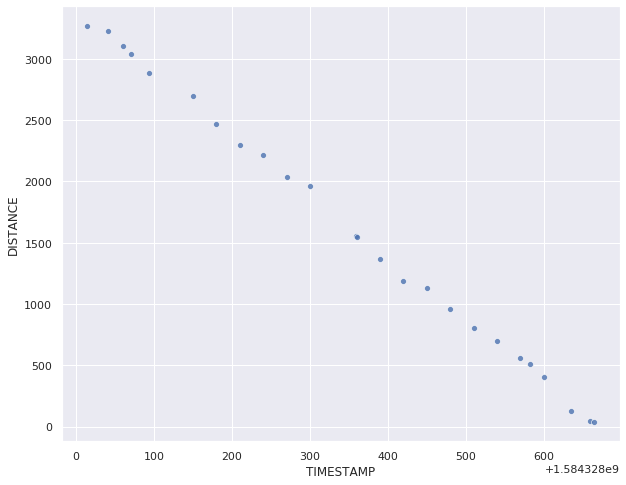

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 4 outlier.
Detected 0 outlier.
There is no outliers remain!


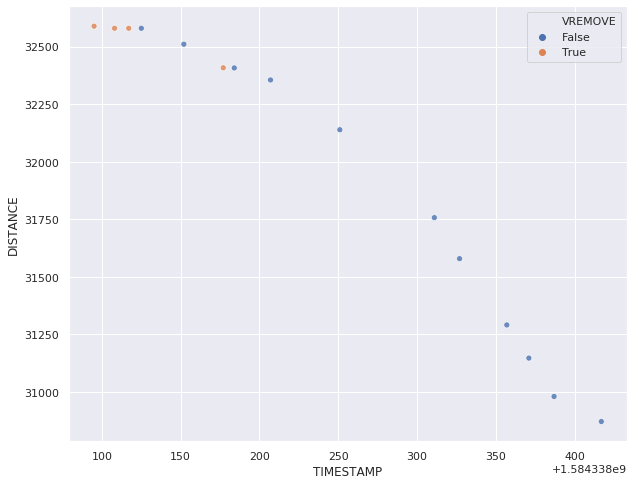

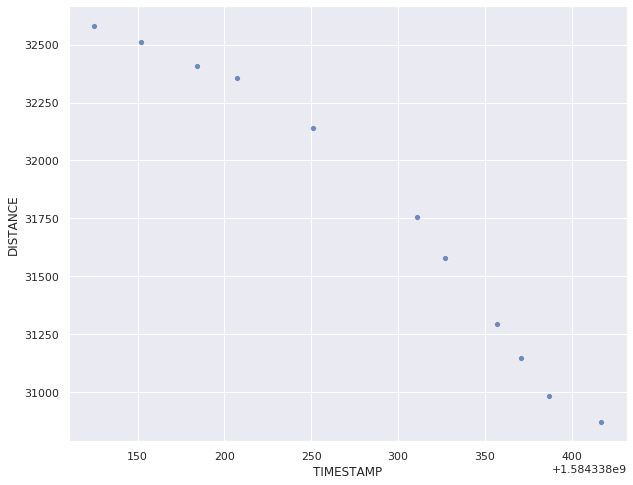

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 105 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


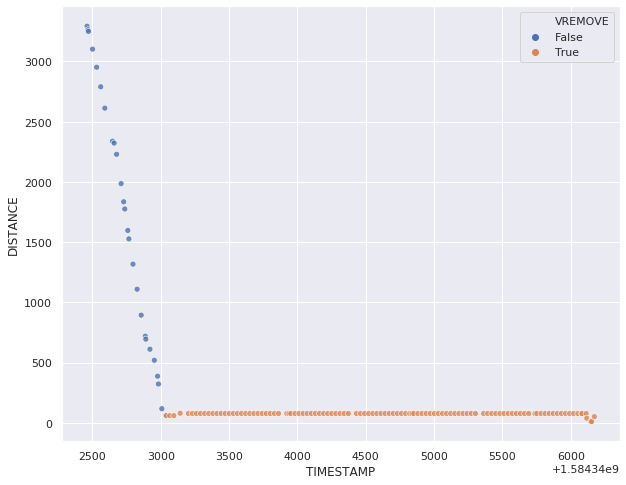

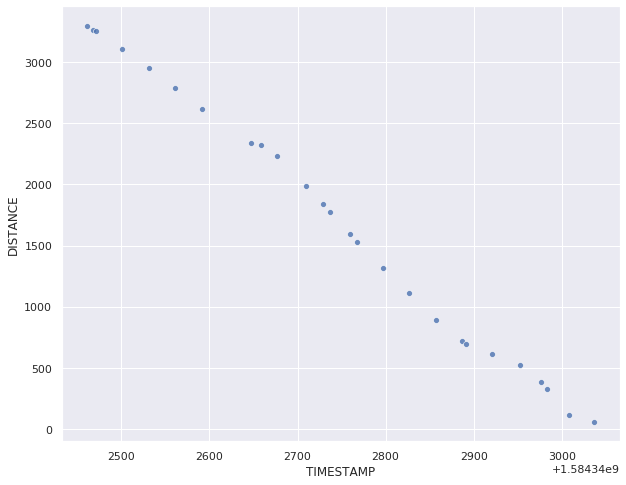

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


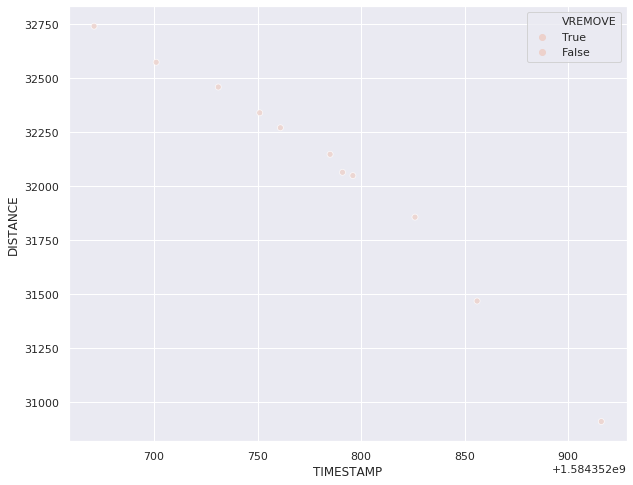

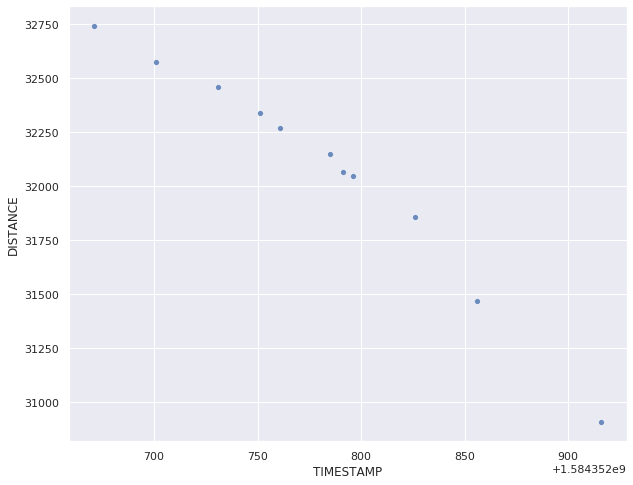

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 5 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


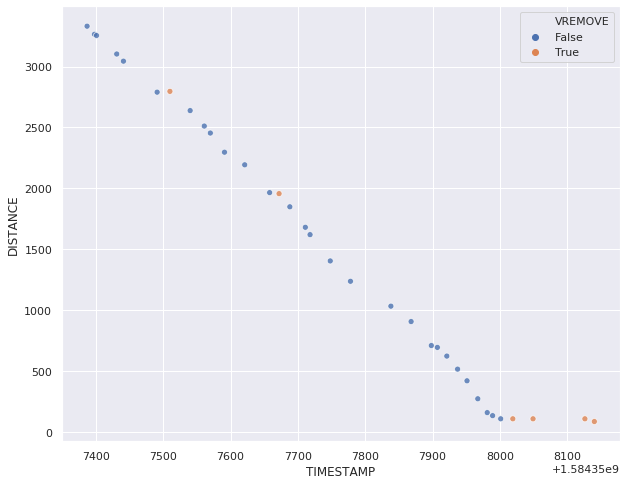

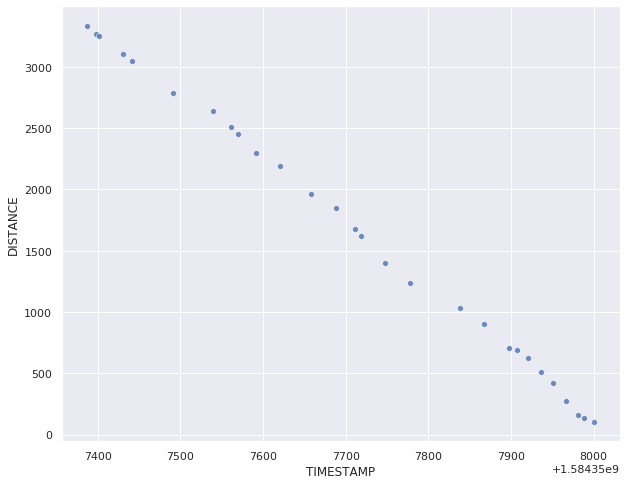

Shape after preprocessing (685, 39)
Predict for trips TRIPS00
There is no decrease distance


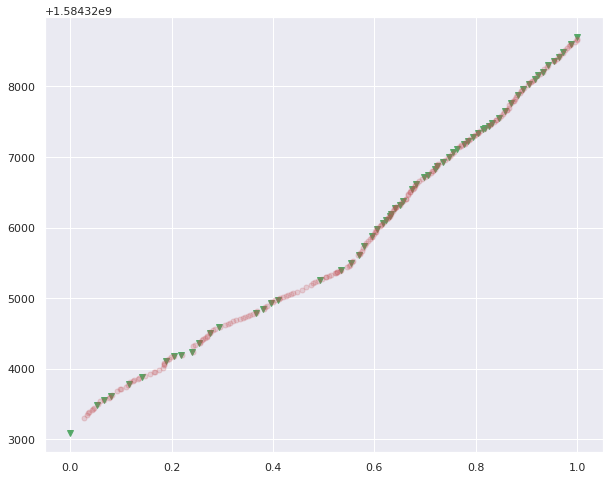

Predict for trips TRIPS01
There is no decrease distance


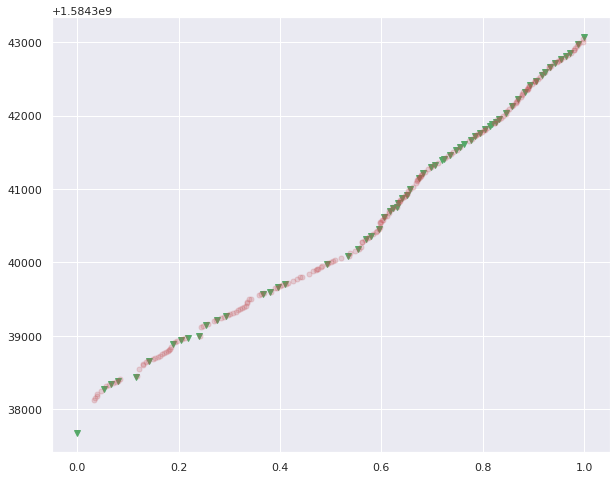

Predict for trips TRIPS02
There is no decrease distance


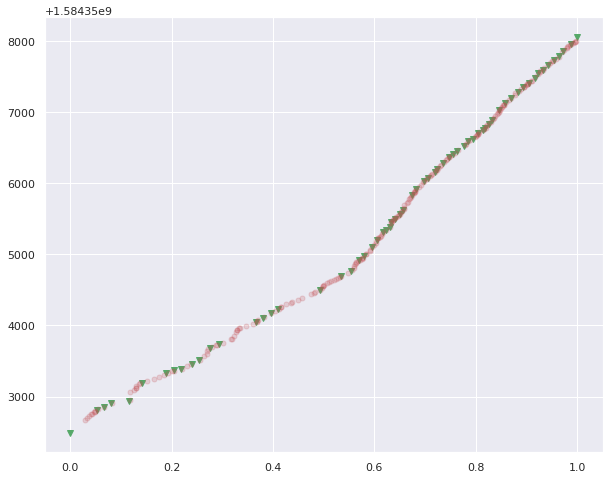

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Predic for bus 51B26345 with shape (2486, 35)
Length Time Tables: 11
There are 3 trips: TRIPS00, TRIPS01, TRIPS02
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


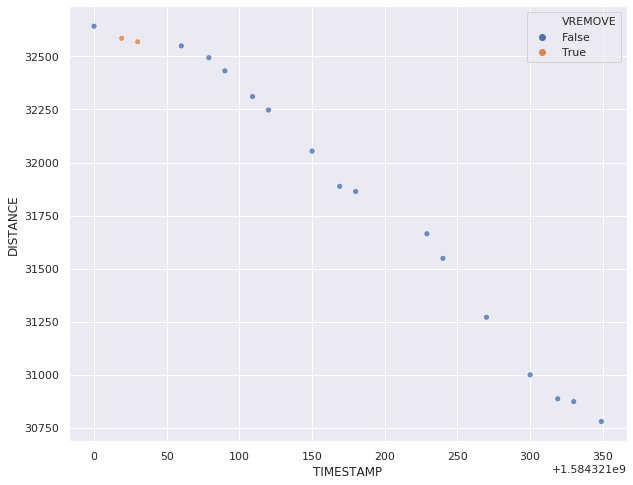

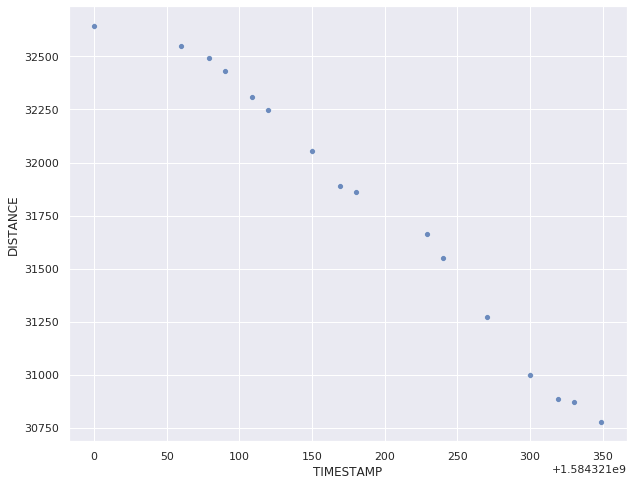

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 71 outlier.
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


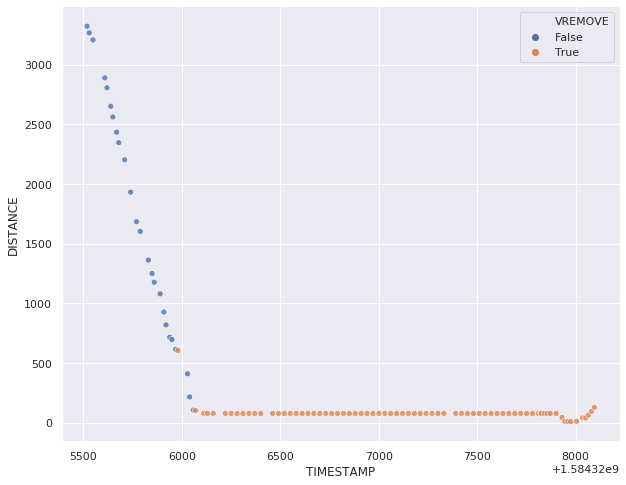

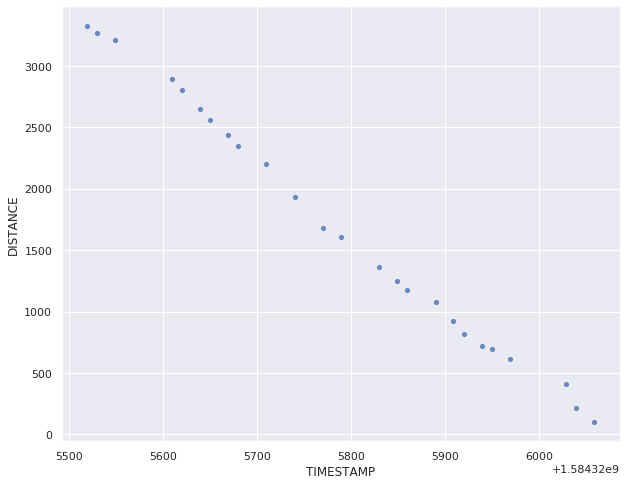

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


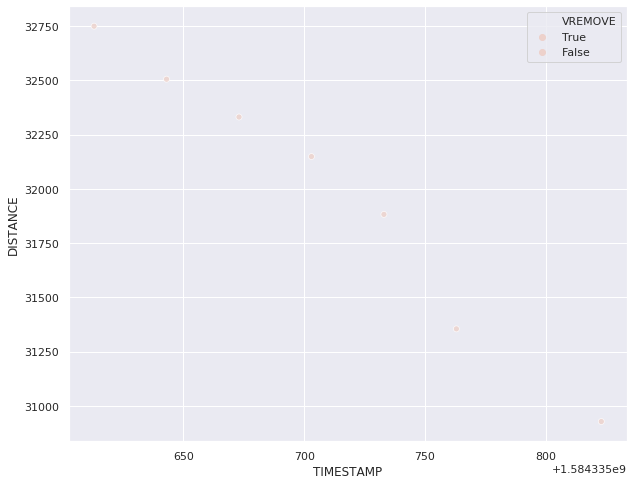

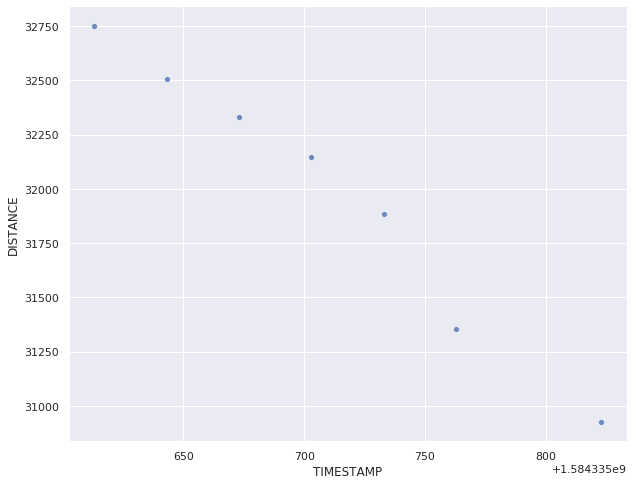

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 107 outlier.
Detected 0 outlier.
There is no outliers remain!


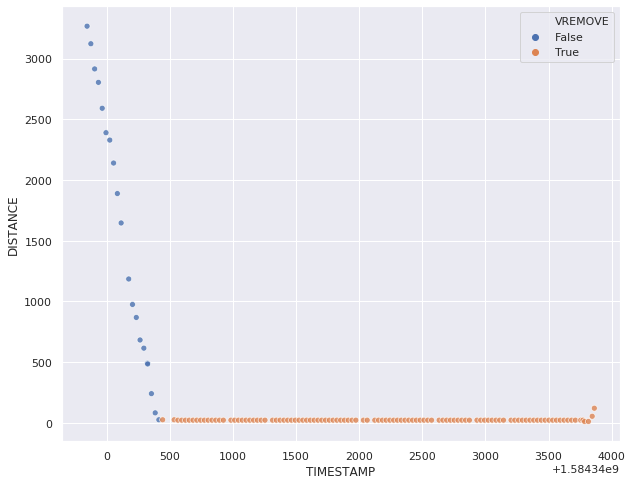

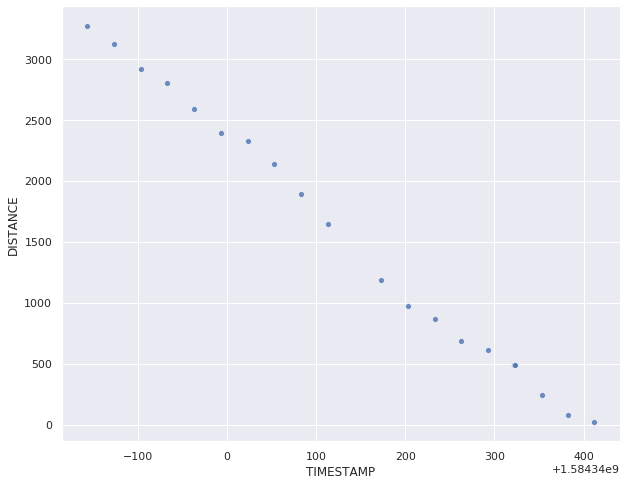

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


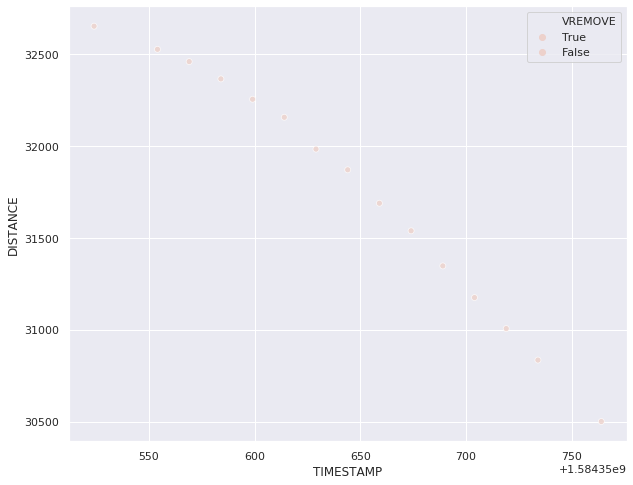

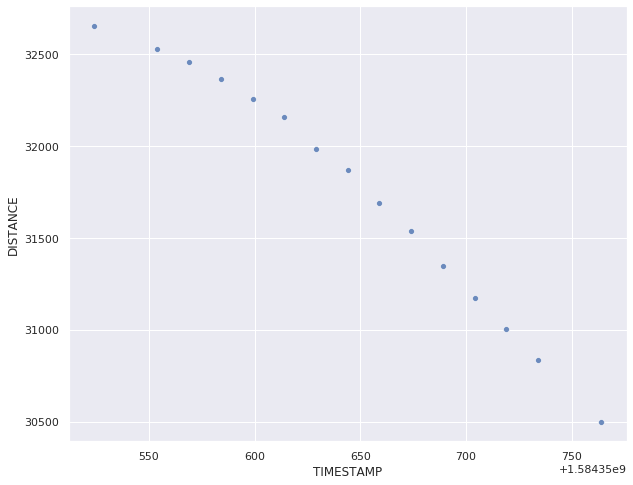

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 129 outlier.
Detected 0 outlier.
There is no outliers remain!


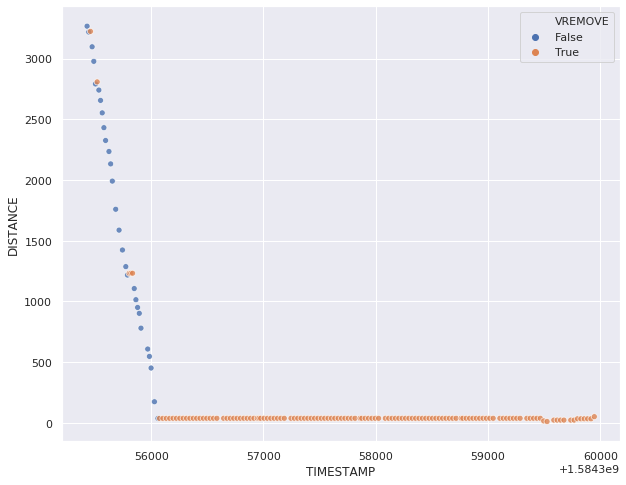

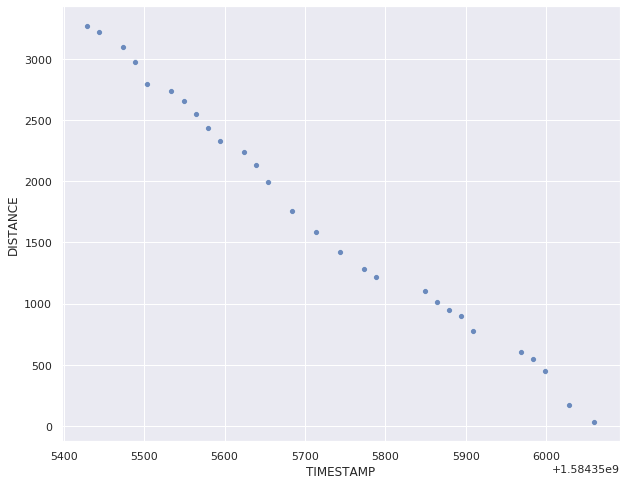

Shape after preprocessing (651, 39)
Predict for trips TRIPS00
There is no decrease distance


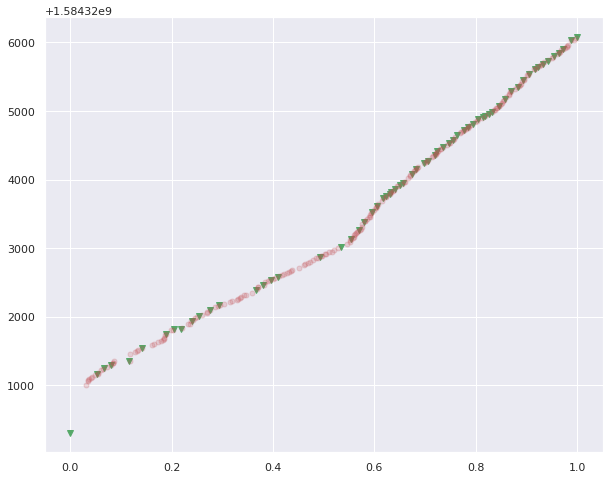

Predict for trips TRIPS01
There is no decrease distance


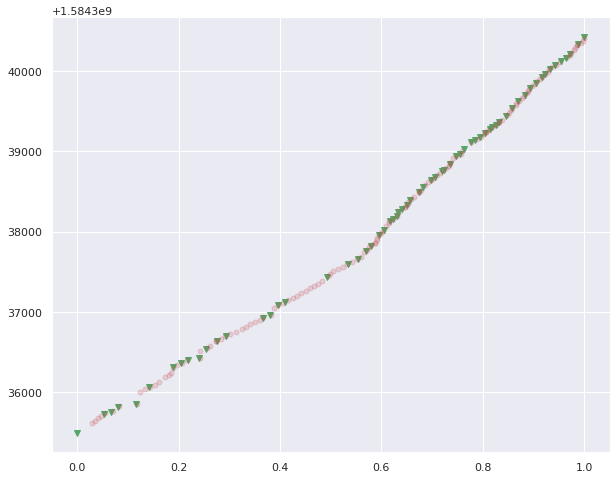

Predict for trips TRIPS02
There is no decrease distance


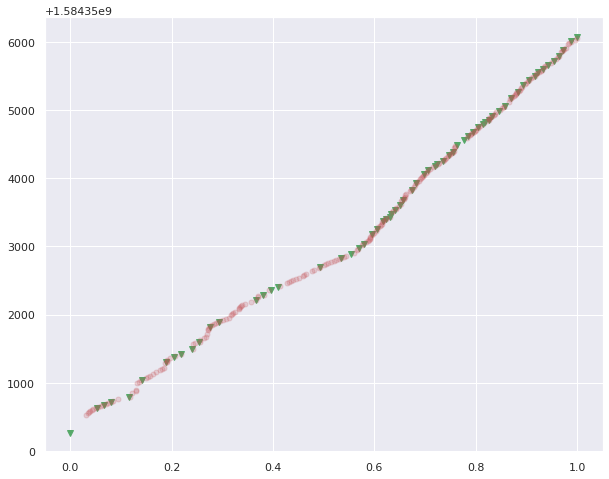

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02
Predic for bus 53N4967 with shape (2074, 35)
Length Time Tables: 12
There are 3 trips: TRIPS00, TRIPS01, TRIPS02
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


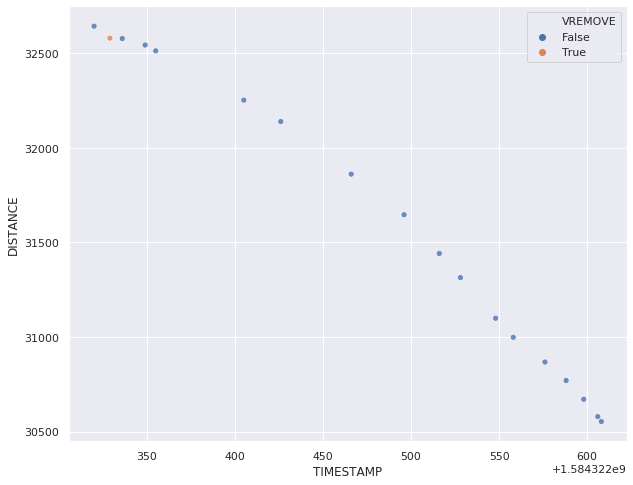

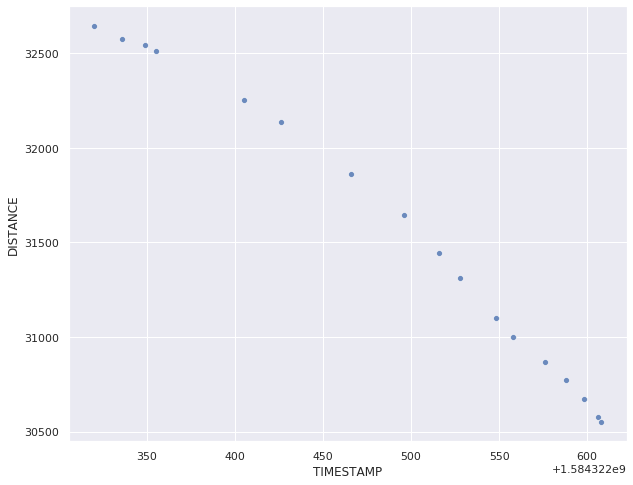

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 118 outlier.
Detected 0 outlier.
There is no outliers remain!


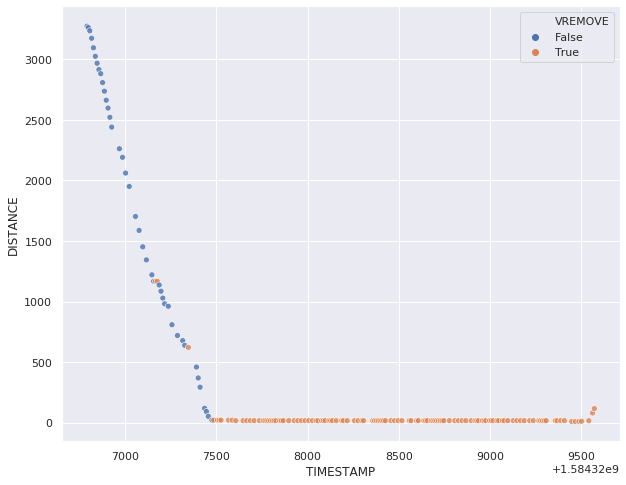

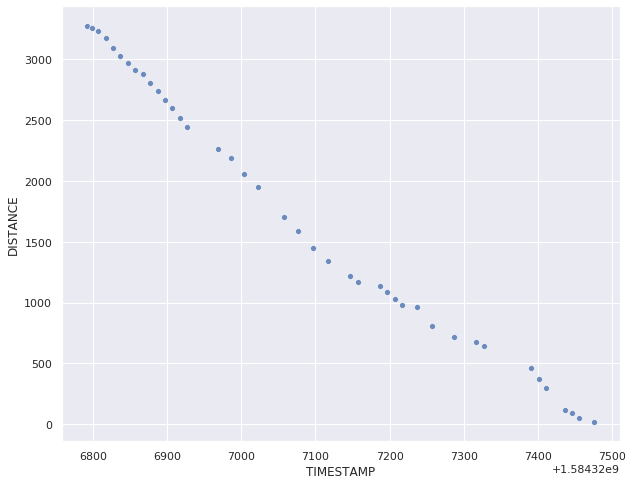

Remove outliers for trips: TRIPS01
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 1 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


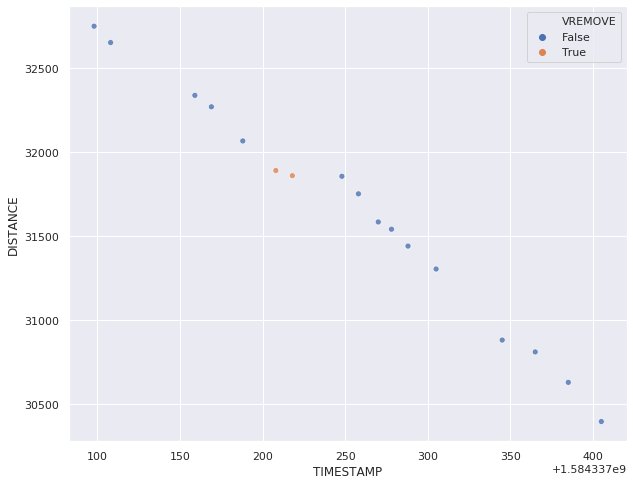

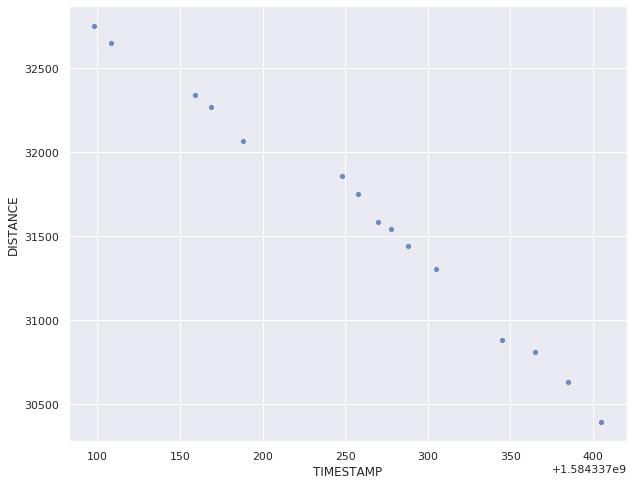

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 174 outlier.
Detected 1 outlier.
Detected 0 outlier.
There is no outliers remain!


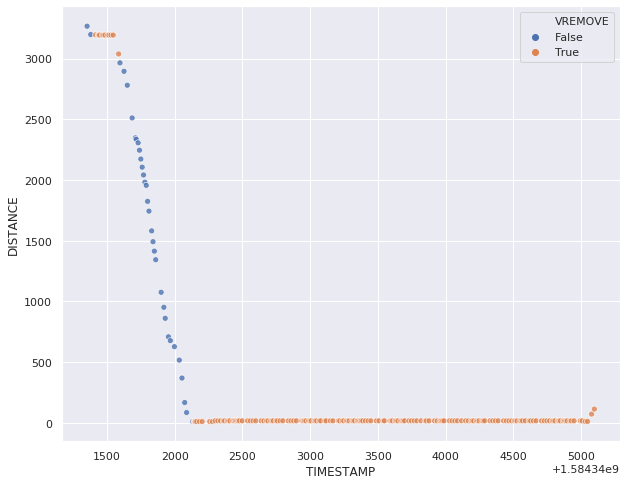

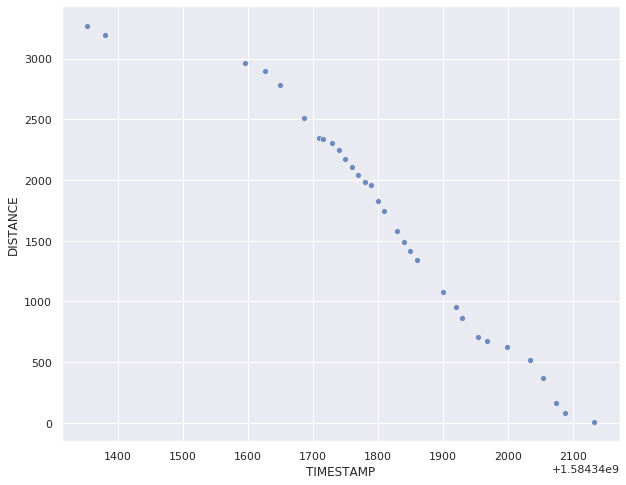

Remove outliers for trips: TRIPS02
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


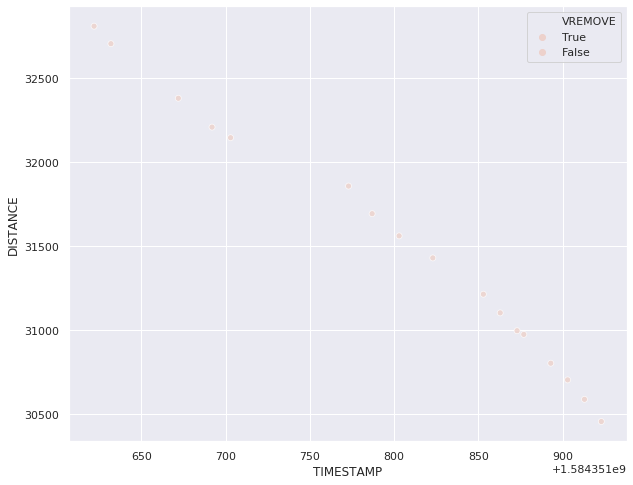

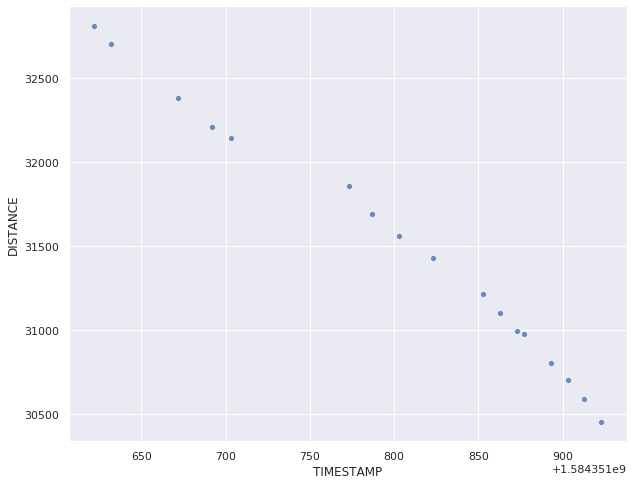

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 14 outlier.
Detected 0 outlier.
There is no outliers remain!


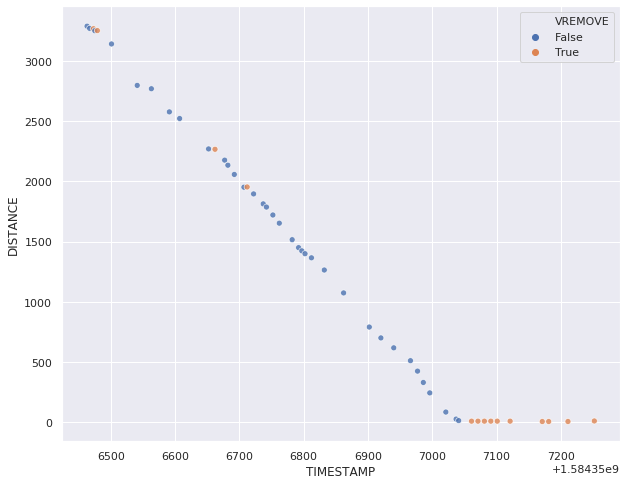

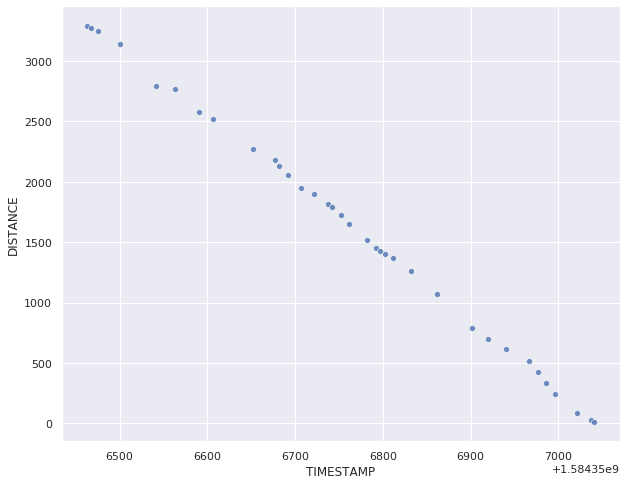

Shape after preprocessing (913, 39)
Predict for trips TRIPS00
There is no decrease distance


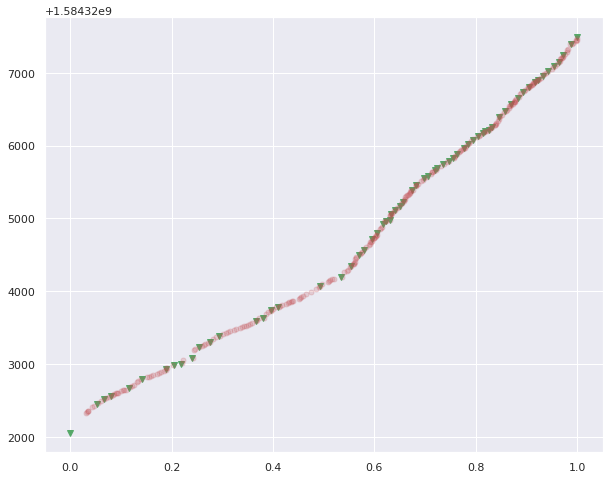

Predict for trips TRIPS01
There is no decrease distance


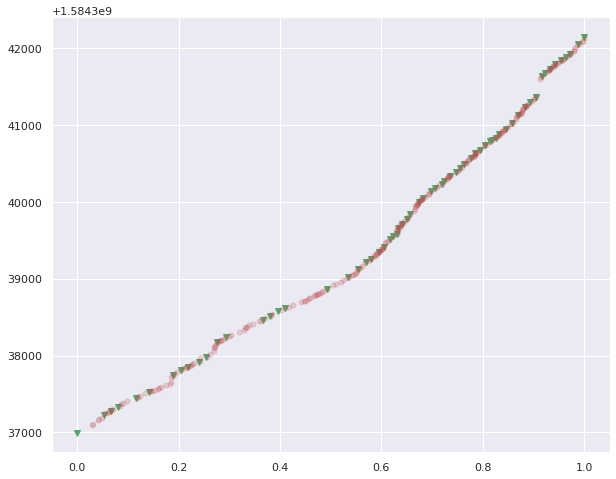

Predict for trips TRIPS02
There is no decrease distance


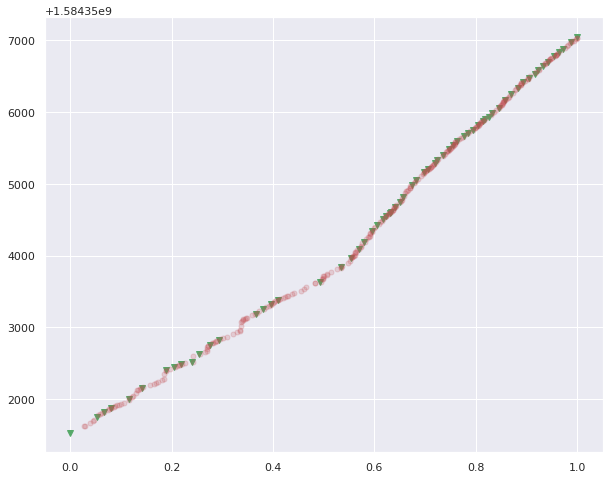

Convert column name ARRIVETIMETRIPS00
Convert column name ARRIVETIMETRIPS01
Convert column name ARRIVETIMETRIPS02


In [637]:
list_date = generate_date_from_range(
    get_date_from_str("20200316"),
    get_date_from_str("20200316")
)
rs = run_pipeline_multi_date(list_date, route_id=51, route_var_id=2, plot=(True, True))

In [127]:
rs.keys()

dict_keys(['2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22'])

In [130]:
for i, v in rs.items():
    print(i, v.shape)
    print(v.columns)

2020-03-16 (832, 22)
Index(['ADDRESSNO', 'ARRIVETIMETRIPS00', 'ARRIVETIMETRIPS01',
       'ARRIVETIMETRIPS02', 'ARRIVETIMETRIPS03', 'BUSPREDIC', 'CODE', 'LAT',
       'LNG', 'NAME', 'RANK', 'ROUTEID', 'ROUTES', 'ROUTEVARID', 'SEARCH',
       'STATUS', 'STOPID', 'STOPTYPE', 'STREET', 'SUPPORTDISABILITY', 'WARD',
       'ZONE'],
      dtype='object')
2020-03-17 (896, 22)
Index(['ADDRESSNO', 'ARRIVETIMETRIPS00', 'ARRIVETIMETRIPS01',
       'ARRIVETIMETRIPS02', 'ARRIVETIMETRIPS03', 'BUSPREDIC', 'CODE', 'LAT',
       'LNG', 'NAME', 'RANK', 'ROUTEID', 'ROUTES', 'ROUTEVARID', 'SEARCH',
       'STATUS', 'STOPID', 'STOPTYPE', 'STREET', 'SUPPORTDISABILITY', 'WARD',
       'ZONE'],
      dtype='object')
2020-03-18 (832, 22)
Index(['ADDRESSNO', 'ARRIVETIMETRIPS00', 'ARRIVETIMETRIPS01',
       'ARRIVETIMETRIPS02', 'ARRIVETIMETRIPS03', 'BUSPREDIC', 'CODE', 'LAT',
       'LNG', 'NAME', 'RANK', 'ROUTEID', 'ROUTES', 'ROUTEVARID', 'SEARCH',
       'STATUS', 'STOPID', 'STOPTYPE', 'STREET', 'SUPPORTDISABI

In [235]:
final_rs = pd.concat(rs, sort=False)
final_rs = final_rs.reset_index(level=0).rename({"level_0": "DATEPREDIC"}, axis=1)

final_rs["DATEPREDIC"] = pd.to_datetime(final_rs["DATEPREDIC"])

final_rs = final_rs.sort_values(["ROUTEID", "ROUTEVARID", "BUSPREDIC", "RANK", "STOPID", "DATEPREDIC"])

In [237]:
melted_df = final_rs.melt(
    id_vars=["ROUTEID", "ROUTEVARID", "BUSPREDIC", "STOPID", "DATEPREDIC"], 
    value_vars=['ARRIVETIMETRIPS00', 'ARRIVETIMETRIPS01', 'ARRIVETIMETRIPS02', 'ARRIVETIMETRIPS03'],
    var_name="TRIPSORDER",
    value_name="TRIPSTIME"
)

melted_rs = melted_df.merge(
    final_rs,
    on=["ROUTEID", "ROUTEVARID", "BUSPREDIC", "STOPID", "DATEPREDIC"],
    how="inner"
)

melted_rs["TRIPSHOUR"] = melted_rs.TRIPSTIME - melted_rs.TRIPSTIME.dt.floor("d")

# Remove not have time
melted_rs = melted_rs.dropna(subset=["TRIPSTIME"])

melted_rs["RANKATIME"] = melted_rs.groupby(
    ["TRIPSORDER", "RANK", "DATEPREDIC"]
).TRIPSTIME.rank(method="first")

melted_rs["TRIPSDELTAT"] = melted_rs.TRIPSHOUR.dt.total_seconds()

_col_i = ["ROUTEID", "ROUTEVARID", "STOPID", "TRIPSORDER", "RANK", "RANKATIME"]
stats_rs = melted_rs.groupby(
    _col_i
).agg(
    **{
        "NUMREC": pd.NamedAgg("ROUTEID", "size"),
        "MEAN": pd.NamedAgg("TRIPSDELTAT", "mean"),
        "MEDIAN": pd.NamedAgg("TRIPSDELTAT", "median"),
        "VAR": pd.NamedAgg("TRIPSDELTAT", "var"),
        "STD": pd.NamedAgg("TRIPSDELTAT", "std"),
        "MIN": pd.NamedAgg("TRIPSDELTAT", "min"),
        "MAX": pd.NamedAgg("TRIPSDELTAT", "max"),
    }
).reset_index().sort_values(
    ["ROUTEID", "ROUTEVARID", "TRIPSORDER", "RANK", "RANKATIME"] 
    + ["NUMREC", "MEAN", "MEDIAN"]
)
stats_rs[['MEAN', 'MEDIAN', 'STD', 'MIN', 'MAX']] = stats_rs[['MEAN', 'MEDIAN', 'STD', 'MIN', 'MAX']].apply(pd.to_timedelta, unit="s")

In [799]:
stats_rs.head(2)

ROUTEID  ROUTEVARID  STOPID         TRIPSORDER     RANK  RANKATIME  \
2898       51           2    4412  ARRIVETIMETRIPS00 1.000000   1.000000   
2899       51           2    4412  ARRIVETIMETRIPS00 1.000000   2.000000   

      NUMREC            MEAN          MEDIAN            VAR             STD  \
2898       7 05:16:28.146425 05:14:48.470397 141,067.376903 00:06:15.589372   
2899       7 05:35:06.262488 05:33:02.982006 243,921.386617 00:08:13.883980   

                 MIN             MAX  
2898 05:11:14.633271 05:30:15.014858  
2899 05:26:34.730342 05:52:39.908957

In [797]:
list_bus_stats = melted_rs.query("RANK==1").groupby(["ROUTEID", "ROUTEVARID", "STOPID", "TRIPSORDER", "RANK", "DATEPREDIC"]).BUSPREDIC.size().to_frame().head(100)

* Nhìn bảng dưới đây ta có:
    * Hầu hết các ngày trong tuần chỉ có khoảng 12 - 13 chuyến chạy xuyên suốt (không quan tâm xe bus nào chỉ quan tấm thứ tự)
    * Chỉ có khoảng 2 ngày trong tuần là có chuyến thứ 14

In [504]:
stats_rs.query("TRIPSORDER == 'ARRIVETIMETRIPS00'").head(20)

ROUTEID  ROUTEVARID  STOPID         TRIPSORDER     RANK  RANKATIME  \
2898       51           2    4412  ARRIVETIMETRIPS00 1.000000   1.000000   
2899       51           2    4412  ARRIVETIMETRIPS00 1.000000   2.000000   
2900       51           2    4412  ARRIVETIMETRIPS00 1.000000   3.000000   
2901       51           2    4412  ARRIVETIMETRIPS00 1.000000   4.000000   
2902       51           2    4412  ARRIVETIMETRIPS00 1.000000   5.000000   
2903       51           2    4412  ARRIVETIMETRIPS00 1.000000   6.000000   
2904       51           2    4412  ARRIVETIMETRIPS00 1.000000   7.000000   
2905       51           2    4412  ARRIVETIMETRIPS00 1.000000   8.000000   
2906       51           2    4412  ARRIVETIMETRIPS00 1.000000   9.000000   
2907       51           2    4412  ARRIVETIMETRIPS00 1.000000  10.000000   
2908       51           2    4412  ARRIVETIMETRIPS00 1.000000  11.000000   
2909       51           2    4412  ARRIVETIMETRIPS00 1.000000  12.000000   
2910       51           2    4412  ARRIVETIMETRIPS00 1.000000  13.000000   
2911       51           2    4412  ARRIVETIMETRIPS00 1.000000  14.000000   
552        51           2     572  ARRIVETIMETRIPS00 2.000000   1.000000   
553        51           2     572  ARRIVETIMETRIPS00 2.000000   2.000000   
554        51           2     572  ARRIVETIMETRIPS00 2.000000   3.000000   
555        51           2     572  ARRIVETIMETRIPS00 2.000000   4.000000   
556        51           2     572  ARRIVETIMETRIPS00 2.000000   5.000000   
557        51           2     572  ARRIVETIMETRIPS00 2.000000   6.000000   

      NUMREC            MEAN          MEDIAN               VAR  \
2898       7 05:16:28.146425 05:14:48.470397    141,067.376903   
2899       7 05:35:06.262488 05:33:02.982006    243,921.386617   
2900       7 05:53:15.743250 05:51:53.454212    134,186.117333   
2901       7 06:09:22.199718 06:06:38.123105    220,674.761156   
2902       7 06:23:53.820536 06:21:58.912266     86,828.426879   
2903       7 06:35:55.131791 06:36:18.530433    165,525.830056   
2904       7 06:49:39.703993 06:50:26.633316    114,158.446348   
2905       7 07:08:02.370660 07:06:20.158816    330,728.943169   
2906       7 07:29:07.017410 07:27:21.275342    192,360.609938   
2907       7 07:44:47.715096 07:44:17.865920    422,328.353676   
2908       7 08:08:25.117765 08:06:38.088771    268,252.816556   
2909       7 08:29:23.597852 08:27:37.429581    361,593.685075   
2910       7 09:26:48.093695 08:44:55.833086 48,906,558.450323   
2911       2 12:35:19.358487 12:35:19.358487 85,851,111.328130   
552        7 05:20:15.113140 05:18:05.246294    137,815.362171   
553        7 05:39:23.957112 05:36:58.290537    202,100.381061   
554        7 05:57:25.096285 05:56:05.377413    113,571.841052   
555        7 06:12:47.693272 06:09:49.251307    220,582.699659   
556        7 06:28:22.173943 06:27:27.325967    160,501.048045   
557        7 06:43:48.738602 06:42:01.365251     81,709.691100   

                 STD             MIN             MAX  
2898 00:06:15.589372 05:11:14.633271 05:30:15.014858  
2899 00:08:13.883980 05:26:34.730342 05:52:39.908957  
2900 00:06:06.314233 05:49:00.805107 06:06:45.344171  
2901 00:07:49.760323 06:03:21.923254 06:26:44.140625  
2902 00:04:54.666636 06:20:47.672896 06:34:44.053808  
2903 00:06:46.848657 06:23:23.054237 06:46:40.322441  
2904 00:05:37.873417 06:42:28.693878 06:59:37.267089  
2905 00:09:35.090378 06:53:08.800918 07:25:30.852762  
2906 00:07:18.589340 07:23:54.470001 07:45:17.799736  
2907 00:10:49.867950 07:32:01.660842 08:04:54.392740  
2908 00:08:37.931285 07:58:29.628749 08:26:23.482419  
2909 00:10:01.326604 08:15:51.794616 08:49:32.059020  
2910 01:56:33.322418 08:30:26.716819 13:50:45.035396  
2911 02:34:25.587478 10:46:07.598749 14:24:31.118225  
552  00:06:11.234915 05:16:22.217252 05:34:04.529164  
553  00:07:29.555759 05:34:26.032272 05:56:04.944171  
554  00:05:37.004215 05:53:24.057117 06:09:50.331726  
555  00:07:49.662325 06:07:52.48

In [515]:
stats_rs.head(4000).to_excel(
    "../data/result/stats_result_timetables_7days_20210228.xlsx",
    index=False,
)

* Những trường hợp var cao như chuyến 13, 14: 
    * Chuyến 13: Chỉ chạy 2 trips trong ngày (ca 3 và 4)
    * Chuyến 14: Mẫu ít, chỉ chạy 1 lần.

In [490]:
melted_rs.query("TRIPSORDER=='ARRIVETIMETRIPS00' & RANK==1 & RANKATIME==14").sort_values("TRIPSTIME")

ROUTEID  ROUTEVARID BUSPREDIC  STOPID DATEPREDIC         TRIPSORDER  \
12800       51           2   53N4992    4412 2020-03-17  ARRIVETIMETRIPS00   
4364        51           2  51B31288    4412 2020-03-20  ARRIVETIMETRIPS00   

                          TRIPSTIME                           ADDRESSNO  \
12800 2020-03-17 10:46:07.598749161  Đại học Quốc Tế - Đại học Quốc gia   
4364  2020-03-20 14:24:31.118225098  Đại học Quốc Tế - Đại học Quốc gia   

                  ARRIVETIMETRIPS00 ARRIVETIMETRIPS01 ARRIVETIMETRIPS02  \
12800 2020-03-17 10:46:07.598749161               NaT               NaT   
4364  2020-03-20 14:24:31.118225098               NaT               NaT   

      ARRIVETIMETRIPS03           CODE       LAT        LNG  \
12800               NaT  BX 1234546789 10.876771 106.801808   
4364                NaT  BX 1234546789 10.876771 106.801808   

                                NAME     RANK ROUTES  \
12800  Đường nội bộ Đại học Quốc gia 1.000000     30   
4364   Đường nội bộ Đại học Quốc gia 1.000000     30   

                          SEARCH          STATUS STOPTYPE  \
12800  DnbDhQg DhQT-DhQg DnbDhQg  Đang khai thác    Ô sơn   
4364   DnbDhQg DhQT-DhQg DnbDhQg  Đang khai thác    Ô sơn   

                              STREET SUPPORTDISABILITY  WARD          ZONE  \
12800  Đường nội bộ Đại học Quốc gia                    None  Quận Thủ Đức   
4364   Đường nội bộ Đại học Quốc gia                    None  Quận Thủ Đức   

            TRIPSHOUR  RANKATIME   TRIPSDELTAT  
12800 10:46:07.598749  14.000000 38,767.598749  
4364  14:24:31.118225  14.000000 51,871.118225

In [508]:
melted_rs.query("TRIPSORDER=='ARRIVETIMETRIPS00' & RANK==1 & RANKATIME==13").sort_values("TRIPSTIME")

ROUTEID  ROUTEVARID BUSPREDIC  STOPID DATEPREDIC         TRIPSORDER  \
0           51           2  51B26267    4412 2020-03-16  ARRIVETIMETRIPS00   
6912        51           2   53N4204    4412 2020-03-17  ARRIVETIMETRIPS00   
3076        51           2  51B31233    4412 2020-03-18  ARRIVETIMETRIPS00   
17416       51           2   53N5024    4412 2020-03-19  ARRIVETIMETRIPS00   
5640        51           2  51B31315    4412 2020-03-20  ARRIVETIMETRIPS00   
4368        51           2  51B31288    4412 2020-03-21  ARRIVETIMETRIPS00   
3088        51           2  51B31233    4412 2020-03-22  ARRIVETIMETRIPS00   

                          TRIPSTIME                           ADDRESSNO  \
0     2020-03-16 08:44:55.833086967  Đại học Quốc Tế - Đại học Quốc gia   
6912  2020-03-17 08:44:45.390716553  Đại học Quốc Tế - Đại học Quốc gia   
3076  2020-03-18 08:46:25.356649399  Đại học Quốc Tế - Đại học Quốc gia   
17416 2020-03-19 08:40:24.155502319  Đại học Quốc Tế - Đại học Quốc gia   
5640  2020-03-20 13:50:45.035396576  Đại học Quốc Tế - Đại học Quốc gia   
4368  2020-03-21 08:30:26.716819763  Đại học Quốc Tế - Đại học Quốc gia   
3088  2020-03-22 08:49:54.167694092  Đại học Quốc Tế - Đại học Quốc gia   

                  ARRIVETIMETRIPS00             ARRIVETIMETRIPS01  \
0     2020-03-16 08:44:55.833086967 2020-03-16 12:48:03.849304199   
6912  2020-03-17 08:44:45.390716553 2020-03-17 12:48:14.618268967   
3076  2020-03-18 08:46:25.356649399 2020-03-18 12:51:11.372459412   
17416 2020-03-19 08:40:24.155502319 2020-03-19 12:54:42.208408356   
5640  2020-03-20 13:50:45.035396576 2020-03-20 17:47:05.567169189   
4368  2020-03-21 08:30:26.716819763 2020-03-21 12:31:43.590185165   
3088  2020-03-22 08:49:54.167694092 2020-03-22 12:53:16.453301430   

                  ARRIVETIMETRIPS02 ARRIVETIMETRIPS03           CODE  \
0     2020-03-16 16:54:55.744329453               NaT  BX 1234546789   
6912  2020-03-17 16:45:49.109069824               NaT  BX 1234546789   
3076  2020-03-18 16:55:31.441845894               NaT  BX 1234546789   
17416 2020-03-19 16:56:03.569601059               NaT  BX 1234546789   
5640                            NaT               NaT  BX 1234546789   
4368  2020-03-21 16:54:53.972981453               NaT  BX 1234546789   
3088  2020-03-22 16:55:09.416296005               NaT  BX 1234546789   

            LAT        LNG                           NAME     RANK ROUTES  \
0     10.876771 106.801808  Đường nội bộ Đại học Quốc gia 1.000000     30   
6912  10.876771 106.801808  Đường nội bộ Đại học Quốc gia 1.000000     30   
3076  10.876771 106.801808  Đường nội bộ Đại học Quốc gia 1.000000     30   
17416 10.876771 106.801808  Đường nội bộ Đại học Quốc gia 1.000000     30   
5640  10.876771 106.801808  Đường nội bộ Đại học Quốc gia 1.000000     30   
4368  10.876771 106.801808  Đường nội bộ Đại học Quốc gia 1.000000     30   
3088  10.876771 106.801808  Đường nội bộ Đại học Quốc gia 1.000000     30   

                          SEARCH          STATUS STOPTYPE  \
0      DnbDhQg DhQT-DhQg DnbDhQg  Đang khai thác    Ô sơn   
6912   DnbDhQg DhQT-DhQg DnbDhQg  Đang khai thác    Ô sơn   
3076   DnbDhQg DhQT-DhQg DnbDhQg  Đang khai thác    Ô sơn   
17416  DnbDhQg DhQT-DhQg DnbDhQg  Đang khai thác    Ô sơn   
5640   DnbDhQg DhQT-DhQg DnbDhQg  Đang khai thác    Ô sơn   
4368   DnbDhQg DhQT-DhQg DnbDhQg  Đang khai thác    Ô sơn   
3088   DnbDhQg DhQT-DhQg DnbDhQg  Đang khai thác    Ô sơn   

                              STREET SUPPORTDISABILITY  WARD          ZONE  \
0      Đường nội bộ Đại học Quốc gia                    None  Quận Thủ Đức   
6912   Đường nội bộ Đại học Quốc gia                    None  Quận Thủ Đức   
3076   Đường nội bộ Đại học Quốc gia                    None  Quận Thủ Đức   
17416  Đường nội bộ Đại học Quốc gia                    None  Quận Thủ Đức   
5640   Đường nội bộ Đại học Quốc gia                    None  Quận Thủ Đức   
4368   Đường nội bộ Đại học Quốc gia                    None  Quận Thủ Đức   

Plot

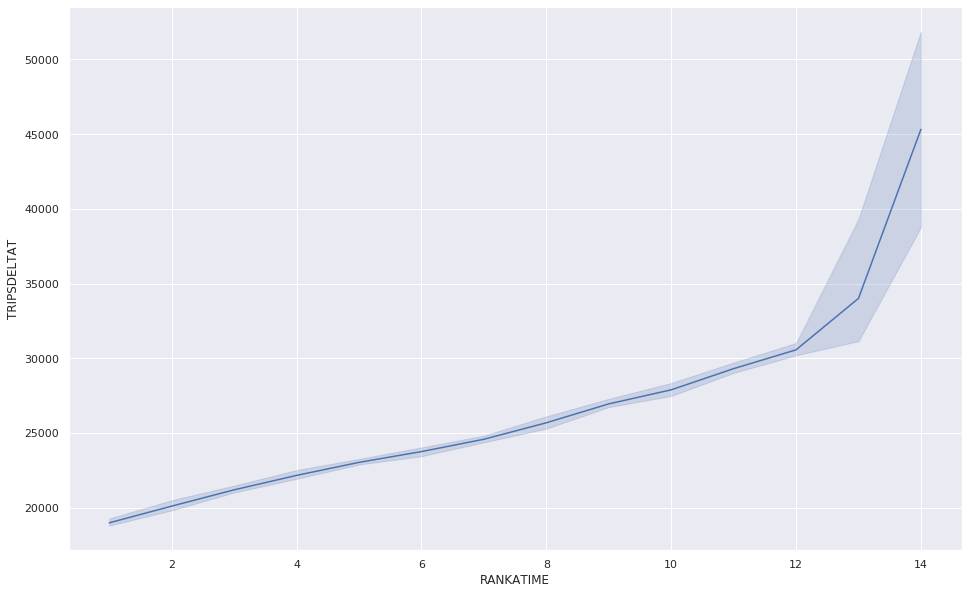

In [514]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.lineplot(data=melted_rs.query("RANK==1 & TRIPSORDER=='ARRIVETIMETRIPS00'"), x="RANKATIME", 
             y="TRIPSDELTAT")
plt.show()

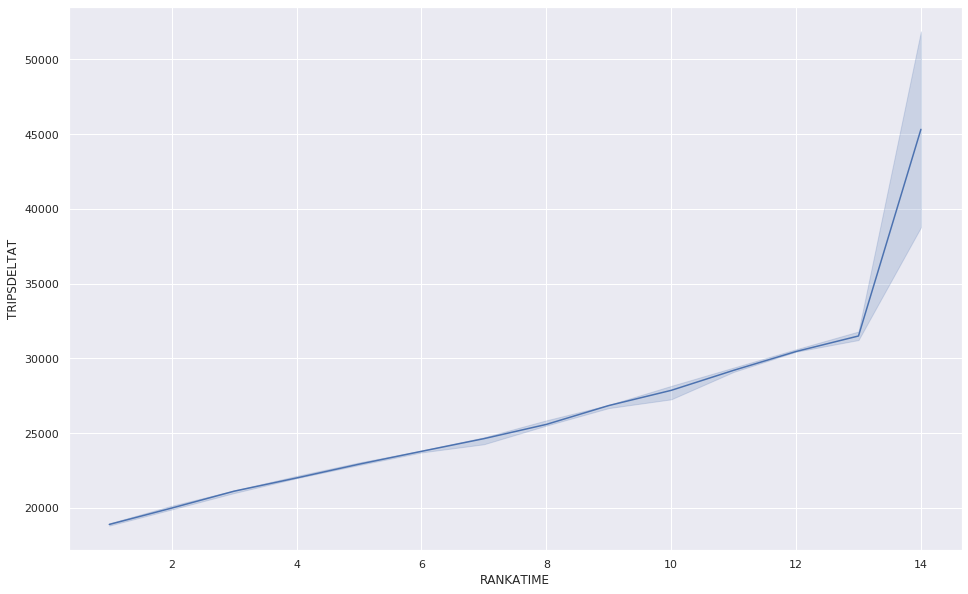

In [511]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.lineplot(data=melted_rs.query("RANK==1 & TRIPSORDER=='ARRIVETIMETRIPS00'"), x="RANKATIME", y="TRIPSDELTAT", estimator=np.median)
plt.show()

## Chạy cho toàn bộ các routevar trong nhiều ngày

In [ ]:
# Ignore output
%%capture
list_date = generate_date_from_range(
    get_date_from_str("20200301"),
    get_date_from_str("20200330")
)
rs_all_route = run_pipeline_multi_date(date_list=list_date, plot=(False, False))

In [678]:
for i, v in rs_all_route.items():
    v["RUNDATE"] = pd.to_datetime(i)

In [683]:
full_result_to_month = pd.concat(rs_all_route, sort=False, ignore_index=True)

In [633]:
# rs_attpt_all_day = rs_all_route["2020-03-16"].to_csv("timetables_attempt_20210314.csv", index=False)

In [709]:
full_result_to_month.query("RUNDATE=='2020-03-19'").head()

ADDRESSNO             ARRIVETIMETRIPS00 BUSPREDIC          CODE  \
1088870  Bến xe Long An 2020-03-19 08:57:30.437399387  51B24995  BXLT Long An   
1088871           C1/1A 2020-03-19 09:49:04.641844988  51B24995       HBC 377   
1088872            C1/1 2020-03-19 09:49:43.937067747  51B24995       HBC 378   
1088873   B6/33 (B6/32) 2020-03-19 09:50:35.325425148  51B24995       HBC 379   
1088874           D6/33 2020-03-19 09:52:17.368515491  51B24995       HBC 380   

              LAT        LNG            NAME     RANK  ROUTEID  \
1088870 10.537597 106.404809  Bến xe Long An 1.000000       99   
1088871 10.656580 106.556552         Ba Làng 2.000000       99   
1088872 10.659037 106.560940     Bình Trường 3.000000       99   
1088873 10.662200 106.566208      Bờ Nhà thờ 4.000000       99   
1088874 10.666301 106.571835  Chợ Bình Chánh 5.000000       99   

                                  ROUTES  ROUTEVARID          SEARCH  \
1088870                             62-8           2  BxLA BxLA Ql1A   
1088871                62-1, 62-10, 62-8           2       BL C Ql1A   
1088872                62-1, 62-10, 62-8           2       BT C Ql1A   
1088873                62-1, 62-10, 62-8           2     BNt B( Ql1A   
1088874  09, 62-1, 62-10, 62-2, 62-8, 73           2      CBC D Ql1A   

                 STATUS  STOPID  STOPTYPE      STREET SUPPORTDISABILITY  \
1088870  Đang khai thác    7211    Bến xe  Quốc lộ 1A                Có   
1088871  Đang khai thác    3427  Trụ dừng  Quốc lộ 1A                     
1088872        Không có    3428  Trụ dừng  Quốc lộ 1A                     
1088873  Đang khai thác    3429  Trụ dừng  Quốc lộ 1A                     
1088874  Đang khai thác     699     Ô sơn  Quốc lộ 1A                     

                  WARD              ZONE    RUNDATE  \
1088870           None       Ngoại thành 2020-03-19   
1088871  Xã Bình Chánh  Huyện Bình Chánh 2020-03-19   
1088872  Xã Bình Chánh  Huyện Bình Chánh 2020-03-19   
1088873  Xã Bình Chánh  Huyện Bình Chánh 2020-03-19   
1088874  Xã Bình Chánh  Huyện Bình Chánh 2020-03-19   

                    ARRIVETIMETRIPS01             ARRIVETIMETRIPS02  \
1088870 2020-03-19 14:00:02.260053635 2020-03-19 19:09:50.368710995   
1088871 2020-03-19 14:49:13.991394520 2020-03-19 19:53:11.885837078   
1088872 2020-03-19 14:49:54.953465939 2020-03-19 19:53:52.145148277   
1088873 2020-03-19 14:50:36.320072651 2020-03-19 19:54:43.752166271   
1088874 2020-03-19 14:51:27.221700907 2020-03-19 19:56:02.728173256   

        ARRIVETIMETRIPS03 ARRIVETIMETRIPS04 ARRIVETIMETRIPS05  \
1088870               NaT               NaT               NaT   
1088871               NaT               NaT               NaT   
1088872               NaT               NaT               NaT   
1088873               NaT               NaT               NaT   
1088874               NaT               NaT               NaT   

        ARRIVETIMETRIPS06 ARRIVETIMETRIPS07 ARRIVETIMETRIPS08  \
1088870               NaT               NaT               NaT   
1088871               NaT               NaT               NaT   
1088872               NaT               NaT               NaT   
1088873               NaT               NaT               NaT   
1088874               NaT               NaT               NaT   

        ARRIVETIMETRIPS09 ARRIVETIMETRIPS10 ARRIVETIMETRIPS11  \
1088870               NaT               NaT               NaT   
1088871               NaT               NaT               NaT   
1088872               NaT               NaT               NaT   
1088873               NaT               NaT               NaT   
1088874               NaT               NaT               NaT   

        ARRIVETIMETRIPS12 ARRIVETIMETRIPS13 ARRIVETIMETRIPS14  \
1088870               NaT               NaT               NaT   
1088871               NaT               NaT               NaT   
1088872               NaT               NaT               NaT   
1088873               NaT               NaT            

In [677]:
rs_all_route.keys()

dict_keys(['2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30'])

In [713]:
(~full_result_to_month.isna()).sum()

ADDRESSNO            2448167
ARRIVETIMETRIPS00    2448167
BUSPREDIC            2448167
CODE                 2448167
LAT                  2448167
LNG                  2448167
NAME                 2448167
RANK                 2448167
ROUTEID              2448167
ROUTES               2448167
ROUTEVARID           2448167
SEARCH               2448167
STATUS               2448167
STOPID               2448167
STOPTYPE             2448167
STREET               2448167
SUPPORTDISABILITY    2448167
WARD                  860992
ZONE                 2448167
RUNDATE              2448167
ARRIVETIMETRIPS01    2311087
ARRIVETIMETRIPS02    2177676
ARRIVETIMETRIPS03    1764320
ARRIVETIMETRIPS04    1031122
ARRIVETIMETRIPS05     227539
ARRIVETIMETRIPS06      42092
ARRIVETIMETRIPS07       9893
ARRIVETIMETRIPS08       3198
ARRIVETIMETRIPS09        295
ARRIVETIMETRIPS10        295
ARRIVETIMETRIPS11        295
ARRIVETIMETRIPS12        295
ARRIVETIMETRIPS13        295
ARRIVETIMETRIPS14        295
ARRIVETIMETRIP

In [711]:
# Save to csv
# full_result_to_month.to_csv("../data/result/all_routevar_march_2020_attempt_20210321.csv", index=False)

 Một vài trường hợp ghi nhận xe bus đứng yên (`DISTANCE` ko thay đổi)

In [593]:
stop_bug, pre_bug = get_data_processed(get_date_from_str("20200316"))

Get bus info.
Get data from /data/ebms/feed/businfo/2020/03/16/routes.json
Get data from /data/ebms/feed/businfo/2020/03/16/timetables.json
Get data from /data/ebms/feed/businfo/2020/03/16/trips.json
Get data from /data/ebms/feed/businfo/2020/03/16/vars.json
Get data from /data/ebms/feed/businfo/2020/03/16/paths.json
Get data from /data/ebms/feed/businfo/2020/03/16/stops.json
Get log data.
/data/ebms/feed/prediction/2020_03_16.csv
Ranking stops sequences.
Get Ratio distance for each stops.


In [594]:
list_route_bug = (
                pre_bug[["ROUTEID", "ROUTEVARID"]]
                    .drop_duplicates()
                    .values.tolist()
            )

In [613]:
pre_bug.query("ROUTEID==87 & ROUTEVARID==1").drop_duplicates(subset=["BUSID"])

REQUESTTIME  STOPID  ROUTEID  ROUTEVARID    BUSID  \
175  2020-03-16T04:00:04+07:00    7217       87           1  53N3643   

                 LOCTIMESTAMP      DISTANCE     SPEED   TIMETOSTOP  \
175 2020-01-25 07:49:32+07:00 19,506.750000 49.000000 2,100.000000   

               CODE              NAME STOPTYPE         ZONE  WARD  \
175  BXLT Dau Tieng  Bến xe Dầu Tiếng   Bến xe  Ngoại thành  None   

            ADDRESSNO              STREET SUPPORTDISABILITY          STATUS  \
175  Bến xe Dầu Tiếng  Thị Trấn Dầu Tiếng                Có  Đang khai thác   

           LNG       LAT          SEARCH ROUTES  \
175 106.362789 11.279727  BxDT BxDT TTDT   61-4   

                             ROUTEVARNAME ROUTEVARSHORTNAME ROUTENO STARTSTOP  \
175  Lượt đi: Bến Dược - Bến xe Dầu Tiếng         Dầu Tiếng    61-4  Bến Dược   

              ENDSTOP  DISTANCE_DIM OUTBOUND  RUNNINGTIME  \
175  Bến xe Dầu Tiếng 19,530.000000     True    35.000000   

                ROUTENAME   TIMESTAMP BUSIDSTR STOPIDSTR  DISTANCERATIO  
175  Bến Dược - Dầu Tiếng  1579913372  53N3643      7217       0.998810

Running for ROUTEID 87 and ROUTEVARID 1
Predic for bus 53N3643 with shape (6474, 35)
Length Time Tables: 0
There are 1 trips: TRIPS00
Remove outliers for trips: TRIPS00
Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


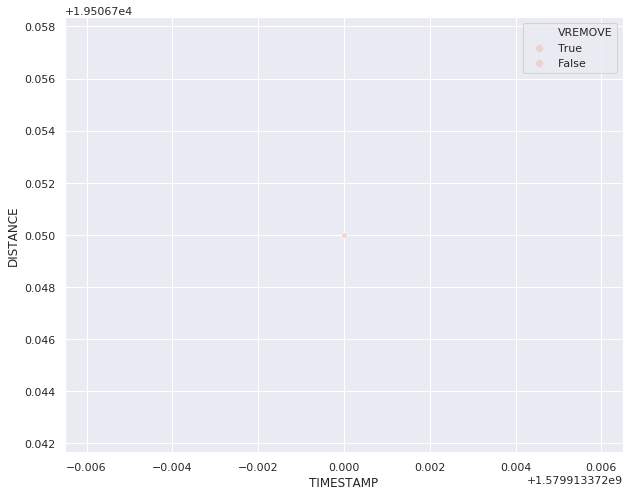

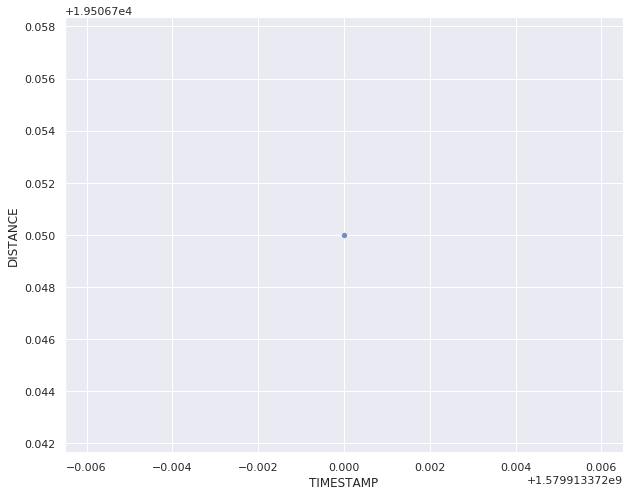

Starting to remove outlier with velocity threshold 1 and max number of iterates is 5 times
Detected 0 outlier.
There is no outliers remain!


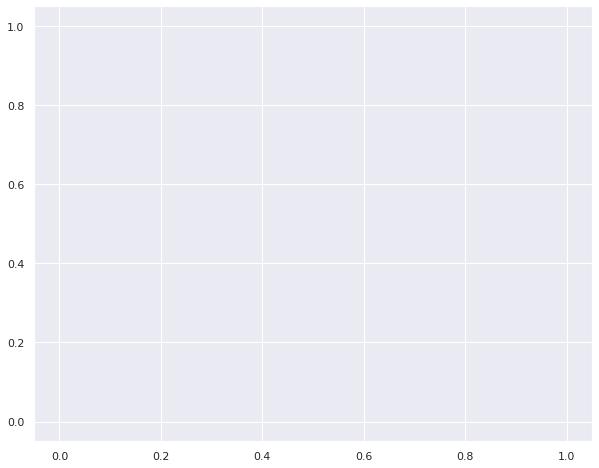

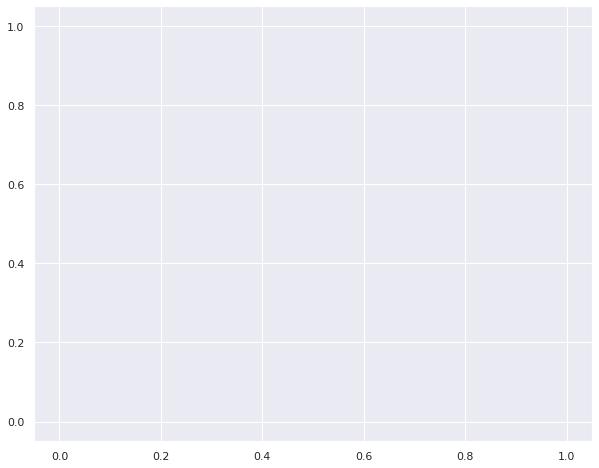

Shape after preprocessing (1, 39)
Predict for trips TRIPS00
There is no decrease distance
Error: (m>k) failed for hidden m: fpcurf0:m=1


In [620]:
time_tables_bug = run_predict_all_route(
    pre_bug,
    stop_bug,
#     list_route_bug,
    [(87, 1)],
    plot=(True, True),
)

In [623]:
time_tables_bug

## Check data mới nhất

In [671]:
ck_st, ck_predic = get_data_processed(get_date_from_str("20210320"))

Get bus info.
Get data from /data/ebms/feed/businfo/2021/03/20/routes.json
Get data from /data/ebms/feed/businfo/2021/03/20/timetables.json
Get data from /data/ebms/feed/businfo/2021/03/20/trips.json
Get data from /data/ebms/feed/businfo/2021/03/20/vars.json
Get data from /data/ebms/feed/businfo/2021/03/20/paths.json
Get data from /data/ebms/feed/businfo/2021/03/20/stops.json
Get log data.
/data/ebms/feed/prediction/2021_03_20.csv
Ranking stops sequences.
Get Ratio distance for each stops.


In [700]:
ck_predic_bk = ck_predic.copy()

In [697]:
ck_predic.head()

REQUESTTIME  STOPID  ROUTEID  ROUTEVARID     BUSID  \
0  2021-03-20T00:19:36+07:00    1403       26           2  51B16497   
1  2021-03-20T00:19:46+07:00    1403       26           2  51B16497   
2  2021-03-20T00:19:56+07:00    1403       26           2  51B16497   
3  2021-03-20T00:20:06+07:00    1403       26           2  51B16497   
4  2021-03-20T00:20:16+07:00    1403       26           2  51B16497   

               LOCTIMESTAMP   DISTANCE    SPEED  TIMETOSTOP  CODE  \
0 2021-03-20 00:19:36+07:00 713.000000 0.000000  175.000000  BX44   
1 2021-03-20 00:19:46+07:00 713.000000 0.000000  165.000000  BX44   
2 2021-03-20 00:19:56+07:00 713.000000 0.000000  155.000000  BX44   
3 2021-03-20 00:20:06+07:00 713.000000 0.000000  165.000000  BX44   
4 2021-03-20 00:20:16+07:00 713.000000 0.000000  195.000000  BX44   

               NAME STOPTYPE             ZONE  WARD         ADDRESSNO  \
0  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
1  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
2  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
3  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
4  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   

         STREET SUPPORTDISABILITY          STATUS        LNG       LAT  \
0  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
1  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
2  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
3  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
4  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   

          SEARCH                               ROUTES  \
0  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
1  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
2  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
3  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
4  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   

                                  ROUTEVARNAME ROUTEVARSHORTNAME ROUTENO  \
0  Lượt về: Bến xe Miền Tây - Bến xe Miền Đông  Bến xe Miền Đông      14   
1  Lượt về: Bến xe Miền Tây - Bến xe Miền Đông  Bến xe Miền Đông      14   
2  Lượt về: Bến xe Miền Tây - Bến xe Miền Đông  Bến xe Miền Đông      14   
3  Lượt về: Bến xe Miền Tây - Bến xe Miền Đông  Bến xe Miền Đông      14   
4  Lượt về: Bến xe Miền Tây - Bến xe Miền Đông  Bến xe Miền Đông      14   

         STARTSTOP           ENDSTOP  DISTANCE_DIM  OUTBOUND  RUNNINGTIME  \
0  Bến xe Miền Tây  Bến xe Miền Đông 16,058.000000     False           60   
1  Bến xe Miền Tây  Bến xe Miền Đông 16,058.000000     False           60   
2  Bến xe Miền Tây  Bến xe Miền Đông 16,058.000000     False           60   
3  Bến xe Miền Tây  Bến xe Miền Đông 16,058.000000     False           60   
4  Bến xe Miền Tây  Bến xe Miền Đông 16,058.000000     False           60   

                                  ROUTENAME   TIMESTAMP  BUSIDSTR STOPIDSTR  \
0  Bến xe Miền Đông - 3/2 - Bến xe Miền Tây  1616174376  51B16497      1403   
1  Bến xe Miền Đông - 3/2 - Bến xe Miền Tây  1616174386  51B16497      1403   
2  Bến xe Miền Đông - 3/2 - Bến xe Miền Tây  1616174396  51B16497      1403   
3  Bến xe Miền Đông - 3/2 - Bến xe Miền Tây  1616174406  51B16497      1403   
4  Bến xe Miền Đông - 3/2 - Bến xe Miền Tây  1616174416  51B16497      1403   

   DISTANCERATIO  
0       0.044402  
1       0.044402  
2       0.044402  
3       0.044402  
4       0.044402

In [702]:
ck_predic["REQUESTTIME"] = pd.to_datetime(ck_predic.REQUESTTIME)
ck_predic["LOCTIMESTAMP"] = pd.to_datetime(ck_predic.LOCTIMESTAMP)

In [707]:
ck_predic.query("REQUESTTIME==LOCTIMESTAMP").head(10)

REQUESTTIME  STOPID  ROUTEID  ROUTEVARID     BUSID  \
0 2021-03-20 00:19:36+07:00    1403       26           2  51B16497   
1 2021-03-20 00:19:46+07:00    1403       26           2  51B16497   
2 2021-03-20 00:19:56+07:00    1403       26           2  51B16497   
3 2021-03-20 00:20:06+07:00    1403       26           2  51B16497   
4 2021-03-20 00:20:16+07:00    1403       26           2  51B16497   
5 2021-03-20 00:20:26+07:00    1403       26           2  51B16497   
6 2021-03-20 00:20:37+07:00    1403       26           2  51B16497   
7 2021-03-20 00:20:47+07:00    1403       26           2  51B16497   
8 2021-03-20 00:20:57+07:00    1403       26           2  51B16497   
9 2021-03-20 00:21:07+07:00    1403       26           2  51B16497   

               LOCTIMESTAMP   DISTANCE    SPEED  TIMETOSTOP  CODE  \
0 2021-03-20 00:19:36+07:00 713.000000 0.000000  175.000000  BX44   
1 2021-03-20 00:19:46+07:00 713.000000 0.000000  165.000000  BX44   
2 2021-03-20 00:19:56+07:00 713.000000 0.000000  155.000000  BX44   
3 2021-03-20 00:20:06+07:00 713.000000 0.000000  165.000000  BX44   
4 2021-03-20 00:20:16+07:00 713.000000 0.000000  195.000000  BX44   
5 2021-03-20 00:20:26+07:00 713.000000 0.000000  185.000000  BX44   
6 2021-03-20 00:20:37+07:00 713.000000 0.000000  175.000000  BX44   
7 2021-03-20 00:20:47+07:00 713.000000 0.000000  165.000000  BX44   
8 2021-03-20 00:20:57+07:00 713.000000 0.000000  155.000000  BX44   
9 2021-03-20 00:21:07+07:00 713.000000 0.000000  165.000000  BX44   

               NAME STOPTYPE             ZONE  WARD         ADDRESSNO  \
0  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
1  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
2  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
3  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
4  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
5  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
6  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
7  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
8  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
9  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   

         STREET SUPPORTDISABILITY          STATUS        LNG       LAT  \
0  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
1  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
2  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
3  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
4  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
5  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
6  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
7  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
8  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
9  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   

          SEARCH                               ROUTES  \
0  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
1  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
2  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
3  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
4  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
5  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
6  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
7  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
8  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
9  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   

                                  ROUTEVARNAME ROUTEVARSHORTNAME ROUTENO  \
0  Lượt về: Bến xe Miền Tây - Bến xe Miền Đông  Bến xe Miền Đông      14   
1  Lượt về: Bến xe Miền Tây - Bến xe Miền Đông  Bến xe Miền Đông      14   
2  Lượt về

In [708]:
ck_predic.query("REQUESTTIME==LOCTIMESTAMP").tail(10)

REQUESTTIME  STOPID  ROUTEID  ROUTEVARID     BUSID  \
5174594 2021-03-20 22:03:34+07:00    1403       26           2  51B16281   
5174595 2021-03-20 22:03:44+07:00    1403       26           2  51B16281   
5174596 2021-03-20 22:03:54+07:00    1403       26           2  51B16281   
5174597 2021-03-20 22:04:04+07:00    1403       26           2  51B16281   
5174598 2021-03-20 22:04:14+07:00    1403       26           2  51B16281   
5174599 2021-03-20 22:04:24+07:00    1403       26           2  51B16281   
5174600 2021-03-20 22:04:34+07:00    1403       26           2  51B16281   
5174601 2021-03-20 22:04:44+07:00    1403       26           2  51B16281   
5174602 2021-03-20 22:04:54+07:00    1403       26           2  51B16281   
5174603 2021-03-20 22:05:04+07:00    1403       26           2  51B16281   

                     LOCTIMESTAMP   DISTANCE    SPEED  TIMETOSTOP  CODE  \
5174594 2021-03-20 22:03:34+07:00 710.000000 0.000000  110.000000  BX44   
5174595 2021-03-20 22:03:44+07:00 710.000000 0.000000  120.000000  BX44   
5174596 2021-03-20 22:03:54+07:00 710.000000 0.000000  110.000000  BX44   
5174597 2021-03-20 22:04:04+07:00 710.000000 0.000000  121.000000  BX44   
5174598 2021-03-20 22:04:14+07:00 710.000000 0.000000  111.000000  BX44   
5174599 2021-03-20 22:04:24+07:00 710.000000 0.000000  101.000000  BX44   
5174600 2021-03-20 22:04:34+07:00 710.000000 0.000000  110.000000  BX44   
5174601 2021-03-20 22:04:44+07:00 710.000000 0.000000  101.000000  BX44   
5174602 2021-03-20 22:04:54+07:00 710.000000 0.000000  111.000000  BX44   
5174603 2021-03-20 22:05:04+07:00 710.000000 0.000000  101.000000  BX44   

                     NAME STOPTYPE             ZONE  WARD         ADDRESSNO  \
5174594  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
5174595  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
5174596  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
5174597  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
5174598  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
5174599  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
5174600  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
5174601  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
5174602  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   
5174603  Bến xe Miền Đông   Bến xe  Quận Bình Thạnh  None  Bến xe Miền Đông   

               STREET SUPPORTDISABILITY          STATUS        LNG       LAT  \
5174594  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
5174595  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
5174596  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
5174597  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
5174598  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
5174599  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
5174600  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
5174601  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
5174602  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   
5174603  Đinh Bộ Lĩnh                    Đang khai thác 106.711294 10.814733   

                SEARCH                               ROUTES  \
5174594  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
5174595  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
5174596  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
5174597  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
5174598  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
5174599  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
5174600  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
5174601  BxMD BxMD DBL  14, 146, 24, 43, 45, 60-3, 60-4, 64   
5174602  BxMD BxMD DBL  14, 146, 24, 43, 

In [705]:
ck_predic.query("REQUESTTIME==LOCTIMESTAMP").shape

(5174604, 35)

In [706]:
ck_predic.shape

(5174604, 35)

Read all data.

In [751]:
!ls ../data/stag/processed_data/

20200301  20200310  20200317


In [767]:
rm -r ../data/stag/processed_data/*

In [768]:
%%capture
list_of_date = [
        get_date_from_str("20200316"),
        get_date_from_str("20200410"),
        get_date_from_str("20200510"),
        get_date_from_str("20200610"),
        get_date_from_str("20200710"),
        get_date_from_str("20200810"),
        get_date_from_str("20200910"),
        get_date_from_str("20201010"),
        get_date_from_str("20201110"),
        get_date_from_str("20201210"),
]

stag_processed = "../data/stag/processed_data/"

path_stag = pathlib.Path(stag_processed)

for d in list_of_date:
    path_data = path_stag / d.strftime("%Y%m%d")
    path_data.mkdir()
    ck_st, ck_predic = get_data_processed(d)
    ck_st.astype("str").to_csv(path_data / "stop.csv", index=False)
    ck_predic.astype("str").to_csv(path_data / "predic.csv", index=False)

In [812]:
# Dung lượng file predic
!du -d 1 -h /data/ebms/feed/prediction/*

22M	/data/ebms/feed/prediction/2020_03_10.csv
738M	/data/ebms/feed/prediction/2020_03_11.csv
732M	/data/ebms/feed/prediction/2020_03_12.csv
732M	/data/ebms/feed/prediction/2020_03_13.csv
731M	/data/ebms/feed/prediction/2020_03_14.csv
732M	/data/ebms/feed/prediction/2020_03_15.csv
680M	/data/ebms/feed/prediction/2020_03_16.csv
729M	/data/ebms/feed/prediction/2020_03_17.csv
719M	/data/ebms/feed/prediction/2020_03_18.csv
730M	/data/ebms/feed/prediction/2020_03_19.csv
486M	/data/ebms/feed/prediction/2020_03_20.csv
487M	/data/ebms/feed/prediction/2020_03_21.csv
480M	/data/ebms/feed/prediction/2020_03_22.csv
704M	/data/ebms/feed/prediction/2020_03_23.csv
720M	/data/ebms/feed/prediction/2020_03_24.csv
718M	/data/ebms/feed/prediction/2020_03_25.csv
713M	/data/ebms/feed/prediction/2020_03_26.csv
709M	/data/ebms/feed/prediction/2020_03_27.csv
432M	/data/ebms/feed/prediction/2020_03_28.csv
358M	/data/ebms/feed/prediction/2020_03_29.csv
372M	/data/ebms/feed/prediction/2020_03_30.csv
404M	/data/ebm

In [785]:
ck_pr = pd.read_csv("../data/stag/processed_data/20200710/predic.csv")

In [783]:
ck_st, ck_predic = get_data_processed(get_date_from_str("20210220"))

Get bus info.
Get data from /data/ebms/feed/businfo/2021/02/20/routes.json
Get data from /data/ebms/feed/businfo/2021/02/20/timetables.json
Get data from /data/ebms/feed/businfo/2021/02/20/trips.json
Get data from /data/ebms/feed/businfo/2021/02/20/vars.json
Get data from /data/ebms/feed/businfo/2021/02/20/paths.json
Get data from /data/ebms/feed/businfo/2021/02/20/stops.json
Get log data.
/data/ebms/feed/prediction/2021_02_20.csv
Ranking stops sequences.
Get Ratio distance for each stops.


In [817]:
ck_predic.head()

REQUESTTIME  STOPID  ROUTEID  ROUTEVARID     BUSID  \
0  2021-02-20T02:38:02+07:00     496      100           2  62B00825   
1  2021-02-20T02:38:02+07:00    3125      100           2  62B00825   
2  2021-02-20T02:38:12+07:00     496      100           2  62B00825   
3  2021-02-20T02:38:12+07:00    3125      100           2  62B00825   
4  2021-02-20T02:38:22+07:00     496      100           2  62B00825   

               LOCTIMESTAMP      DISTANCE     SPEED   TIMETOSTOP     CODE  \
0 2021-02-20 02:38:02+07:00 29,356.000000 24.000000 3,776.000000    BX 20   
1 2021-02-20 02:38:02+07:00 21,382.000000 24.000000 2,065.000000  HBC 203   
2 2021-02-20 02:38:12+07:00 29,356.000000 24.000000 3,766.000000    BX 20   
3 2021-02-20 02:38:12+07:00 21,382.000000 24.000000 2,054.000000  HBC 203   
4 2021-02-20 02:38:22+07:00 29,356.000000 24.000000 3,756.000000    BX 20   

                 NAME  STOPTYPE              ZONE             WARD  \
0  Bến xe buýt Quận 8    Bến xe            Quận 8             None   
1   Đường liên Ấp 1-2  Trụ dừng  Huyện Bình Chánh  Xã Phạm Văn Hai   
2  Bến xe buýt Quận 8    Bến xe            Quận 8             None   
3   Đường liên Ấp 1-2  Trụ dừng  Huyện Bình Chánh  Xã Phạm Văn Hai   
4  Bến xe buýt Quận 8    Bến xe            Quận 8             None   

            ADDRESSNO      STREET SUPPORTDISABILITY          STATUS  \
0  BẾN XE BUÝT QUẬN 8  Quốc lộ 50                    Đang khai thác   
1             A8/240A  Quốc lộ 50                    Đang khai thác   
2  BẾN XE BUÝT QUẬN 8  Quốc lộ 50                    Đang khai thác   
3             A8/240A  Quốc lộ 50                    Đang khai thác   
4  BẾN XE BUÝT QUẬN 8  Quốc lộ 50                    Đang khai thác   

         LNG       LAT            SEARCH                               ROUTES  \
0 106.656357 10.733545  BxbQ8 BXBQ8 Ql50  08, 22, 25, 34, 59, 62, 62-11, 62-9   
1 106.651658 10.663001     DlA1-2 A Ql50                      47, 62-11, 62-9   
2 106.656357 10.733545  BxbQ8 BXBQ8 Ql50  08, 22, 25, 34, 59, 62, 62-11, 62-9   
3 106.651658 10.663001     DlA1-2 A Ql50                      47, 62-11, 62-9   
4 106.656357 10.733545  BxbQ8 BXBQ8 Ql50  08, 22, 25, 34, 59, 62, 62-11, 62-9   

  ROUTEVARNAME   ROUTEVARSHORTNAME ROUTENO       STARTSTOP  \
0      lượt đi  Bến xe buýt Quận 8    62-9  Bến xe Gò Công   
1      lượt đi  Bến xe buýt Quận 8    62-9  Bến xe Gò Công   
2      lượt đi  Bến xe buýt Quận 8    62-9  Bến xe Gò Công   
3      lượt đi  Bến xe buýt Quận 8    62-9  Bến xe Gò Công   
4      lượt đi  Bến xe buýt Quận 8    62-9  Bến xe Gò Công   

              ENDSTOP  DISTANCE_DIM  OUTBOUND  RUNNINGTIME  \
0  Bến xe buýt Quận 8 50,590.000000     False          100   
1  Bến xe buýt Quận 8 50,590.000000     False          100   
2  Bến xe buýt Quận 8 50,590.000000     False          100   
3  Bến xe buýt Quận 8 50,590.000000     False          100   
4  Bến xe buýt Quận 8 50,590.000000     False          100   

                             ROUTENAME   TIMESTAMP  BUSIDSTR STOPIDSTR  \
0  Bến xe buýt Quận 8 - Thị xã Gò Công  1613763482  62B00825       496   
1  Bến xe buýt Quận 8 - Thị xã Gò Công  1613763482  62B00825      3125   
2  Bến xe buýt Quận 8 - Thị xã Gò Công  1613763492  62B00825       496   
3  Bến xe buýt Quận 8 - Thị xã Gò Công  1613763492  62B00825      3125   
4  Bến xe buýt Quận 8 - Thị xã Gò Công  1613763502  62B00825       496   

   DISTANCERATIO  
0       0.580273  
1       0.422653  
2       0.580273  
3       0.422653  
4       0.580273

In [820]:
# Check số lượng records REQUESTTIME và LOCTIMESTAMP giống nhau
(pd.to_datetime(ck_predic.REQUESTTIME).dt.tz_localize(None) != ck_predic.LOCTIMESTAMP.dt.tz_localize(None)).sum()

0

2 Columns là như nhau

## Run for Many months

For:
- March: from 15
- For May: from 12
- Full month for June and July
- Change date range to run predict full and save to specific files

In [ ]:
%%capture
list_date = generate_date_from_range(
    get_date_from_str("20200512"),
    get_date_from_str("20200531")
)
rs_all_route_2_month = run_pipeline_multi_date(date_list=list_date, plot=(False, False))

In [ ]:
for i, v in rs_all_route_2_month.items():
    v["RUNDATE"] = pd.to_datetime(i)

In [ ]:
rs_all_route_2_month.keys()

In [ ]:
full_result_to_month_2_month = pd.concat(rs_all_route_2_month, sort=False)

In [ ]:
full_result_to_month_2_month.shape

In [ ]:
full_result_to_month_2_month.shape

In [ ]:
full_result_to_month_2_month = full_result_to_month_2_month.reset_index(level=0).rename({"level_0": "DATEPREDIC"}, axis=1)

In [ ]:
# full_result_to_month_2_month.to_csv("../data/stag/full_result_2_month.csv", index=False)

In [ ]:
full_result_to_month_2_month.to_pickle("../data/stag/full_result_05_month_final.pkl")

In [17]:
# Read all file has calculated
list_files = [
    "full_result_05_month_final.pkl",
    "full_result_03_month_final.pkl",
    "full_result_06_07_month_final.pkl",
]
data_final = []
for f in list_files:j
    data_rs_m = pd.read_pickle(f"../data/stag/{f}")
    data_final.append(data_rs_m)

full_data_final = pd.concat(data_final, sort=False)

In [19]:
DICT_DAY_OF_WEEK = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}

In [20]:
def _preprocess_stats_data(data_df):
    data_df["DATEPREDIC"] = pd.to_datetime(data_df["DATEPREDIC"])
    data_df["DAYOFW"] = data_df.DATEPREDIC.dt.dayofweek.copy()
    data_df["DAYOFWSTR"] = data_df.DAYOFW.replace(DICT_DAY_OF_WEEK).copy()
    
    data_df = data_df.sort_values(["ROUTEID", "ROUTEVARID", "BUSPREDIC", "RANK", "STOPID", "DATEPREDIC"])
    
    return data_df.copy()

In [21]:
def gen_data_day_of_week(data_df):
    for _, d in DICT_DAY_OF_WEEK.items():
        yield d, data_df[data_df.DAYOFWSTR == d].copy()

In [22]:
def preprocess_timestable(final_rs):
    melted_rs = final_rs.melt(
        id_vars=["ROUTEID", "ROUTEVARID", "BUSPREDIC", "STOPID", "DATEPREDIC", "RANK", "DAYOFWSTR"], 
        value_vars=final_rs.columns[
            final_rs.columns.str.contains("ARRIVETIMETRIPS")
        ].tolist(),
        var_name="TRIPSORDER",
        value_name="TRIPSTIME"
    )

    melted_rs = melted_rs.merge(
        final_rs,
        on=["ROUTEID", "ROUTEVARID", "BUSPREDIC", "STOPID", "DATEPREDIC", "RANK", "DAYOFWSTR"],
        how="inner"
    )

    melted_rs["TRIPSTIME"] = pd.to_datetime(melted_rs["TRIPSTIME"])
    melted_rs["TRIPSHOUR"] = melted_rs.TRIPSTIME - melted_rs.TRIPSTIME.dt.floor("d")

    # Remove not have time
    melted_rs = melted_rs.dropna(subset=["TRIPSTIME"])

    melted_rs["RANKATIME"] = melted_rs.groupby(
        ["TRIPSORDER", "RANK", "DATEPREDIC", "ROUTEID", "ROUTEVARID", "DAYOFWSTR"]
    ).TRIPSTIME.rank(method="first")

    melted_rs["TRIPSDELTAT"] = melted_rs.TRIPSHOUR.dt.total_seconds()
    
    return melted_rs

In [ ]:
processed_stats_data = _preprocess_stats_data(full_data_final)

In [51]:
processed_stats_data.head()

DATEPREDIC            ADDRESSNO              ARRIVETIMETRIPS00  \
2065  2020-03-15  Công trường Mê Linh  2020-03-15 05:54:19.305824757   
5099  2020-03-16  Công trường Mê Linh  2020-03-16 06:34:07.780208588   
5247  2020-03-19  Công trường Mê Linh  2020-03-19 05:08:36.037348747   
48405 2020-03-20  Công trường Mê Linh  2020-03-20 13:22:22.238245010   
272   2020-03-21  Công trường Mê Linh  2020-03-21 05:44:22.682597160   

                   ARRIVETIMETRIPS01              ARRIVETIMETRIPS02  \
2065   2020-03-15 07:46:17.092486382  2020-03-15 09:33:28.761762619   
5099   2020-03-16 01:04:02.221105576  2020-03-16 11:58:14.949021339   
5247   2020-03-19 07:09:10.989599228  2020-03-19 08:58:03.225883484   
48405                            NaT                            NaT   
272    2020-03-21 07:33:17.357947350  2020-03-21 09:23:08.731305599   

                   ARRIVETIMETRIPS03              ARRIVETIMETRIPS04  \
2065   2020-03-15 11:23:38.606197357  2020-03-15 13:26:01.787670135   
5099   2020-03-16 14:06:53.912205219  2020-03-16 15:45:37.937027931   
5247   2020-03-19 10:46:29.847923279  2020-03-19 12:44:31.412033558   
48405                            NaT                            NaT   
272    2020-03-21 11:10:49.648530006  2020-03-21 13:08:01.238297701   

                   ARRIVETIMETRIPS05              ARRIVETIMETRIPS06  \
2065   2020-03-15 15:09:52.601021767  2020-03-15 16:57:40.889061451   
5099   2020-03-16 19:13:44.285793304                            NaT   
5247   2020-03-19 14:36:28.009644508  2020-03-19 16:22:02.290007591   
48405                            NaT                            NaT   
272    2020-03-21 15:00:12.483623505  2020-03-21 16:48:37.859865189   

                   ARRIVETIMETRIPS07              ARRIVETIMETRIPS08  \
2065   2020-03-15 18:45:21.414052010                            NaT   
5099                             NaT                            NaT   
5247   2020-03-19 18:10:07.748628616  2020-03-19 20:10:19.071854591   
48405                            NaT                            NaT   
272    2020-03-21 18:32:39.877468109                            NaT   

      ARRIVETIMETRIPS09 BUSPREDIC   CODE       LAT        LNG  \
2065                NaT  51B02536  BX 06 10.776790 106.705856   
5099                NaT  51B02536  BX 06 10.776790 106.705856   
5247                NaT  51B02536  BX 06 10.776790 106.705856   
48405               NaT  51B02536  BX 06 10.776790 106.705856   
272                 NaT  51B02536  BX 06 10.776790 106.705856   

                      NAME     RANK  ROUTEID  ROUTES  ROUTEVARID  \
2065   Công Trường Mê Linh 1.000000        1  01, 02           1   
5099   Công Trường Mê Linh 1.000000        1  01, 02           1   
5247   Công Trường Mê Linh 1.000000        1  01, 02           1   
48405  Công Trường Mê Linh 1.000000        1  01, 02           1   
272    Công Trường Mê Linh 1.000000        1  01, 02           1   

             SEARCH          STATUS  STOPID STOPTYPE    STREET  \
2065   CTML CtML TS  Đang khai thác      33   Bến xe  Thi Sách   
5099   CTML CtML TS  Đang khai thác      33   Bến xe  Thi Sách   
5247   CTML CtML TS  Đang khai thác      33   Bến xe  Thi Sách   
48405  CTML CtML TS  Đang khai thác      33   Bến xe  Thi Sách   
272    CTML CtML TS  Đang khai thác      33   Bến xe  Thi Sách   

      SUPPORTDISABILITY  WARD    ZONE              RUNDATE ARRIVETIMETRIPS10  \
2065                     None  Quận 1  2020-03-15 00:00:00               NaT   
5099                     None  Quận 1  2020-03-16 00:00:00               NaT   
5247                     None  Quận 1  2020-03-19 00:00:00               NaT   
48405                    None  Quận 1  2020-03-20 00:00:00               NaT   
272                      None  Quận 1  2020-03-21 00:00:00               NaT   

      ARRIVETIMETRIPS11 ARRIVETIMETRIPS12 ARRIVETIMETRIPS13 ARRIVETIMETRIPS14  \
2065                NaT               NaT               NaT               NaT   
5099                NaT  

In [31]:
data_dow = gen_data_day_of_week(processed_stats_data)
_cols_to_draw = ['ROUTEID', 'ROUTEVARID', 'BUSPREDIC', 'STOPID', 'DATEPREDIC', 'RANK', 'DAYOFWSTR', "RANKATIME", 'TRIPSORDER', "TRIPSDELTAT"]
# Run by chunk data
stats_preprocess_rs = {}
for k, v in data_dow:
    print(f"Running preprocess for: {k}")
#     stats_preprocess_rs[k] = preprocess_timestable(v)
    data_to_get_ttb = preprocess_timestable(v)
    data_to_get_ttb[_cols_to_draw].to_pickle(f"../data/stag/preprocessed_to_get_ttb_final/preprocessed_ttb_{k}.pkl")

Running preprocess for: Monday
Running preprocess for: Tuesday
Running preprocess for: Wednesday
Running preprocess for: Thursday
Running preprocess for: Friday
Running preprocess for: Saturday
Running preprocess for: Sunday


In [ ]:
# stats_preprocess_rs.keys()

In [ ]:
# # Export data before get time tables
# for k, v in stats_preprocess_rs.items():
#     v[_cols_to_draw].to_pickle(f"../data/stag/preprocessed_2month/preprocessed_ttb_{k}.pkl")

In [32]:
def get_final_stats_timetables(melted_rs):
    _col_i = ["ROUTEID", "ROUTEVARID", "STOPID", "TRIPSORDER", "RANK", "RANKATIME", "DAYOFWSTR"]
    stats_rs = melted_rs.groupby(
        _col_i
    ).agg(
        **{
            "NUMREC": pd.NamedAgg("ROUTEID", "size"),
            "MEAN": pd.NamedAgg("TRIPSDELTAT", "mean"),
            "MEDIAN": pd.NamedAgg("TRIPSDELTAT", "median"),
            "VAR": pd.NamedAgg("TRIPSDELTAT", "var"),
            "STD": pd.NamedAgg("TRIPSDELTAT", "std"),
            "MIN": pd.NamedAgg("TRIPSDELTAT", "min"),
            "MAX": pd.NamedAgg("TRIPSDELTAT", "max"),
        }
    ).reset_index().sort_values(
        ["ROUTEID", "ROUTEVARID", "TRIPSORDER", "RANK", "RANKATIME", "DAYOFWSTR"] 
        + ["NUMREC", "MEAN", "MEDIAN"]
    )
    stats_rs[['MEAN', 'MEDIAN', 'STD', 'MIN', 'MAX']] = stats_rs[['MEAN', 'MEDIAN', 'STD', 'MIN', 'MAX']].apply(pd.to_timedelta, unit="s")
    
    return stats_rs

In [42]:
stats_timetables = {}
for k, v in DICT_DAY_OF_WEEK.items():
    print(f"Stats for: {v}")
    dt = pd.read_pickle(f"../data/stag/preprocessed_to_get_ttb_final/preprocessed_ttb_{v}.pkl")
    stats_timetables[v] = get_final_stats_timetables(dt)
# .to_pickle(f"../data/result/rs_final_3567_ttb/time_tables_{k}.pkl")

Stats for: Monday
Stats for: Tuesday
Stats for: Wednesday
Stats for: Thursday
Stats for: Friday
Stats for: Saturday
Stats for: Sunday


In [58]:
stats_timetables["Sunday"].head()

ROUTEID  ROUTEVARID  STOPID         TRIPSORDER     RANK  RANKATIME  \
170        1           1      33  ARRIVETIMETRIPS00 1.000000   1.000000   
171        1           1      33  ARRIVETIMETRIPS00 1.000000   2.000000   
172        1           1      33  ARRIVETIMETRIPS00 1.000000   3.000000   
173        1           1      33  ARRIVETIMETRIPS00 1.000000   4.000000   
174        1           1      33  ARRIVETIMETRIPS00 1.000000   5.000000   

    DAYOFWSTR  NUMREC            MEAN          MEDIAN              VAR  \
170    Sunday      14 04:59:22.724665 05:01:09.094683 6,589,013.405394   
171    Sunday      14 05:23:30.002417 05:15:00.582080 2,319,740.857009   
172    Sunday      14 05:40:22.948041 05:30:11.425479 3,075,497.853205   
173    Sunday      14 05:57:40.543064 05:48:24.045424 3,448,378.981877   
174    Sunday      14 06:11:02.432648 05:58:36.951071 4,546,983.007502   

                STD             MIN             MAX  
170 00:42:46.907362 02:49:03.079334 05:59:31.499413  
171 00:25:23.069550 04:57:41.173471 06:24:07.982566  
172 00:29:13.709740 05:15:02.892639 06:55:34.420983  
173 00:30:56.981147 05:25:28.199779 07:17:19.996879  
174 00:35:32.365589 05:52:22.975282 07:47:13.880563

In [59]:
stats_timetables["Monday"].query("ROUTEID==44 & ROUTEVARID==87")

ROUTEID  ROUTEVARID  STOPID         TRIPSORDER      RANK  RANKATIME  \
299566       44          87     278  ARRIVETIMETRIPS00  1.000000   1.000000   
299567       44          87     278  ARRIVETIMETRIPS00  1.000000   2.000000   
299568       44          87     278  ARRIVETIMETRIPS00  1.000000   3.000000   
299569       44          87     278  ARRIVETIMETRIPS00  1.000000   4.000000   
299570       44          87     278  ARRIVETIMETRIPS00  1.000000   5.000000   
...         ...         ...     ...                ...       ...        ...   
300401       44          87    3939  ARRIVETIMETRIPS01 55.000000   2.000000   
300343       44          87    2265  ARRIVETIMETRIPS01 56.000000   1.000000   
300344       44          87    2265  ARRIVETIMETRIPS01 56.000000   2.000000   
300324       44          87    2227  ARRIVETIMETRIPS01 57.000000   1.000000   
300325       44          87    2227  ARRIVETIMETRIPS01 57.000000   2.000000   

       DAYOFWSTR  NUMREC            MEAN          MEDIAN                  VAR  \
299566    Monday       2 13:44:41.050292 13:44:41.050292     2,266,247.732030   
299567    Monday       2 13:34:20.298156 13:34:20.298156 2,380,088,755.189538   
299568    Monday       2 04:42:48.624248 04:42:48.624248        29,853.087797   
299569    Monday       2 04:59:25.618873 04:59:25.618873        35,795.388574   
299570    Monday       2 05:10:34.494317 05:10:34.494317       292,966.469166   
...          ...     ...             ...             ...                  ...   
300401    Monday       1 11:53:11.937171 11:53:11.937171                  nan   
300343    Monday       1 16:23:22.370539 16:23:22.370539                  nan   
300344    Monday       1 16:27:53.496422 16:27:53.496422                  nan   
300324    Monday       1 17:29:59.051170 17:29:59.051170                  nan   
300325    Monday       1 17:56:06.740936 17:56:06.740936                  nan   

                   STD             MIN             MAX  
299566 00:25:05.406168 13:26:56.567382 14:02:25.533203  
299567 13:33:06.153314 03:59:23.278320 23:09:17.317993  
299568 00:02:52.780461 04:40:46.450012 04:44:50.798483  
299569 00:03:09.196692 04:57:11.836608 05:01:39.401137  
299570 00:09:01.263770 05:04:11.763034 05:16:57.225599  
...                ...             ...             ...  
300401             NaT 11:53:11.937171 11:53:11.937171  
300343             NaT 16:23:22.370539 16:23:22.370539  
300344             NaT 16:27:53.496422 16:27:53.496422  
300324             NaT 17:29:59.051170 17:29:59.051170  
300325             NaT 17:56:06.740936 17:56:06.740936  

[1083 rows x 14 columns]

In [60]:
stats_timetables["Monday"].groupby(["ROUTEID", "ROUTEVARID", "RANKATIME", "TRIPSORDER", "NUMREC"]).size().to_frame("count").reset_index().sort_values("NUMREC").head(100)

ROUTEID  ROUTEVARID  RANKATIME         TRIPSORDER  NUMREC  count
6577        43          85   4.000000  ARRIVETIMETRIPS05       1     47
1361         8          16   8.000000  ARRIVETIMETRIPS03       1     65
17213      137         274   2.000000  ARRIVETIMETRIPS08       1     35
17214      137         274   2.000000  ARRIVETIMETRIPS09       1     35
15089      116         231   6.000000  ARRIVETIMETRIPS05       1     44
1357         8          16   7.000000  ARRIVETIMETRIPS03       1     65
15083      116         231   5.000000  ARRIVETIMETRIPS07       1     44
17223      137         274   3.000000  ARRIVETIMETRIPS08       1     35
15082      116         231   5.000000  ARRIVETIMETRIPS06       1     44
15081      116         231   5.000000  ARRIVETIMETRIPS05       1     44
17231      137         274   4.000000  ARRIVETIMETRIPS07       1     35
17232      137         274   4.000000  ARRIVETIMETRIPS08       1     35
15090      116         231   6.000000  ARRIVETIMETRIPS06       1     44
15075      116         231   4.000000  ARRIVETIMETRIPS08       1     44
17240      137         274   5.000000  ARRIVETIMETRIPS07       1     35
15074      116         231   4.000000  ARRIVETIMETRIPS07       1     44
6964        45          89  17.000000  ARRIVETIMETRIPS04       1     68
15073      116         231   4.000000  ARRIVETIMETRIPS06       1     44
17248      137         274   6.000000  ARRIVETIMETRIPS07       1     35
6969        45          89  18.000000  ARRIVETIMETRIPS04       1     68
17255      137         274   7.000000  ARRIVETIMETRIPS06       1     35
17256      137         274   7.000000  ARRIVETIMETRIPS07       1     35
1337         8          16   2.000000  ARRIVETIMETRIPS05       1     65
1336         8          16   2.000000  ARRIVETIMETRIPS04       1     65
6974        45          89  19.000000  ARRIVETIMETRIPS04       1     68
6959        45          89  16.000000  ARRIVETIMETRIPS04       1     68
15096      116         231   7.000000  ARRIVETIMETRIPS05       1     44
17204      137         274   1.000000  ARRIVETIMETRIPS09       1     35
6889        45          89   2.000000  ARRIVETIMETRIPS05       1     68
6827        44          88  11.000000  ARRIVETIMETRIPS07       1     58
6832        44          88  12.000000  ARRIVETIMETRIPS04       1     58
6833        44          88  12.000000  ARRIVETIMETRIPS05       1     58
6834        44          88  12.000000  ARRIVETIMETRIPS06       1     58
6835        44          88  12.000000  ARRIVETIMETRIPS07       1     58
6840        44          88  13.000000  ARRIVETIMETRIPS04       1     58
6841        44          88  13.000000  ARRIVETIMETRIPS05       1     58
6842        44          88  13.000000  ARRIVETIMETRIPS06       1     58
6843        44          88  13.000000  ARRIVETIMETRIPS07       1     58
6848        44          88  14.000000  ARRIVETIMETRIPS04       1     58
6849        44          88  14.000000  ARRIVETIMETRIPS05       1     58
6850        44          88  14.000000  ARRIVETIMETRIPS06       1     58
6851        44          88  14.000000  ARRIVETIMETRIPS07       1     58
6856        44          88  15.000000  ARRIVETIMETRIPS04       1     58
6857        44          88  15.000000  ARRIVETIMETRIPS05       1     58
6862        44          88  16.000000  ARRIVETIMETRIPS04       1     58
6863        44          88  16.000000  ARRIVETIMETRIPS05       1     58
6867        44          88  17.000000  ARRIVETIMETRIPS03       1     58
6868        44          88  17.000000  ARRIVETIMETRIPS04       1     58
6869        44          88  17.000000  ARRIVETIMETRIPS05       1     58
6874        44          88  19.000000  ARRIVETIMETRIPS01       1     58
6881        45          89   1.000000  ARRIVETIMETRIPS06       1     68
17194      137         273  19.000000  ARRIVETIMETRIPS04       1     35
6882        45          89   1.000000  ARRIVETIMETRIPS07       1     68
6883        45          89   1.000000  ARRIVETIMETRIPS08       1     68
15066      116         231   3.000000  ARRIVETI

In [69]:
# for k, v in stats_timetables.items():
#     v.to_csv(f"../data/result/rs_2month/time_tables_{k}.csv", index=False)

In [63]:
for k, v in stats_timetables.items():
    v.to_pickle(f"../data/result/rs_final_3567_ttb/time_tables_{k}.pkl")

Summary files:
- Kết quả predict: `../data/stag/full_result_*_month_final.pkl`
- Tiền xử lý trước khi tính time tables: `../data/stag/preprocessed_to_get_ttb_final/preprocessed_ttb_*.pkl` (Monday, Tuesday,...)
- Kết quả time tables: `../data/result/rs_final_3567_ttb/time_tables_*.pkl`

## Export some data to visualize

In [120]:
list_date_dim_info = generate_date_from_range(
    get_date_from_str("20200601"),
    get_date_from_str("20200731")
)

for d in list_date_dim_info:
    all_data_cp = get_all_bus_info(
        d, 
        list_info_files=list_bus_info_file_names
    )
    # Upper all column names
    upper_columns_names(all_data_cp)
    # Lấy thông tin (merge thông tin) từ nhiều file
    get_stops_full_data(all_data_cp)
    str_d = d.strftime("%Y%m%d")
    
    print("Ranking stops sequences.")
    paths_df = all_data_cp["paths.json"].copy()
    paths_df["TEMPPSTR"] = paths_df.apply(lambda x: "{}:{}".format(x["LNG"], x["LAT"]), axis=1)
    line_path = (
        paths_df.groupby(["ROUTEID", "ROUTEVARID"])
            .TEMPPSTR.apply(list)
            .apply(",".join)
            .to_frame("PATHSTR")
            .reset_index()
    )
    
    line_string = get_linestring_all_path(all_data_cp["paths.json"])
    stops_ddf = all_data_cp["full_stops"].copy()
    stops_ddf = stops_ddf.dropna(subset=["LNG", "LAT"]).copy()
    stops_ddf = stops_ddf.merge(
        line_string,
        on=["ROUTEID", "ROUTEVARID"],
        how="inner",
        suffixes=("", "LINEINFO")
    )
    stops_ddf = stops_ddf.merge(
        line_path,
        on=["ROUTEID", "ROUTEVARID"],
        how="inner",
        suffixes=("", "LINEINFO")
    )

    stops_ddf["SPOINT"] = stops_ddf.apply(lambda x: Point(x["LNG"], x["LAT"]), axis=1)
    stops_ddf["DISTANCE"] = stops_ddf.apply(lambda x: x["LINESTRING"].project(x["SPOINT"]), axis=1)
    stops_ddf["NEARESTPOINT"] = stops_ddf.apply(
        lambda x: nearest_points(x["LINESTRING"], x["SPOINT"])[0],
        axis=1,
    )
    stops_ddf["RANK"] = stops_ddf.groupby(["ROUTEID", "ROUTEVARID"]).DISTANCE.rank(method="first")

    # final data with ranking of stops id and distance ratio
    stops_ddf = stops_ddf.sort_values(["ROUTEID", "ROUTEVARID", "RANK"])
    stops_ddf = get_distance_ratio_each_route(stops_ddf).drop("STOPS_LINESTRING", axis=1).drop("LINESTRING", axis=1)
    print("Get Ratio distance for each stops.")
    
    stops_ddf.to_csv(f"../data/stag/stops_2month/full_stops_{str_d}.csv", index=False)

Get data from /data/ebms/feed/businfo/2020/06/01/routes.json
Get data from /data/ebms/feed/businfo/2020/06/01/timetables.json
Get data from /data/ebms/feed/businfo/2020/06/01/trips.json
Get data from /data/ebms/feed/businfo/2020/06/01/vars.json
Get data from /data/ebms/feed/businfo/2020/06/01/paths.json
Get data from /data/ebms/feed/businfo/2020/06/01/stops.json
Ranking stops sequences.
Get Ratio distance for each stops.
Get data from /data/ebms/feed/businfo/2020/06/02/routes.json
Get data from /data/ebms/feed/businfo/2020/06/02/timetables.json
Get data from /data/ebms/feed/businfo/2020/06/02/trips.json
Get data from /data/ebms/feed/businfo/2020/06/02/vars.json
Get data from /data/ebms/feed/businfo/2020/06/02/paths.json
Get data from /data/ebms/feed/businfo/2020/06/02/stops.json
Ranking stops sequences.
Get Ratio distance for each stops.
Get data from /data/ebms/feed/businfo/2020/06/03/routes.json
Get data from /data/ebms/feed/businfo/2020/06/03/timetables.json
Get data from /data/ebms

Get data from /data/ebms/feed/businfo/2020/06/20/vars.json
Get data from /data/ebms/feed/businfo/2020/06/20/paths.json
Get data from /data/ebms/feed/businfo/2020/06/20/stops.json
Ranking stops sequences.
Get Ratio distance for each stops.
Get data from /data/ebms/feed/businfo/2020/06/21/routes.json
Get data from /data/ebms/feed/businfo/2020/06/21/timetables.json
Get data from /data/ebms/feed/businfo/2020/06/21/trips.json
Get data from /data/ebms/feed/businfo/2020/06/21/vars.json
Get data from /data/ebms/feed/businfo/2020/06/21/paths.json
Get data from /data/ebms/feed/businfo/2020/06/21/stops.json
Ranking stops sequences.
Get Ratio distance for each stops.
Get data from /data/ebms/feed/businfo/2020/06/22/routes.json
Get data from /data/ebms/feed/businfo/2020/06/22/timetables.json
Get data from /data/ebms/feed/businfo/2020/06/22/trips.json
Get data from /data/ebms/feed/businfo/2020/06/22/vars.json
Get data from /data/ebms/feed/businfo/2020/06/22/paths.json
Get data from /data/ebms/feed/b

Ranking stops sequences.
Get Ratio distance for each stops.
Get data from /data/ebms/feed/businfo/2020/07/10/routes.json
Get data from /data/ebms/feed/businfo/2020/07/10/timetables.json
Get data from /data/ebms/feed/businfo/2020/07/10/trips.json
Get data from /data/ebms/feed/businfo/2020/07/10/vars.json
Get data from /data/ebms/feed/businfo/2020/07/10/paths.json
Get data from /data/ebms/feed/businfo/2020/07/10/stops.json
Ranking stops sequences.
Get Ratio distance for each stops.
Get data from /data/ebms/feed/businfo/2020/07/11/routes.json
Get data from /data/ebms/feed/businfo/2020/07/11/timetables.json
Get data from /data/ebms/feed/businfo/2020/07/11/trips.json
Get data from /data/ebms/feed/businfo/2020/07/11/vars.json
Get data from /data/ebms/feed/businfo/2020/07/11/paths.json
Get data from /data/ebms/feed/businfo/2020/07/11/stops.json
Ranking stops sequences.
Get Ratio distance for each stops.
Get data from /data/ebms/feed/businfo/2020/07/12/routes.json
Get data from /data/ebms/feed

Get data from /data/ebms/feed/businfo/2020/07/29/vars.json
Get data from /data/ebms/feed/businfo/2020/07/29/paths.json
Get data from /data/ebms/feed/businfo/2020/07/29/stops.json
Ranking stops sequences.
Get Ratio distance for each stops.
Get data from /data/ebms/feed/businfo/2020/07/30/routes.json
Get data from /data/ebms/feed/businfo/2020/07/30/timetables.json
Get data from /data/ebms/feed/businfo/2020/07/30/trips.json
Get data from /data/ebms/feed/businfo/2020/07/30/vars.json
Get data from /data/ebms/feed/businfo/2020/07/30/paths.json
Get data from /data/ebms/feed/businfo/2020/07/30/stops.json
Ranking stops sequences.
Get Ratio distance for each stops.
Get data from /data/ebms/feed/businfo/2020/07/31/routes.json
Get data from /data/ebms/feed/businfo/2020/07/31/timetables.json
Get data from /data/ebms/feed/businfo/2020/07/31/trips.json
Get data from /data/ebms/feed/businfo/2020/07/31/vars.json
Get data from /data/ebms/feed/businfo/2020/07/31/paths.json
Get data from /data/ebms/feed/b

Detail predic

In [148]:
list_date_dim_info = generate_date_from_range(
    get_date_from_str("20200601"),
    get_date_from_str("20200731")
)

In [149]:
for d in list_date_dim_info:
    prediction_df_example = load_predictions(
        get_prediction_path(d),
        PREDICTION_COLUMN_HEADERS
    )
    d_str = d.strftime("%Y%m%d")
    prediction_df_example.to_pickle(f"../data/raw/prediction_raw_2month/predic_2month_{d_str}.pkl")

/data/ebms/feed/prediction/2020_06_01.csv
/data/ebms/feed/prediction/2020_06_02.csv
/data/ebms/feed/prediction/2020_06_03.csv
/data/ebms/feed/prediction/2020_06_04.csv
/data/ebms/feed/prediction/2020_06_05.csv
/data/ebms/feed/prediction/2020_06_06.csv
/data/ebms/feed/prediction/2020_06_07.csv
/data/ebms/feed/prediction/2020_06_08.csv
/data/ebms/feed/prediction/2020_06_09.csv
/data/ebms/feed/prediction/2020_06_10.csv
/data/ebms/feed/prediction/2020_06_11.csv
/data/ebms/feed/prediction/2020_06_12.csv
/data/ebms/feed/prediction/2020_06_13.csv
/data/ebms/feed/prediction/2020_06_14.csv
/data/ebms/feed/prediction/2020_06_15.csv
/data/ebms/feed/prediction/2020_06_16.csv
/data/ebms/feed/prediction/2020_06_17.csv
/data/ebms/feed/prediction/2020_06_18.csv
/data/ebms/feed/prediction/2020_06_19.csv
/data/ebms/feed/prediction/2020_06_20.csv
/data/ebms/feed/prediction/2020_06_21.csv
/data/ebms/feed/prediction/2020_06_22.csv
/data/ebms/feed/prediction/2020_06_23.csv
/data/ebms/feed/prediction/2020_06

In [141]:
prediction_df_example = load_predictions(
    get_prediction_path(get_date_from_str("20200601")),
    PREDICTION_COLUMN_HEADERS
)

/data/ebms/feed/prediction/2020_06_01.csv
